# Домашнее задание №1 по вычислительной математике
*Выполнил: Белиловский Иван, Б06-202*

---


## Задача №1

Расммотрим неавтономную систему уравнений Ван-дер-Поля:
$$
\begin{cases}
    \dot{y_1} = a\left(- \left( \frac{y_1^3}{3} - y_1\right) + y_2\right)\\
    \dot{y_2} = -y_1 + A\cos(\omega t)
\end{cases}
$$

Рассмотрим 2 случая: $a=10^3$ и $a=10^6$ с начальными условиями: $y_1(0) = 2; ~~ y_2(0) = 0$
- Рассмотреть численно случаи $0<A<1$ и $1<A<\sqrt{1 + \frac{1}{64\omega^2}}$; Исследовать поведение системы при различных значениях $\omega$ (конечное время интегрирования системы $T_k = 200$)
- Получить численное решение с помощью 4х различных методов:
    - метода CROS (одностадийный метод Розенброка с комплексными коэффициентами)
    - Однократно диагональных методов Рунге-Кутты с двумя стадиями (второго порядка аппрокисмации, асимптотически устойчивого и третьего порядка аппроксимации)

Таблицы Бутчера для последних 3х методов:

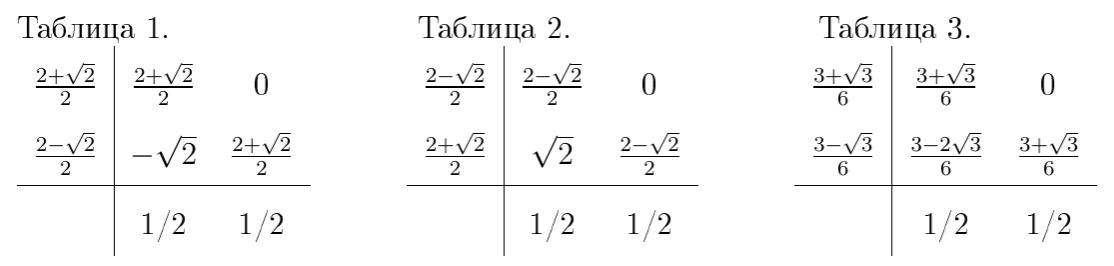

**В таблицах Бутчера допущена ошибка. Для обеспечения нужного порядка аппрокисмации необходимо изменить коэффициенты $a_{ij}$ что будет сделано далее для каждого метода отдельно**

### Схема Розенброка с комплексными коэффициентами второго порядка (CROS)
Одностадийную схему можно записать в виде:
$$
(E - \gamma h J)w = f(x_0 + \alpha_1 h, y_0)\\
y_1 = y_0 + h \text{Re} w
$$
Для данной схемы можно доказать следующие утвержденя:
- Схема имеет точность $O(h^2)$, если $\text{Re} \gamma = \alpha_1 =\frac12$
- Схема А-устойчива, если $\text{Re} \gamma \geq \frac12$ 

На полуокружности: $\gamma  =\frac{1 + e^{i\varphi}}{2}$; $-\frac\pi2\leq\varphi\leq\frac\pi2$ схема L1 устойчива.

На концах полуокружности $\gamma =\frac{1\pm i }{2}$ схема имеет рекордную L2 устойчивость и является монотонной. Таким образом она принимает вид:
$$
(E - \frac{1 + i}{2} h J)w = f(x_0 + \frac h2, y_0)\\
y_1 = y_0 + h \text{Re} w
$$

In [72]:
import numpy as np
import matplotlib.pyplot as plt

Реализуем данный метод на языке `python`:

In [73]:
def cros_method(func, jacobian, t_span, y0, h, omega, a, A):
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end + h, h)
    y_values = [np.array(y0, dtype=complex)]

    # Комплексные коэффициенты метода
    gamma = complex(0.5, 0.5)  # Пример комплексного коэффициента

    for t in t_values[:-1]:
        y_n = y_values[-1]

        # Вычисляем k1
        J = jacobian(t, y_n, omega, a, A)  # Якобиан системы
        I = np.eye(len(y_n))  # Единичная матрица
        S = I - gamma * h * J  # Матрица для решения линейной системы

        k1 = np.linalg.solve(S, func(t+h/2, y_n, omega, a, A))

        # Вычисляем новое значение решения
        y_new = y_n + h * k1

        # Добавляем результат в список
        y_values.append(y_new)

    return t_values, np.array(y_values).real

**Тест метода на жёсткой системе**:

Проведём тест данного метода на примере простой жёссткой задачи, для которой мы знаем точное аналитическое решение:
$$
\begin{cases}
    \dot{y_1} = -100y_1 \\
    \dot{y_2} = -y_2
\end{cases}
; ~~~~\bold{J} = 
\begin{pmatrix}
    -100 & 0 \\
    0 & -1
\end{pmatrix}
$$

In [199]:
# Пример жёсткой системы ОДУ: линейная система с большими разницами в собственных значениях
def stiff_system(t, y, a, omega, A):
    """Жёсткая система ОДУ."""
    lambda0 = -100  # Большой отрицательный параметр
    lambda1 = -1    # Малый отрицательный параметр
    dy0dt = lambda0*y[0]
    dy1dt = lambda1*y[1]
    return np.array([dy0dt, dy1dt], dtype=complex)


def stiff_system_jacobian(t, y, a, omega, A):
    """Якобиан жёсткой системы ОДУ."""
    lambda0 = -100
    lambda1 = -1
    return np.array(([lambda0, 0], [0, lambda1]))

# Решение системы
t_stiff, y_stiff = cros_method(stiff_system, stiff_system_jacobian, t_span=[0,10], y0=[1.0, 1.0], h=0.001, a=None, omega=None, A=None)

Text(0, 0.5, '$\\Delta y$')

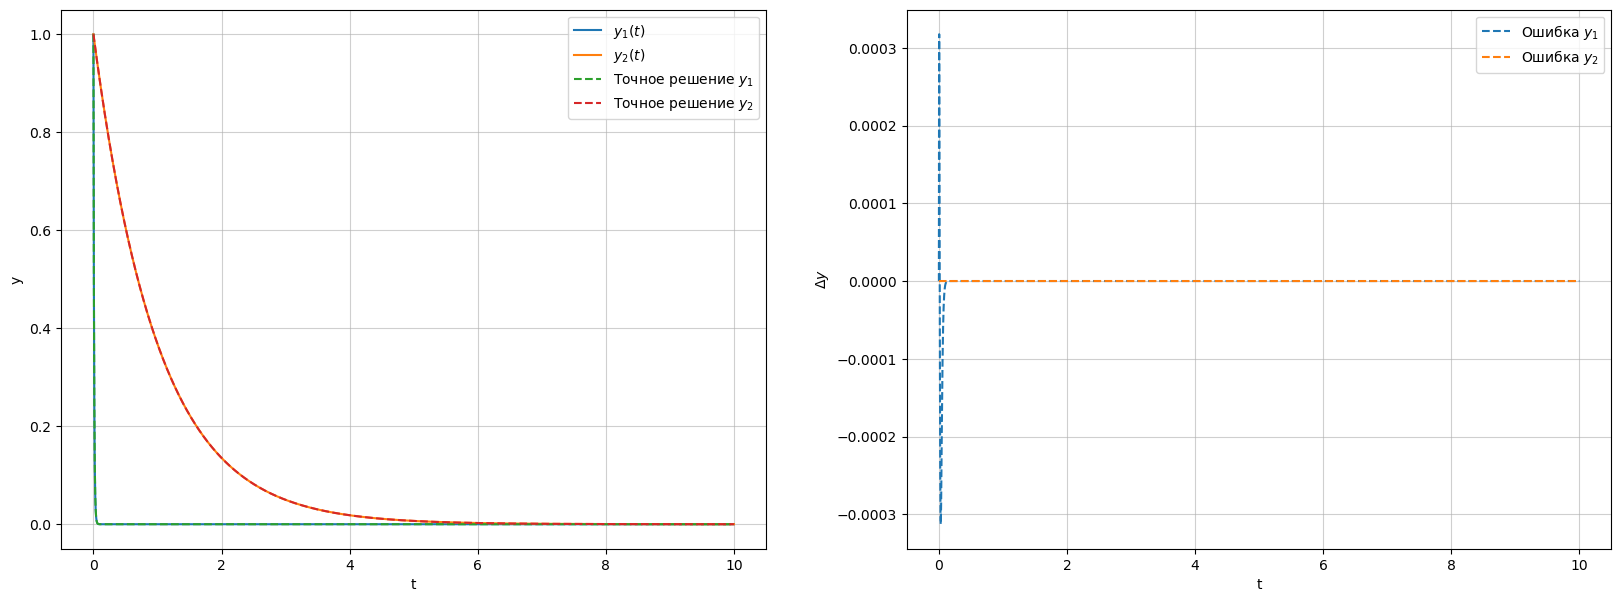

In [200]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(20)

ax[0].plot(t_stiff, y_stiff[:, 0], label=r'$y_1(t)$')
ax[0].plot(t_stiff, y_stiff[:, 1], label=r'$y_2(t)$')
ax[0].plot(t_stiff, np.exp(-100*t_stiff), label=r'Точное решение $y_1$', linestyle='--')
ax[0].plot(t_stiff, np.exp(-t_stiff), label=r'Точное решение $y_2$', linestyle='--')
ax[0].grid(alpha=0.6)
ax[0].legend()
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')

ax[1].plot(t_stiff, y_stiff[:, 0] - np.exp(-100*t_stiff), label=r'Ошибка $y_1$', linestyle='--')
ax[1].plot(t_stiff, y_stiff[:, 1] - np.exp(-t_stiff), label=r'Ошибка $y_2$', linestyle='--')
ax[1].grid(alpha=0.6)
ax[1].legend()
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Delta y$')
#plt.plot(t_values, 1.41*np.cos(t_values), linestyle='--')
# plt.plot(t_values, np.exp(-t_values), linestyle='--')

По данному графику видно, что метод `CROS` справляется с решением двумерной автономной жёсткой задачи хорошо.

**Решение поставленной задачи**

Построим решение нашей задачи с помощью данного метода. Начальные условия: $y_1(0)=2; ~~y_2(0)=0$. Парметры задачи: $a=10^3, h=0.001, T\in[0; 200]$.

Для данной системы: $\frac{\lambda_{max}}{\lambda_{min}}\sim 10^3~÷~10^6$. 

In [74]:
def my_system(t, y, omega, a, A):
    """Моя система"""
    dy1dt = a*(y[0] - y[0]**3/3 + y[1])
    dy2dt = -y[0] + A*np.cos(omega*t)
    return np.array([dy1dt, dy2dt], dtype=complex)


def my_system_jacobian(t, y, omega, a, A):
    """Якобиан жёсткой системы ОДУ."""
    return np.array(([a*(1 - y[0]**2), a], [-1, 0]))

Далее я буду тестировать все перечисленные в условии методы с парамтерами задачи: $a=10^3; ~~A=0$ (автономная система); $T\in[0;20]$ поскольку периодичность полученного решения около $\tau=2$ и при построении в большем диапазоне грифик не будет презентативным

Text(0, 0.5, '$y_i(t)$')

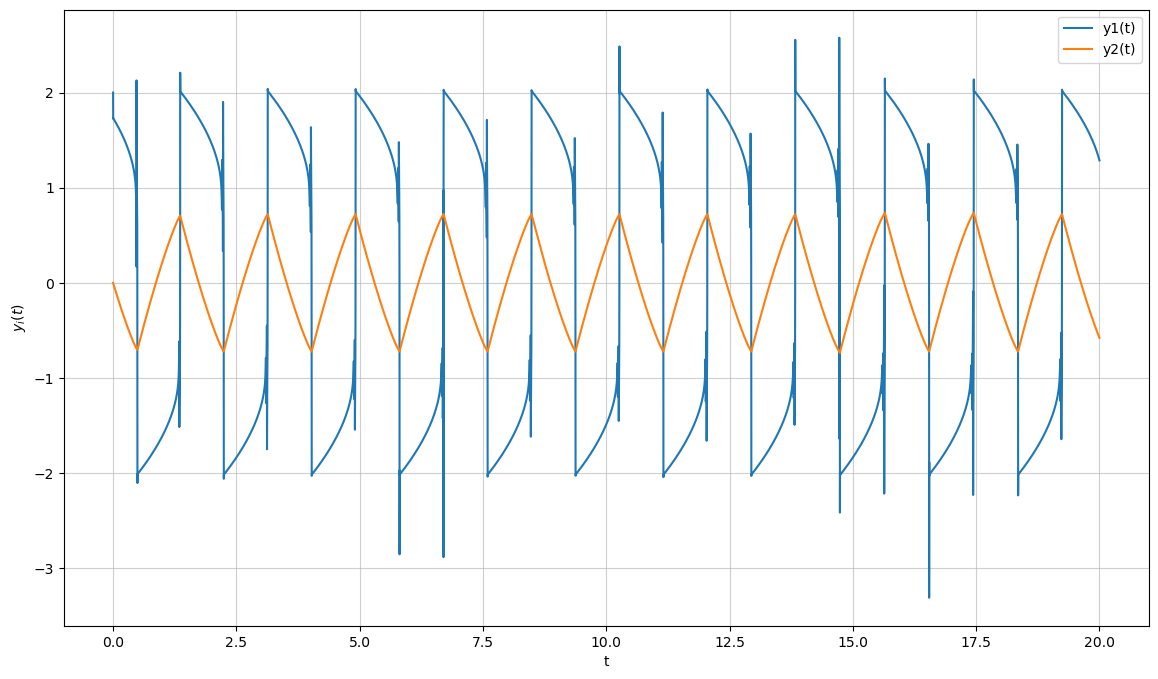

In [82]:
# Решение системы
t_my, y_my = cros_method(my_system, my_system_jacobian, t_span=[0,20], y0=[2.0, 0.0], h=0.0005, omega=1, A=0, a=1000)

plt.figure(figsize=(14,8))
plt.plot(t_my, y_my[:, 0], label='y1(t)')
plt.plot(t_my, y_my[:, 1], label='y2(t)') 
plt.grid(alpha=0.6)
plt.legend()
plt.xlabel('t')
plt.ylabel('$y_i(t)$')

Построим фазовые траектории полученного решения:

Text(0, 0.5, 'y2')

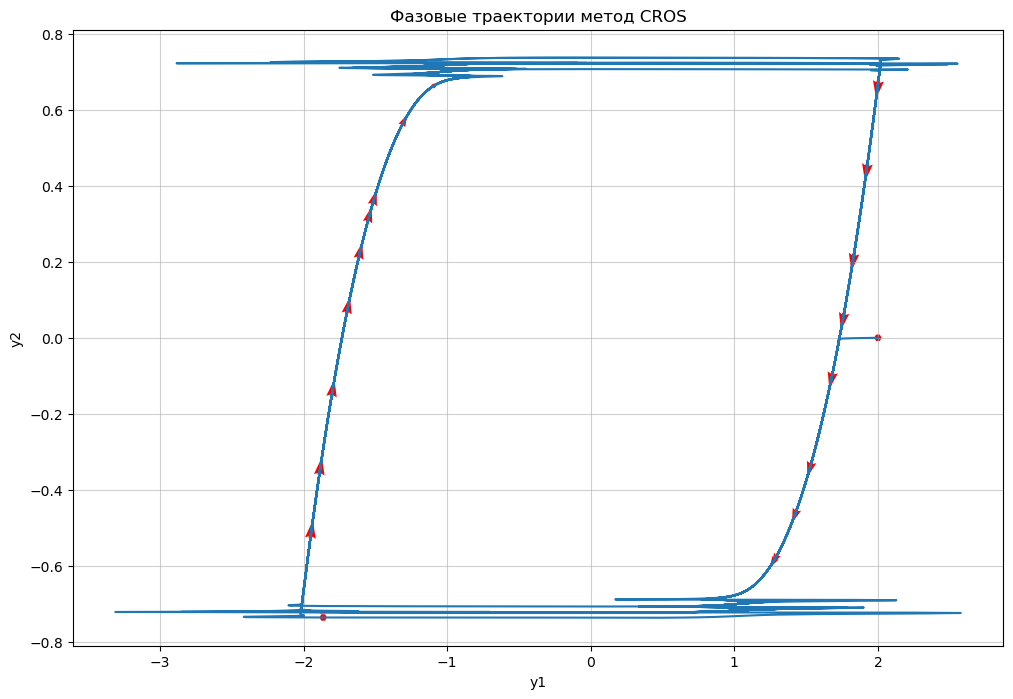

In [81]:
plt.figure(figsize=(12,8))
plt.plot(y_my[:, 0].real, y_my[:, 1].real)

arrow_indices = np.linspace(0, len(y_my[:, 0]) - 1, 20, dtype=int)  # Choose 15 points
for idx in arrow_indices:
    y1 = y_my[:, 0][idx]
    y2 = y_my[:, 1][idx]
    t = t_my[idx]
    
    # Compute derivatives at this point
    dy1_dt = 1000 * (-((y1**3) / 3 - y1) + y2)
    dy2_dt = -y1 + 0 * np.cos(1 * t)
    
    # Normalize the vector for better visualization
    magnitude = np.sqrt(dy1_dt**2 + dy2_dt**2)
    if magnitude > 0:  # Avoid division by zero
        dy1_dt /= magnitude
        dy2_dt /= magnitude
    
    # Plot the arrow
    plt.quiver(y1, y2, dy1_dt, dy2_dt, color="red", angles='xy', scale_units='xy', scale=20, width=0.008)
plt.grid(alpha=0.6)
plt.title('Фазовые траектории метод CROS')
plt.xlabel('y1')
plt.ylabel('y2')

Сравним решение полученное нами с помощью метода `CROS` с неявными методами Рунге-Кутты и методом ФДН

### Неявные методы Рунге-Кутты

Таблица Бутчера для первого метода:
\begin{matrix}
\frac{2+\sqrt{2}}{2}&\frac{2+\sqrt{2}}{2}&0\\
\frac{2-\sqrt{2}}{2}&-\sqrt{2}&\frac{2+\sqrt{2}}{2}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

Проверим условия порядков: 
- Для первого порядка:$\sum\limits_{i}b_i = 1$ – так и есть
- Для второго поядка:$\sum\limits_{i}b_ic_i = \frac 12$ – а у нас 1

Немного изменим коэффициенты таблицы с учётом выполенния условий Кутты для получения 2 порядка:

Исправленная таблица:
\begin{matrix}
\frac{2+\sqrt{2}}{4}&\frac{2+\sqrt{2}}{4}&0\\
\frac{2-\sqrt{2}}{4}&-\frac1{\sqrt{2}}&\frac{2+\sqrt{2}}{4}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

Реализуем данный метод (`DIRK1`):

In [84]:
from scipy.optimize import root

def dirk_1(f, g, t_span, h, y0, a, A, omega):
    # Butcher table coefficients
    a11 = (2 + np.sqrt(2)) / 4
    a21 = -1/np.sqrt(2)
    a22 = (2 + np.sqrt(2)) / 4
    b1 = 0.5
    b2 = 0.5
    c1 = (2 + np.sqrt(2)) / 4
    c2 = (2 - np.sqrt(2)) / 4
    
    t0, tf = t_span
    # Number of steps
    n = int((tf - t0) / h)
    
    # Arrays to store results
    t_values = np.linspace(t0, tf, n + 1)
    y1_values = np.zeros(n + 1)
    y2_values = np.zeros(n + 1)
    
    # Initial conditions
    y1_values[0] = y0[0]
    y2_values[0] = y0[1]
    
    # Helper function to solve the implicit equation
    def implicit_stage(k, t, y1, y2, stage):
        if stage == 1:
            tn = t + c1 * h
            y1n = y1 + h * (a11 * k[0])
            y2n = y2 + h * (a11 * k[1])
        elif stage == 2:
            tn = t + c2 * h
            y1n = y1 + h * (a21 * k_prev[0] + a22 * k[0])
            y2n = y2 + h * (a21 * k_prev[1] + a22 * k[1])
        
        # Compute residuals
        res1 = k[0] - f(tn, y1n, y2n)
        res2 = k[1] - g(tn, y1n, y2n)
        return [res1, res2]
    
    # DIRK loop
    for i in range(n):
        t = t_values[i]
        y1 = y1_values[i]
        y2 = y2_values[i]
        
        # Stage 1
        k1_guess = [f(t + c1 * h, y1, y2), g(t + c1 * h, y1, y2)]
        sol1 = root(lambda k: implicit_stage(k, t, y1, y2, stage=1), k1_guess)
        k1 = sol1.x
        
        # Stage 2
        k_prev = k1  # Use k1 from Stage 1 for Stage 2
        k2_guess = [f(t + c2 * h, y1, y2), g(t + c2 * h, y1, y2)]
        sol2 = root(lambda k: implicit_stage(k, t, y1, y2, stage=2), k2_guess)
        k2 = sol2.x
        
        # Update solution
        y1_values[i + 1] = y1 + h * (b1 * k1[0] + b2 * k2[0])
        y2_values[i + 1] = y2 + h * (b1 * k1[1] + b2 * k2[1])
    
    return t_values, y1_values, y2_values

In [194]:
def f(t, y1, y2, a, A, omega):
    return a * (-((y1**3) / 3 - y1) + y2)

def g(t, y1, y2, a,  A, omega):
    return -y1 + A * np.cos(omega * t)

Построим решения нашей ситсемы с помощью данного метода:

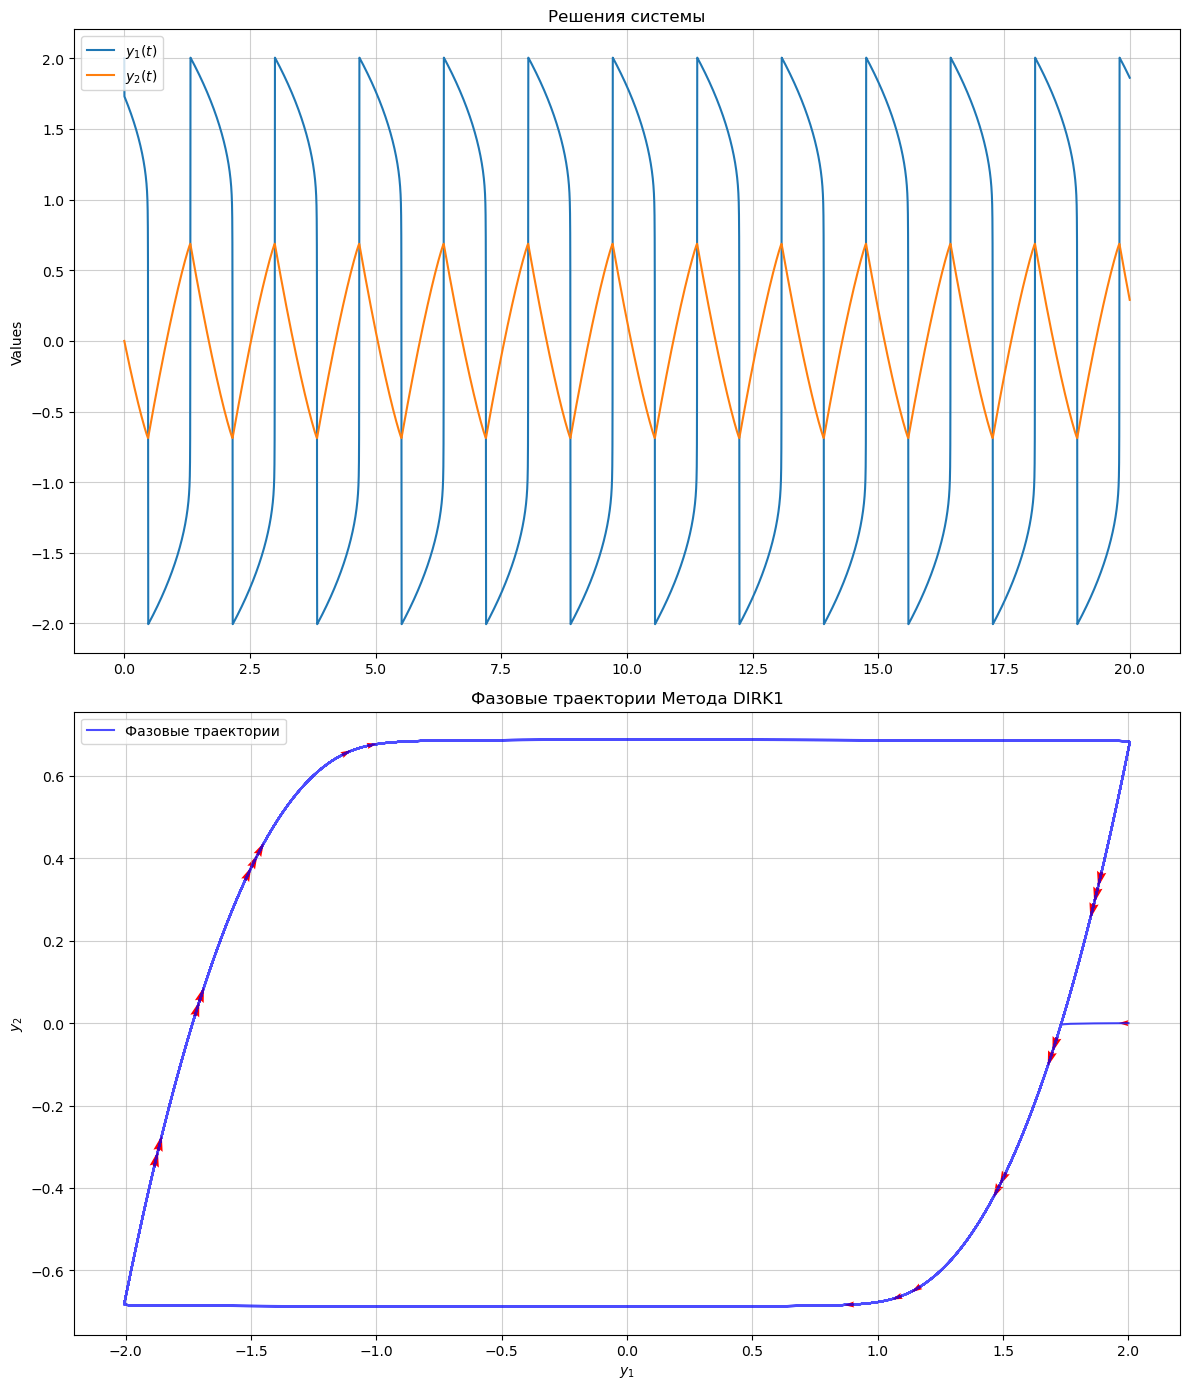

In [99]:
a=1000
A=0
omega=1

# Solve the system
t_rk1_drk1, y1_rk1_drk1, y2_rk1_drk1 = dirk_1(lambda t, y1, y2: f(t, y1, y2, a, A, omega), lambda t, y1, y2: g(t, y1, y2,a, A, omega), t_span=[0.0, 20.0], h=0.0003, y0=[2.0, 0.0], a=1000, A=0, omega=0)

plt.figure(figsize=(12, 14))

# Time evolution
plt.subplot(2, 1, 1)
plt.plot(t_rk1_drk1, y1_rk1_drk1, label="$y_1(t)$")
plt.plot(t_rk1_drk1, y2_rk1_drk1, label="$y_2(t)$")
plt.xlabel("")
plt.grid(alpha=0.6)
plt.ylabel("Values")
plt.title("Решения системы")
plt.legend()

# Фазовый портрет
plt.subplot(2, 1, 2)
plt.plot(y1_rk1_drk1, y2_rk1_drk1, label="Фазовые траектории", color="blue", alpha=0.7)

arrow_indices = np.linspace(0, len(y1_rk1_drk1) - 1, 20, dtype=int)  
for idx in arrow_indices:
    y1 = y1_rk1_drk1[idx]
    y2 = y2_rk1_drk1[idx]
    t = t_rk1_drk1[idx]
    
    dy1_dt = a * (-((y1**3) / 3 - y1) + y2)
    dy2_dt = -y1 + A * np.cos(omega * t)
    
    magnitude = np.sqrt(dy1_dt**2 + dy2_dt**2)
    if magnitude > 0:  
        dy1_dt /= magnitude
        dy2_dt /= magnitude
    
    plt.quiver(y1, y2, dy1_dt, dy2_dt, color="red", angles='xy', scale_units='xy', scale=25, width=0.008)

plt.grid(alpha=0.6)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Фазовые траектории Метода DIRK1")
plt.legend()
plt.tight_layout()
plt.show()

Полученные графики, в отличие от предыдущих решений методом `CROS` не содержат осцилляций при "срыве" на траектории с быстрым характерным временем, что позволяет сделать вывод о более высокой точности данного метода при решении данной системы.

Реализуем 2 других метода Рунге-Кутты:

### Методы Рунге-Кутты №2

Таблица Бутчера для второго метода:
\begin{matrix}
\frac{2-\sqrt{2}}{2}&\frac{2-\sqrt{2}}{2}&0\\
\frac{2+\sqrt{2}}{2}&\sqrt{2}&\frac{2-\sqrt{2}}{2}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

Проверим условия порядков: 
- Для первого порядка:$\sum\limits_{i}b_i = 1$ – так и есть
- Для второго поядка:$\sum\limits_{i}b_ic_i = \frac 12$ – а у нас 1

Немного изменим коэффициенты таблицы с учётом выполенния условий Кутты для получения 2 порядка:

Исправленная таблица для 2 метода:
\begin{matrix}
\frac{2-\sqrt{2}}{4}&\frac{2-\sqrt{2}}{4}&0\\
\frac{2+\sqrt{2}}{4}&\frac1{\sqrt{2}}&\frac{2-\sqrt{2}}{4}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

Реализуем данный метод (`DIRK2`):

In [94]:
def dirk_2(f, g, t_span, h, y0, a, A, omega):
    # Butcher table coefficients
    a11 = (2 - np.sqrt(2)) / 4
    a21 = 1/np.sqrt(2)
    a22 = (2 - np.sqrt(2)) / 4
    b1 = 0.5
    b2 = 0.5
    c1 = (2 - np.sqrt(2)) / 4
    c2 = (2 + np.sqrt(2)) / 4
    
    t0, tf = t_span
    # Number of steps
    n = int((tf - t0) / h)
    
    # Arrays to store results
    t_values = np.linspace(t0, tf, n + 1)
    y1_values = np.zeros(n + 1)
    y2_values = np.zeros(n + 1)
    
    # Initial conditions
    y1_values[0] = y0[0]
    y2_values[0] = y0[1]
    
    # Helper function to solve the implicit equation
    def implicit_stage(k, t, y1, y2, stage):
        if stage == 1:
            tn = t + c1 * h
            y1n = y1 + h * (a11 * k[0])
            y2n = y2 + h * (a11 * k[1])
        elif stage == 2:
            tn = t + c2 * h
            y1n = y1 + h * (a21 * k_prev[0] + a22 * k[0])
            y2n = y2 + h * (a21 * k_prev[1] + a22 * k[1])
        
        # Compute residuals
        res1 = k[0] - f(tn, y1n, y2n)
        res2 = k[1] - g(tn, y1n, y2n)
        return [res1, res2]
    
    # DIRK loop
    for i in range(n):
        t = t_values[i]
        y1 = y1_values[i]
        y2 = y2_values[i]
        
        # Stage 1
        k1_guess = [f(t + c1 * h, y1, y2), g(t + c1 * h, y1, y2)]
        sol1 = root(lambda k: implicit_stage(k, t, y1, y2, stage=1), k1_guess)
        k1 = sol1.x
        
        # Stage 2
        k_prev = k1  # Use k1 from Stage 1 for Stage 2
        k2_guess = [f(t + c2 * h, y1, y2), g(t + c2 * h, y1, y2)]
        sol2 = root(lambda k: implicit_stage(k, t, y1, y2, stage=2), k2_guess)
        k2 = sol2.x
        
        # Update solution
        y1_values[i + 1] = y1 + h * (b1 * k1[0] + b2 * k2[0])
        y2_values[i + 1] = y2 + h * (b1 * k1[1] + b2 * k2[1])
    
    return t_values, y1_values, y2_values

Построим численные решения полученные данным методом

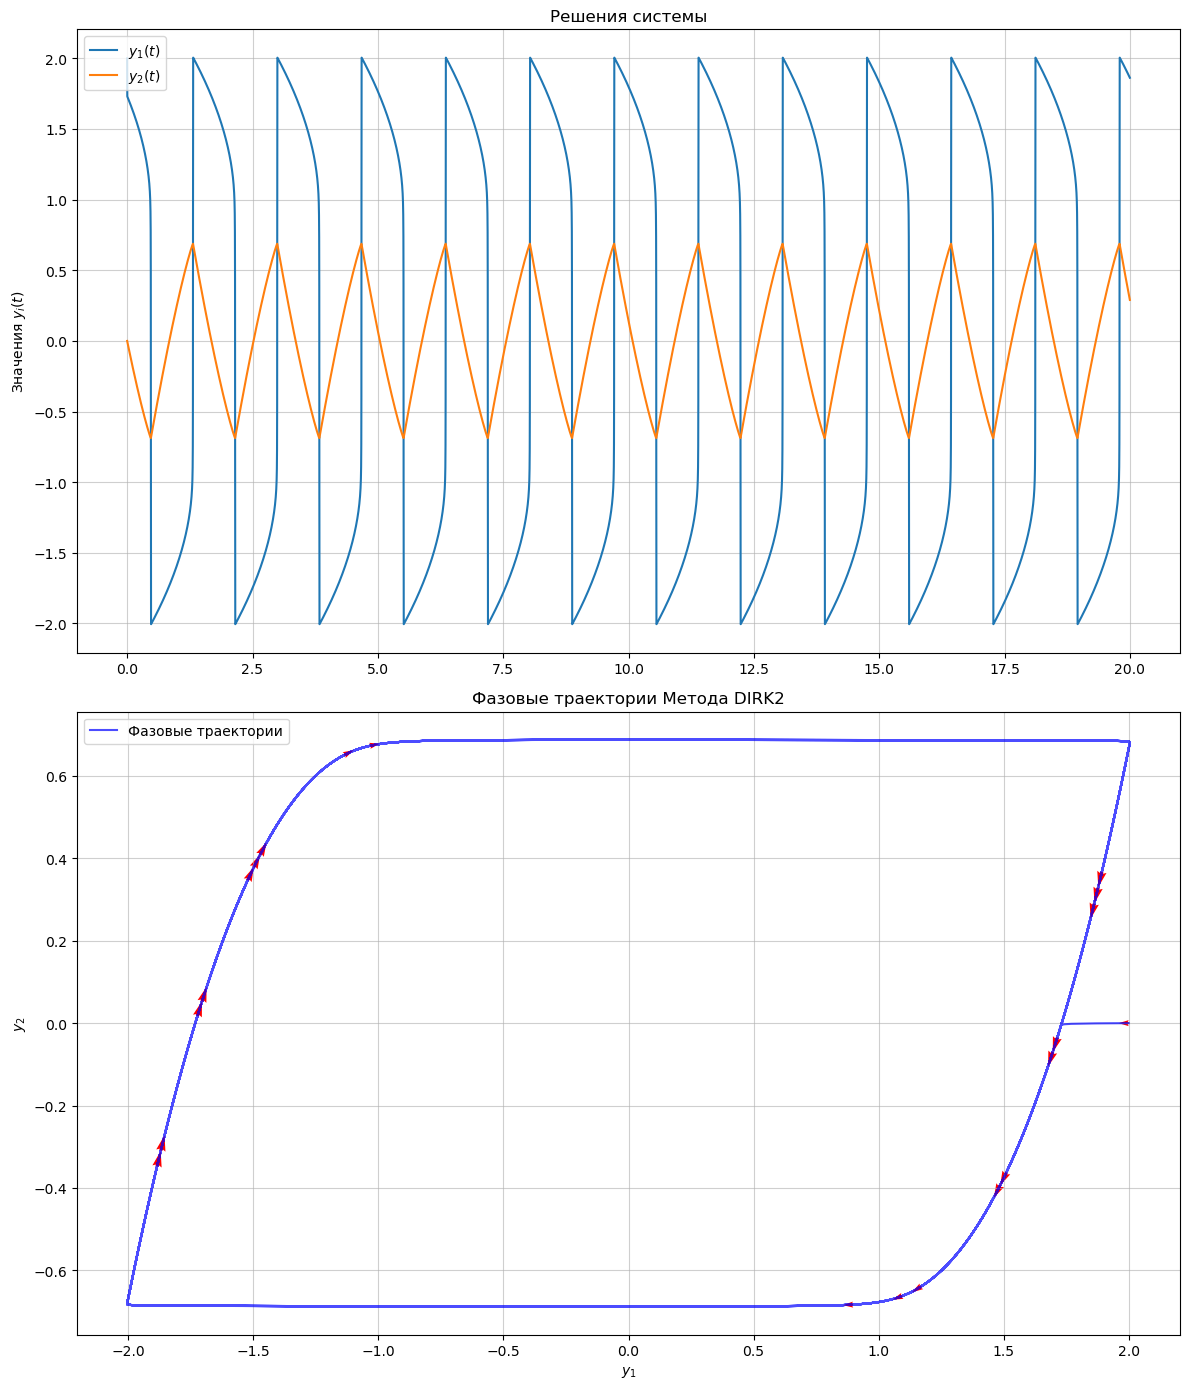

In [98]:
a=1000
A=0
omega=1

# Solve the system
t_drk2, y1_drk2, y2_drk2 = dirk_2(lambda t, y1, y2: f(t, y1, y2, a, A, omega), lambda t, y1, y2: g(t, y1, y2,a, A, omega), t_span=[0.0, 20.0], h=0.0003, y0=[2.0, 0.0], a=1000, A=0, omega=1)

plt.figure(figsize=(12, 14))

# Time evolution
plt.subplot(2, 1, 1)
plt.plot(t_drk2, y1_drk2, label="$y_1(t)$")
plt.plot(t_drk2, y2_drk2, label="$y_2(t)$")
plt.xlabel("")
plt.grid(alpha=0.6)
plt.ylabel(r"Значения $y_i(t)$")
plt.title("Решения системы")
plt.legend()

# Фазовый портрет
plt.subplot(2, 1, 2)
plt.plot(y1_drk2, y2_drk2, label="Фазовые траектории", color="blue", alpha=0.7)

arrow_indices = np.linspace(0, len(y1_drk2) - 1, 20, dtype=int)  
for idx in arrow_indices:
    y1 = y1_drk2[idx]
    y2 = y2_drk2[idx]
    t = t_drk2[idx]
    
    dy1_dt = a * (-((y1**3) / 3 - y1) + y2)
    dy2_dt = -y1 + A * np.cos(omega * t)
    
    magnitude = np.sqrt(dy1_dt**2 + dy2_dt**2)
    if magnitude > 0:  
        dy1_dt /= magnitude
        dy2_dt /= magnitude
    
    plt.quiver(y1, y2, dy1_dt, dy2_dt, color="red", angles='xy', scale_units='xy', scale=25, width=0.008)

plt.grid(alpha=0.6)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Фазовые траектории Метода DIRK2")
plt.legend()
plt.tight_layout()
plt.show()

Видно, что данный метод также не даёт осцилляций при приближении к участку со занчительно более быстрым характерным временем:

### Методы Рунге-Кутты №3

Исправленная таблица Бутчера для третьего метода:
\begin{matrix}
\frac{3+\sqrt{3}}6 & \frac{3+\sqrt{3}}{6} & 0 \\
\frac{3-\sqrt{3}}6 & -\frac{\sqrt{3}}3 & \frac{3+\sqrt{3}}{6} \\
\\
\hline
\\
&\frac 12 & \frac 12
\end{matrix}

Проверим условия порядков: 
- Для первого порядка:$\sum\limits_{i}b_i = 1$ 
- Для второго поядка:$\sum\limits_{i}b_ic_i = \frac 12$ 
- Для третьего порядка:
\begin{cases}
    \sum\limits_{i}b_ic_i^2 = \frac 13 \\
    \sum\limits_{i}b_i\sum\limits_{j}a_{ij}c_j = \frac 16
\end{cases}

In [102]:
b = np.array([1/2, 1/2])
c = np.array([(3+np.sqrt(3))/6, (3-np.sqrt(3))/6])
a = np.array([[(3+np.sqrt(3))/6, 0], [(-np.sqrt(3))/3,(3+np.sqrt(3))/6]])

print(f"""sum(bi) = {b.sum():.3f},
sum(bi*ci) = {b.T@c:.3f},
sum(bi*ci^2) = {(b.T@np.power(c, 2)):.3f},
sum(bi*aij*cj) = {(b.T@a@c):.3f}""")

sum(bi) = 1.000,
sum(bi*ci) = 0.500,
sum(bi*ci^2) = 0.333,
sum(bi*aij*cj) = 0.167


Реализуем данный метод (`DIRK3`):

In [103]:
def dirk_3(f, g, t_span, h, y0, a, A, omega):
    
    a11 = (3 + np.sqrt(3)) / 6
    a21 = -np.sqrt(3)/3
    a22 = (3 + np.sqrt(3)) / 6
    b1 = 0.5
    b2 = 0.5
    c1 = (3 + np.sqrt(3)) / 6
    c2 = (3 - np.sqrt(3)) / 6
    
    t0, tf = t_span
    
    n = int((tf - t0) / h)
    
    
    t_values = np.linspace(t0, tf, n + 1)
    y1_values = np.zeros(n + 1)
    y2_values = np.zeros(n + 1)
    
    
    y1_values[0] = y0[0]
    y2_values[0] = y0[1]
    
    
    def implicit_stage(k, t, y1, y2, stage):
        if stage == 1:
            tn = t + c1 * h
            y1n = y1 + h * (a11 * k[0])
            y2n = y2 + h * (a11 * k[1])
        elif stage == 2:
            tn = t + c2 * h
            y1n = y1 + h * (a21 * k_prev[0] + a22 * k[0])
            y2n = y2 + h * (a21 * k_prev[1] + a22 * k[1])
        
        
        res1 = k[0] - f(tn, y1n, y2n)
        res2 = k[1] - g(tn, y1n, y2n)
        return [res1, res2]
    
    
    for i in range(n):
        t = t_values[i]
        y1 = y1_values[i]
        y2 = y2_values[i]
        
        # Stage 1
        k1_guess = [f(t + c1 * h, y1, y2), g(t + c1 * h, y1, y2)]
        sol1 = root(lambda k: implicit_stage(k, t, y1, y2, stage=1), k1_guess)
        k1 = sol1.x
        
        # Stage 2
        k_prev = k1  
        k2_guess = [f(t + c2 * h, y1, y2), g(t + c2 * h, y1, y2)]
        sol2 = root(lambda k: implicit_stage(k, t, y1, y2, stage=2), k2_guess)
        k2 = sol2.x
        
        
        y1_values[i + 1] = y1 + h * (b1 * k1[0] + b2 * k2[0])
        y2_values[i + 1] = y2 + h * (b1 * k1[1] + b2 * k2[1])
    
    return t_values, y1_values, y2_values

Построим решения полученные неявным методом РК №3

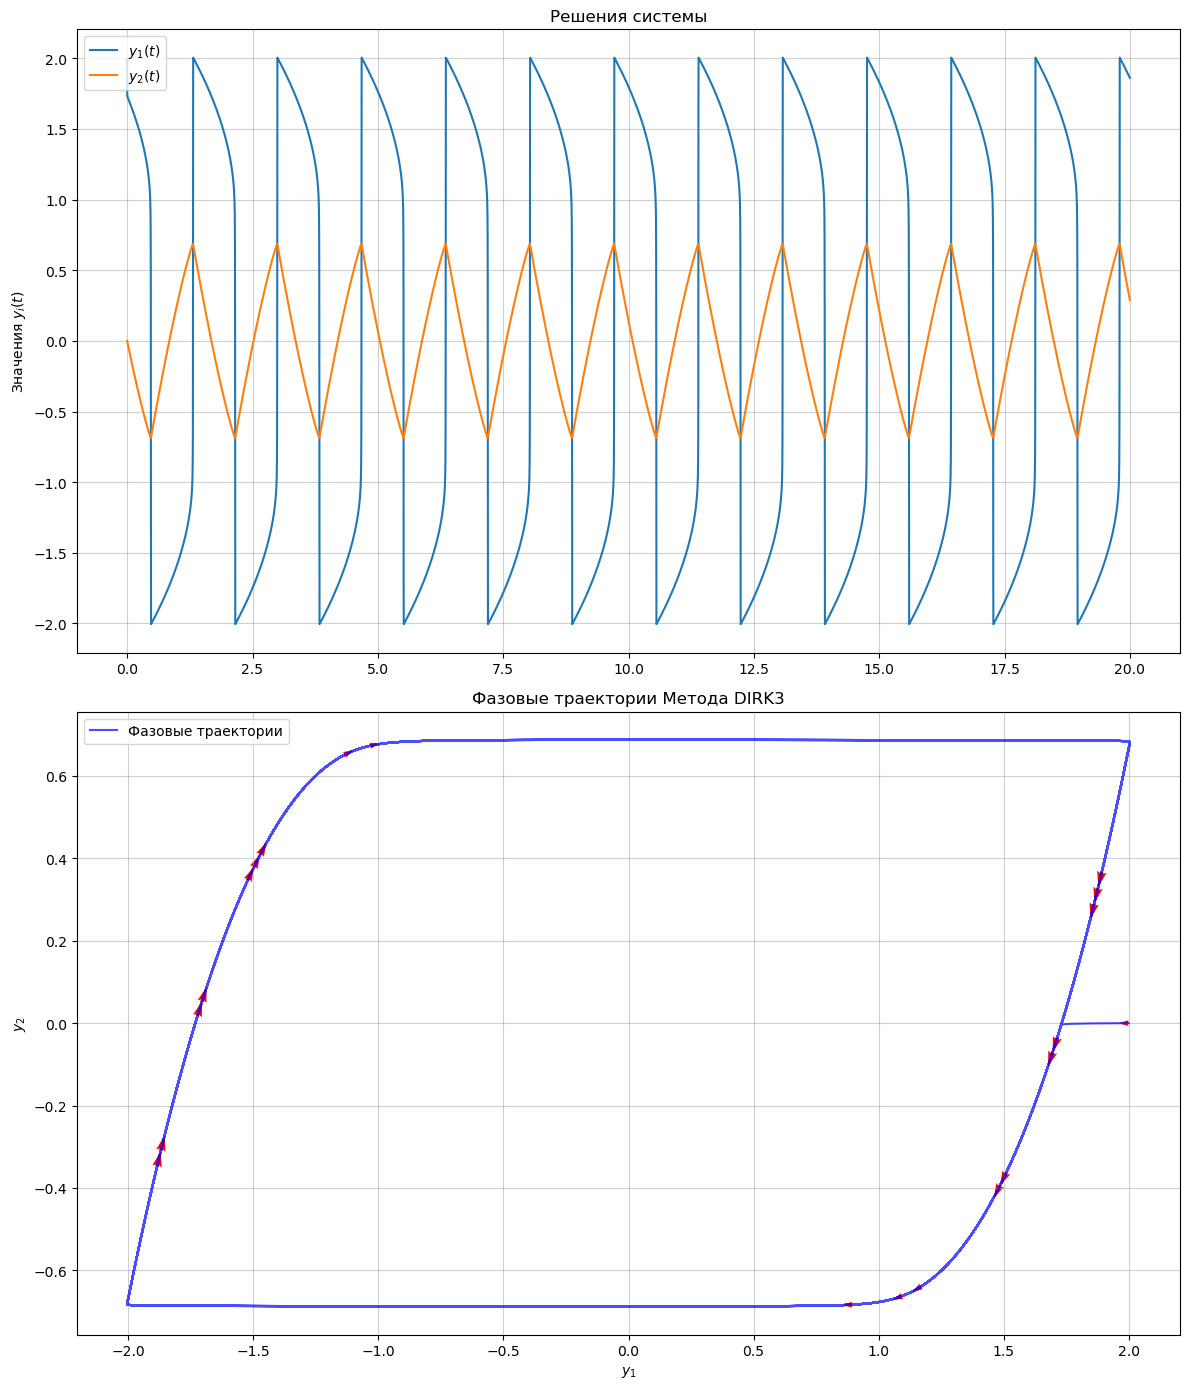

In [196]:
a=1000
A=0
omega=1

# Solve the system
t_drk3, y1_drk3, y2_drk3 = dirk_3(lambda t, y1, y2: f(t, y1, y2, a, A, omega), lambda t, y1, y2: g(t, y1, y2, a, A, omega), t_span=[0.0, 20.0], h=0.0003, y0=[2.0, 0.0], a=1000, A=0, omega=1)

plt.figure(figsize=(12, 14))

# Time evolution
plt.subplot(2, 1, 1)
plt.plot(t_drk3, y1_drk3, label="$y_1(t)$")
plt.plot(t_drk3, y2_drk3, label="$y_2(t)$")
plt.xlabel("")
plt.grid(alpha=0.6)
plt.ylabel(r"Значения $y_i(t)$")
plt.title("Решения системы")
plt.legend()

# Фазовый портрет
plt.subplot(2, 1, 2)
plt.plot(y1_drk3, y2_drk3, label="Фазовые траектории", color="blue", alpha=0.7)

arrow_indices = np.linspace(0, len(y1_drk3) - 1, 20, dtype=int)  
for idx in arrow_indices:
    y1 = y1_drk3[idx]
    y2 = y2_drk3[idx]
    t = t_drk3[idx]
    
    dy1_dt = a * (-((y1**3) / 3 - y1) + y2)
    dy2_dt = -y1 + A * np.cos(omega * t)
    
    magnitude = np.sqrt(dy1_dt**2 + dy2_dt**2)
    if magnitude > 0:  
        dy1_dt /= magnitude
        dy2_dt /= magnitude
    
    plt.quiver(y1, y2, dy1_dt, dy2_dt, color="red", angles='xy', scale_units='xy', scale=25, width=0.008)

plt.grid(alpha=0.6)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Фазовые траектории Метода DIRK3")
plt.legend()
plt.tight_layout()
plt.show()

Как видно исходя из полученных графиков, данный метод также хорошо решает автономную систему.

Сравним все полученные численные решения с методом ФДН:

### Метод ФДН:

В качестве эталонного метода решения данной задачи авторами был предложен метод ФДН:
$$
k=2;~~~~\frac32y_{n+1} - 2y_n+\frac12y_{n-1} = h f_{n+1}
$$

Реализуем его

In [105]:
def fdn(a, A, omega, t0, tf, h, y1_0, y2_0):
    
    n = int((tf - t0) / h)

    t_values = np.linspace(t0, tf, n + 1)
    y1_values = np.zeros(n + 1)
    y2_values = np.zeros(n + 1)
    
    y1_values[0] = y1_0
    y2_values[0] = y2_0
    
    y1_values[1] = y1_values[0] + h * a * (-((y1_values[0]**3) / 3 - y1_values[0]) + y2_values[0])
    y2_values[1] = y2_values[0] + h * (-y1_values[0] + A * np.cos(omega * t_values[0]))
    
    for i in range(1, n):
        t = t_values[i]
        
        f1 = a * (-((y1_values[i]**3) / 3 - y1_values[i]) + y2_values[i])
        f2 = -y1_values[i] + A * np.cos(omega * t)
        
        y1_values[i + 1] = (4 * y1_values[i] - y1_values[i - 1] + 2 * h * f1) / 3
        y2_values[i + 1] = (4 * y2_values[i] - y2_values[i - 1] + 2 * h * f2) / 3
    
    return t_values, y1_values, y2_values

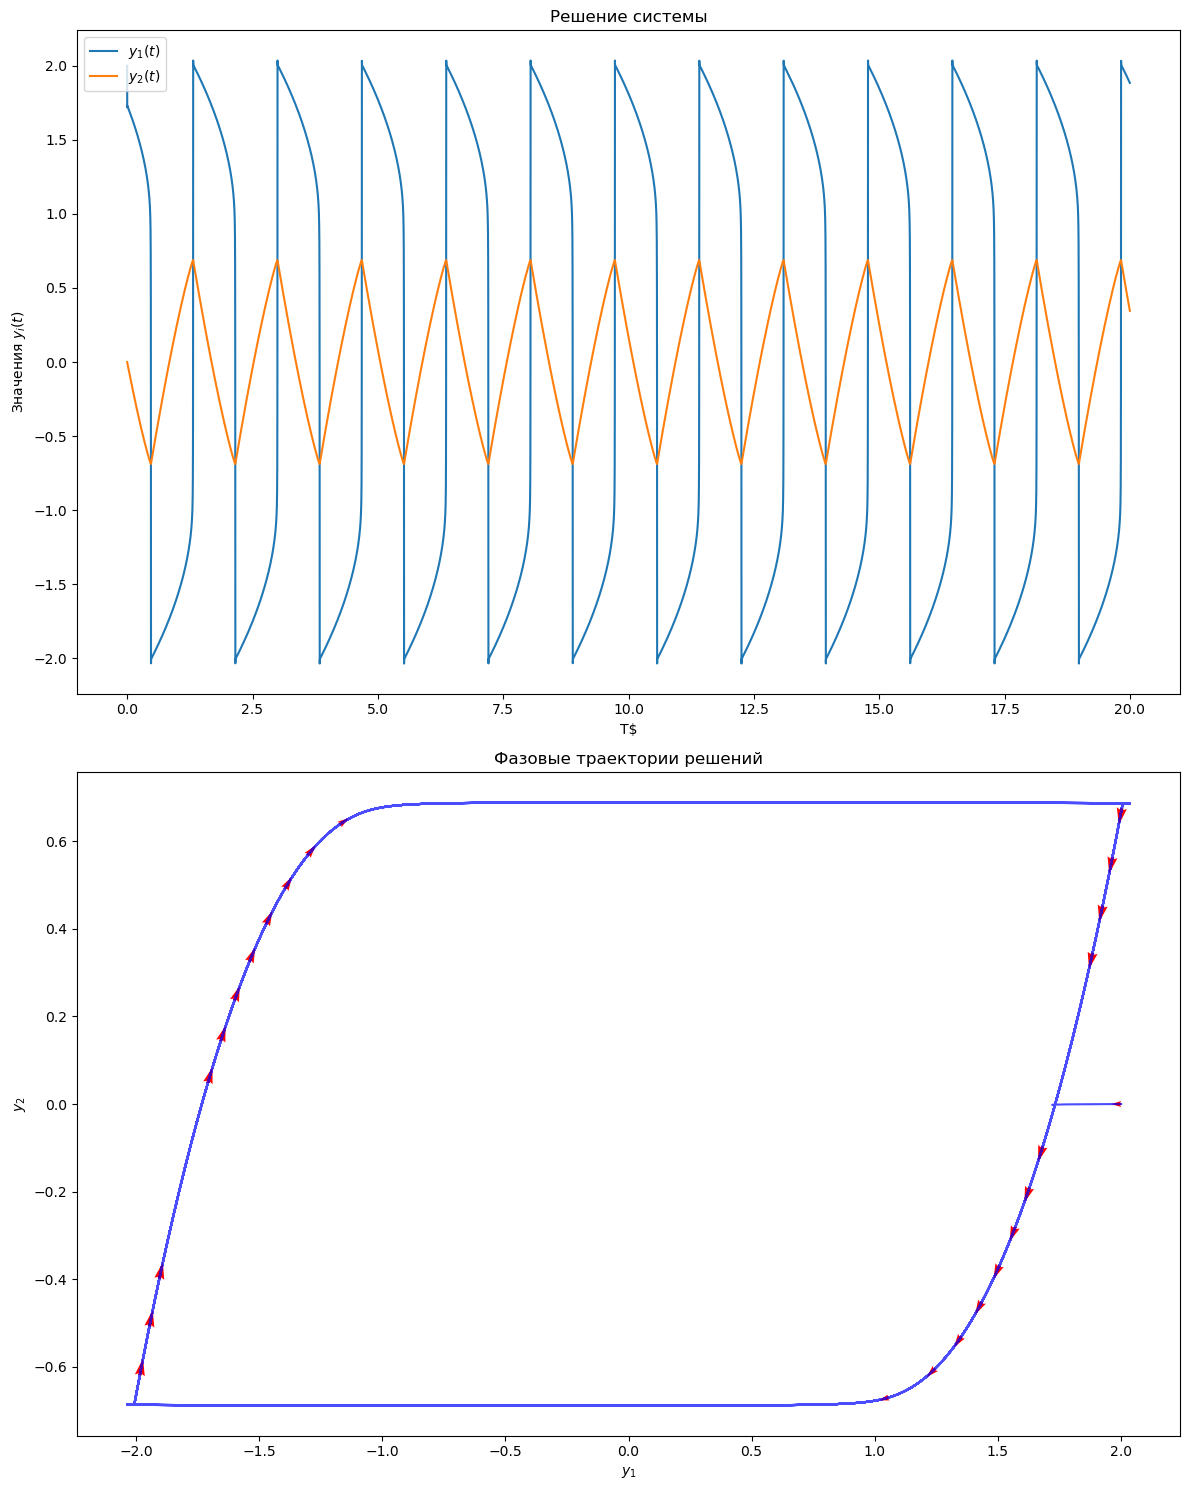

In [ ]:
t_fdn, y1_fdn, y2_fdn = fdn(a=1000, A=0, omega=1, t0=0.0, tf=20.0, h=0.0002, y1_0=2.0, y2_0=0.0)

plt.figure(figsize=(12, 15))
plt.subplot(2, 1, 1)
plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
plt.xlabel("T$")
plt.ylabel(r"Значения $y_i(t)$")
plt.title("Решение системы")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)

arrow_indices = np.linspace(0, len(y1_fdn) - 1, 24, dtype=int) 
for idx in arrow_indices:
    y1 = y1_fdn[idx]
    y2 = y2_fdn[idx]
    t = t_fdn[idx]
    
    dy1_dt = a * (-((y1**3) / 3 - y1) + y2)
    dy2_dt = -y1 + A * np.cos(omega * t)
    
    magnitude = np.sqrt(dy1_dt**2 + dy2_dt**2)
    if magnitude > 0:  # Avoid division by zero
        dy1_dt /= magnitude
        dy2_dt /= magnitude
    
    # Plot the arrow
    plt.quiver(y1, y2, dy1_dt, dy2_dt, color="red", angles='xy', scale_units='xy', scale=25, width=0.008)

plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Фазовые траектории решений")
plt.tight_layout()
plt.show()

Как видно на полученных графиках, метод ФДН справляется с решением также хорошо, как и неявные методы РК (при переходе на часть траектории с быстрым характреным аременем наблюдаюся совсем незначительные отклонения).

**При этом значительным плюсом данного метода явлвяется вычислительная сложность (не требуется решения нелинейных уравнений как для методов РК), таким образом он работает быстрее**

### Вариация параметров (решение неавтономной задачи):

Попробуем теперь построить решения для неавтономной задачи с амплитудой $A=0.5$: $0<A<1$ разными методами при различных значениях частоты вынужденных колебаний $\omega$

Начнём с метода ФДН:

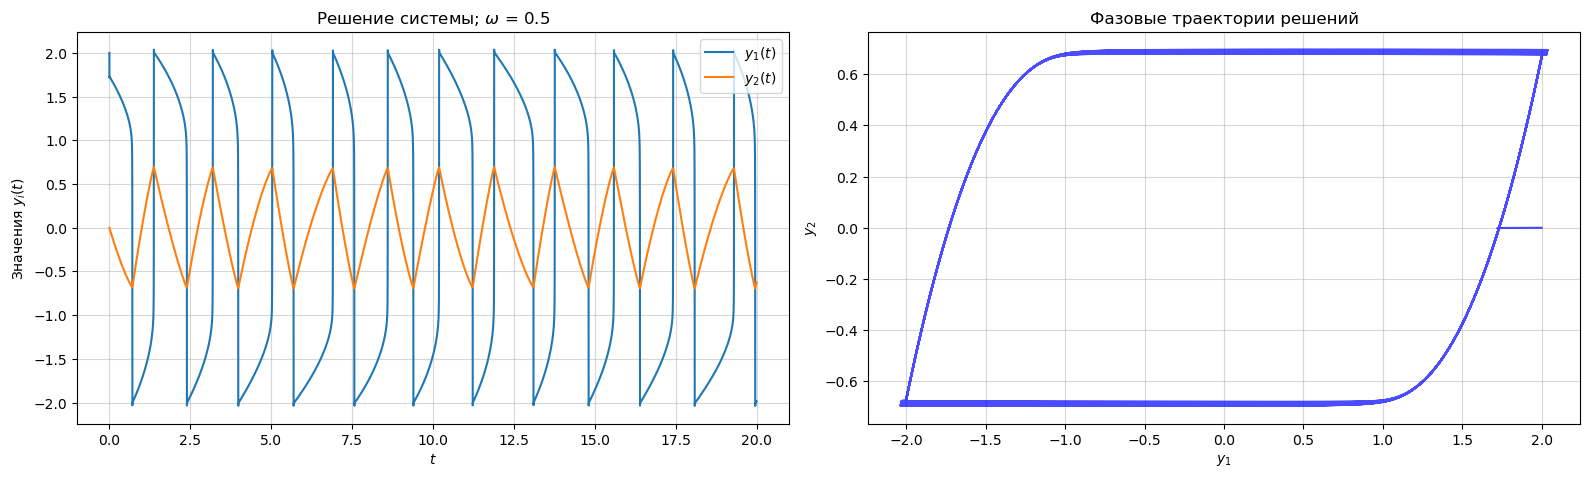

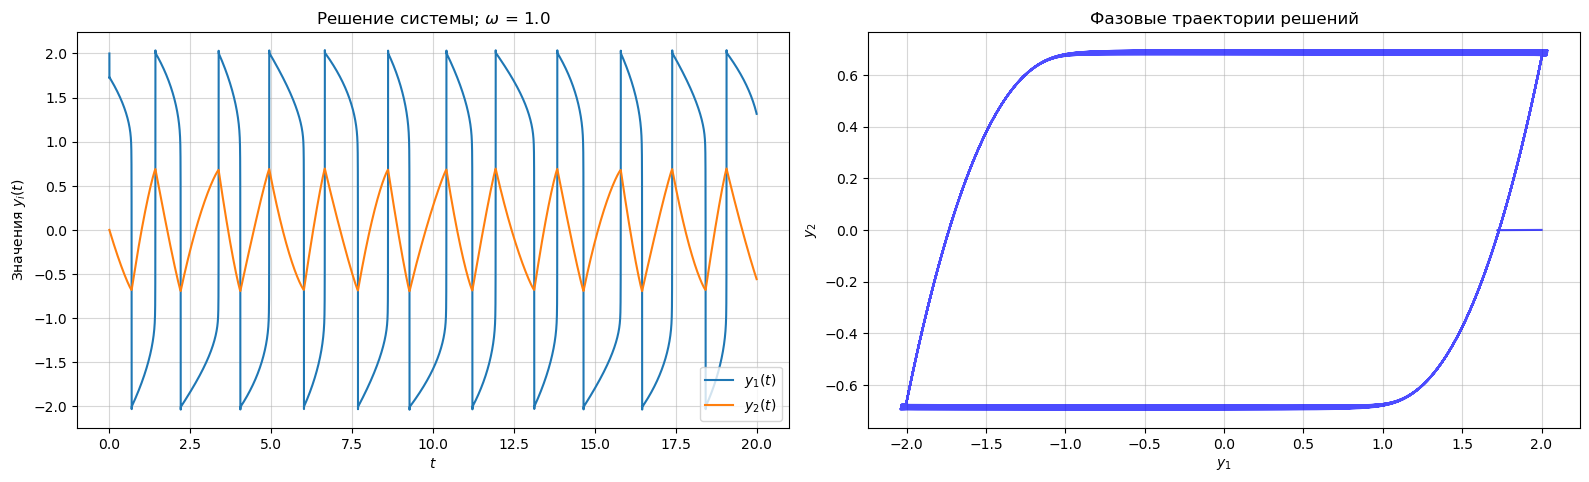

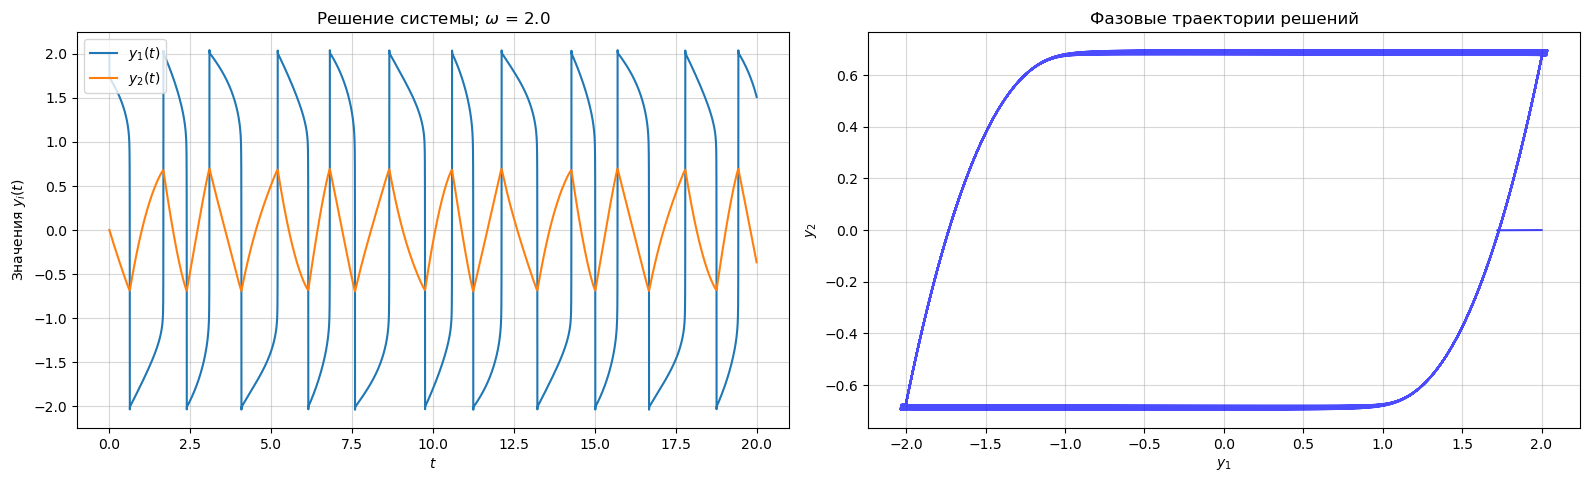

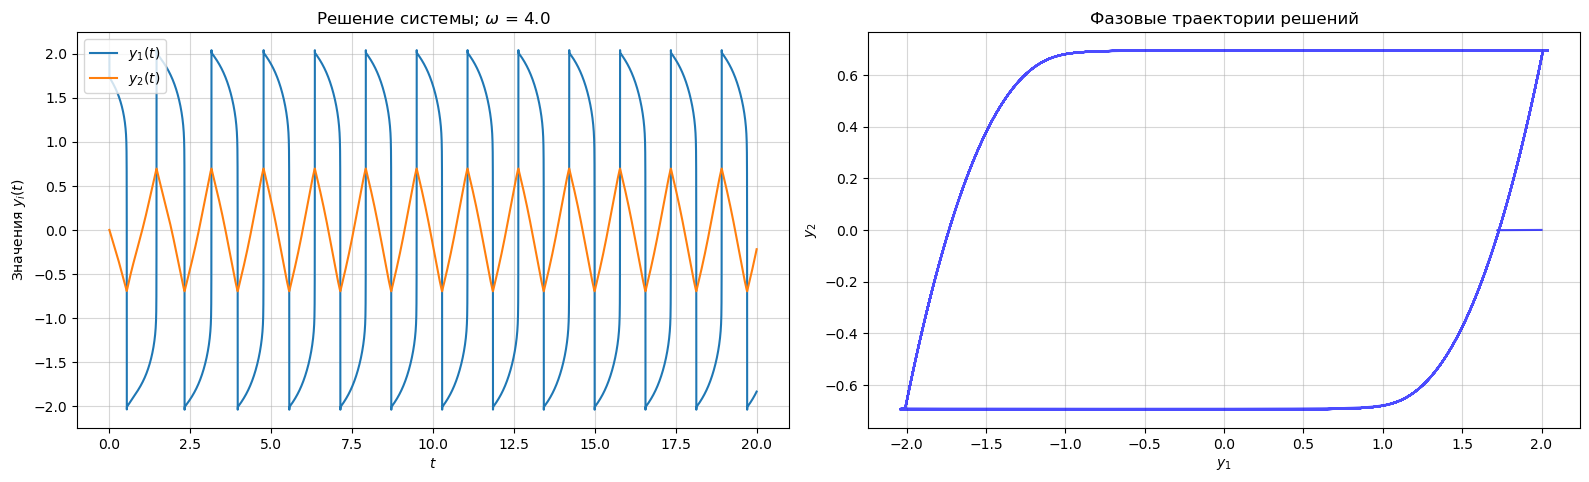

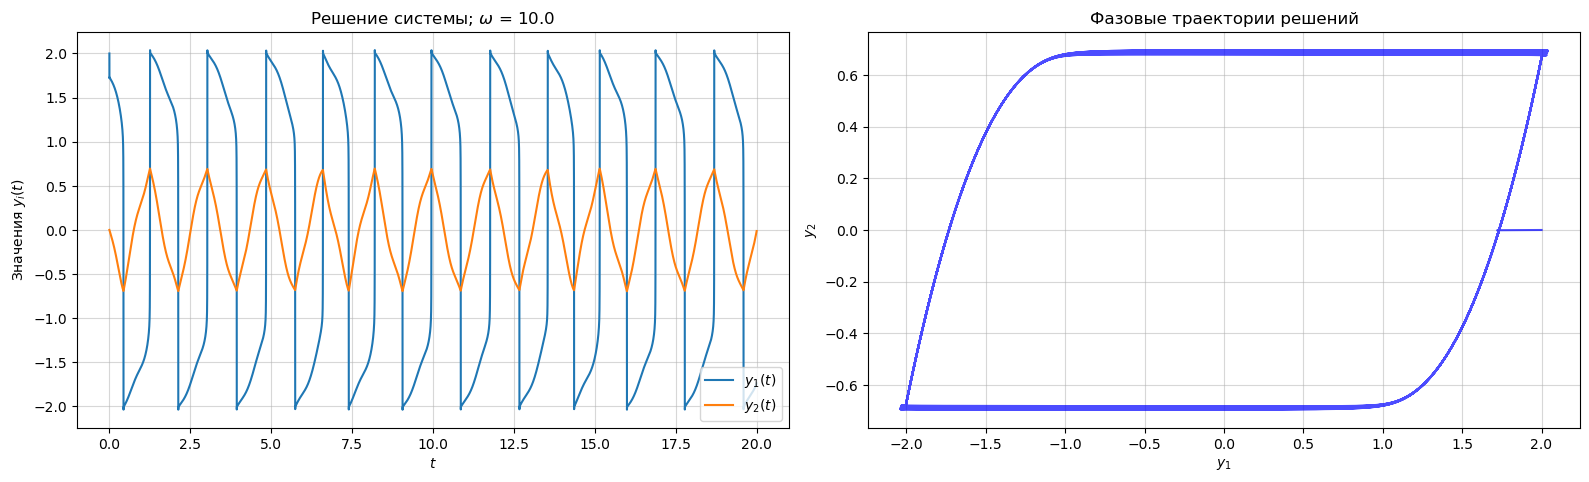

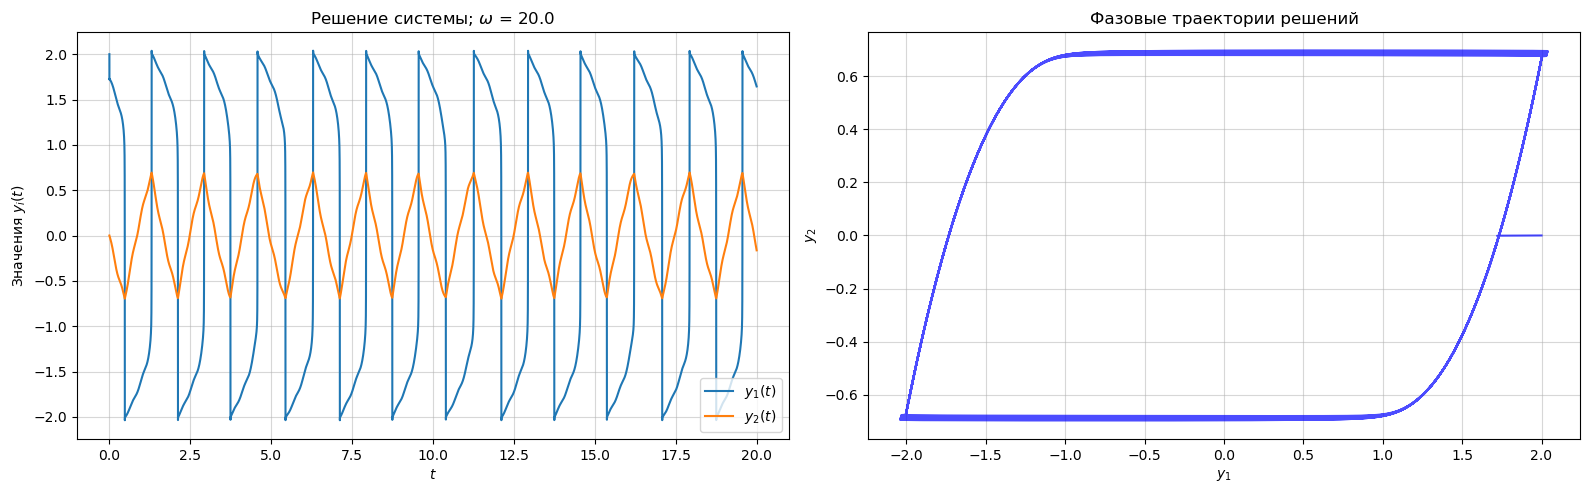

In [144]:
omega_values = [0.5, 1, 2, 4, 10, 20]

A=0.5
a=1000

for j, omega in enumerate(omega_values):
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=20.0, h=0.0002, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 27))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.1f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

Видно, что при включении неавтономной части и значительном различии собственной частоты с частотой вынужденных колебаний решение перестаёт быть строго периодическим и на фазовой плоскости появляются уширения при прохождении части с быстрым характерным временем.

Наибольшая апериодичность в решениях будет возникать при частоте выножденных колебаний $\omega$ близкой к полуцелым значениям собственной частоты $\Omega$

Интересно исследовать поведение системы при частоте $\omega$ вынужленных колебаний близкой к собственной частоте осциллятора Ван-дер-Поля, то есть `в резонансе`. Собственная частота: $\Omega = \frac{2\pi}{\tau}\approx3.5$ Исследуем решения метода ФДН:

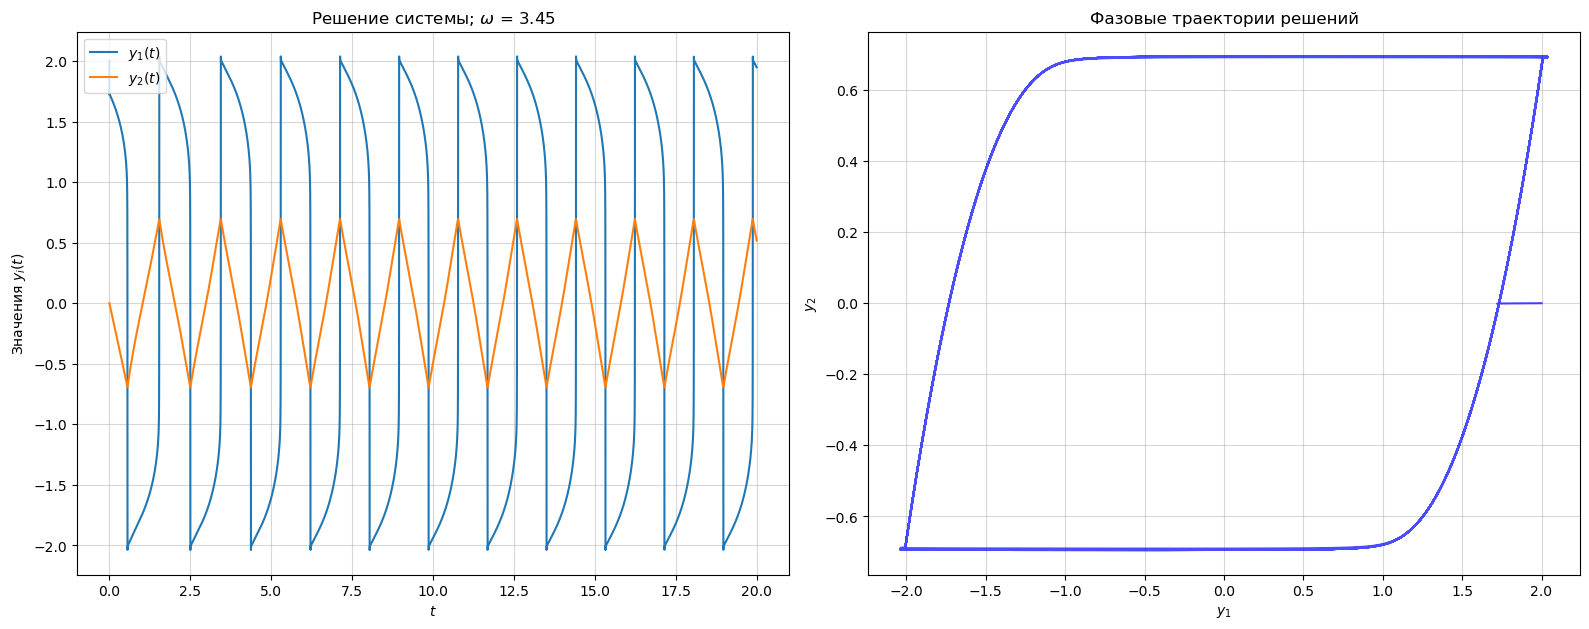

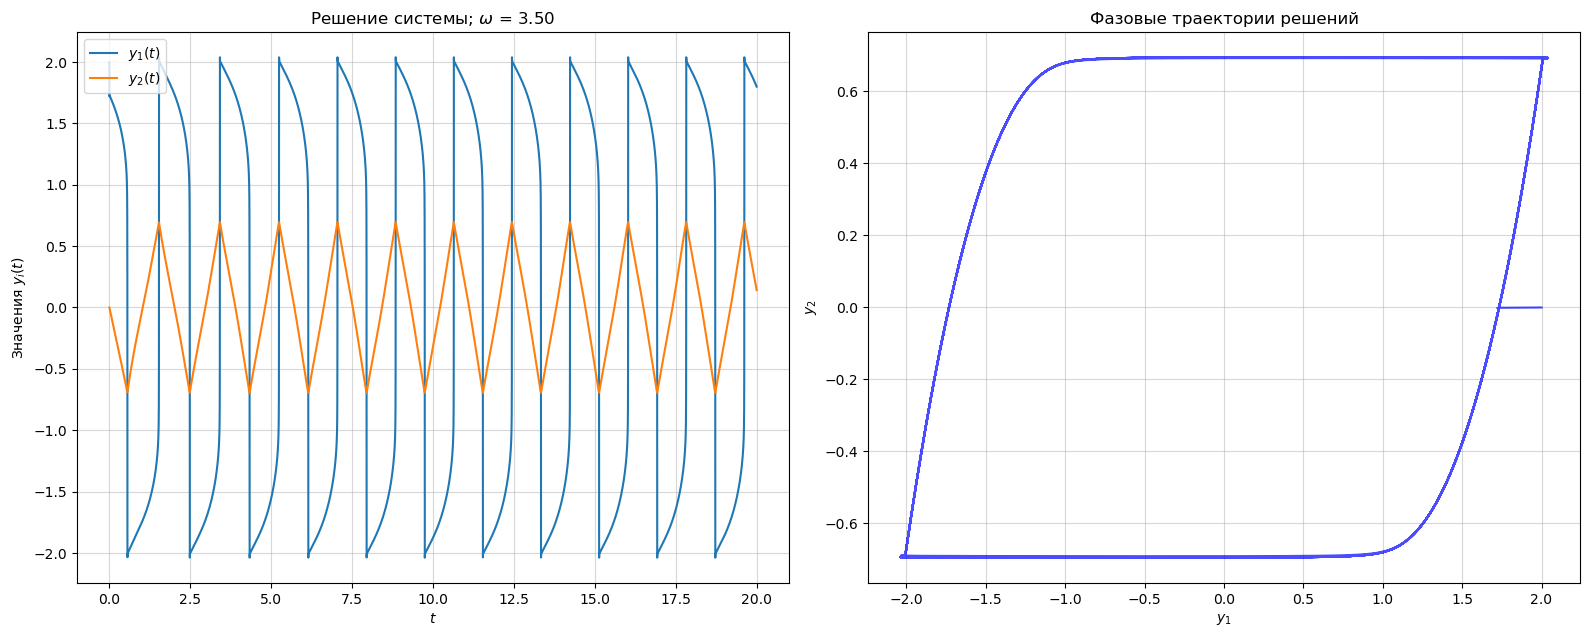

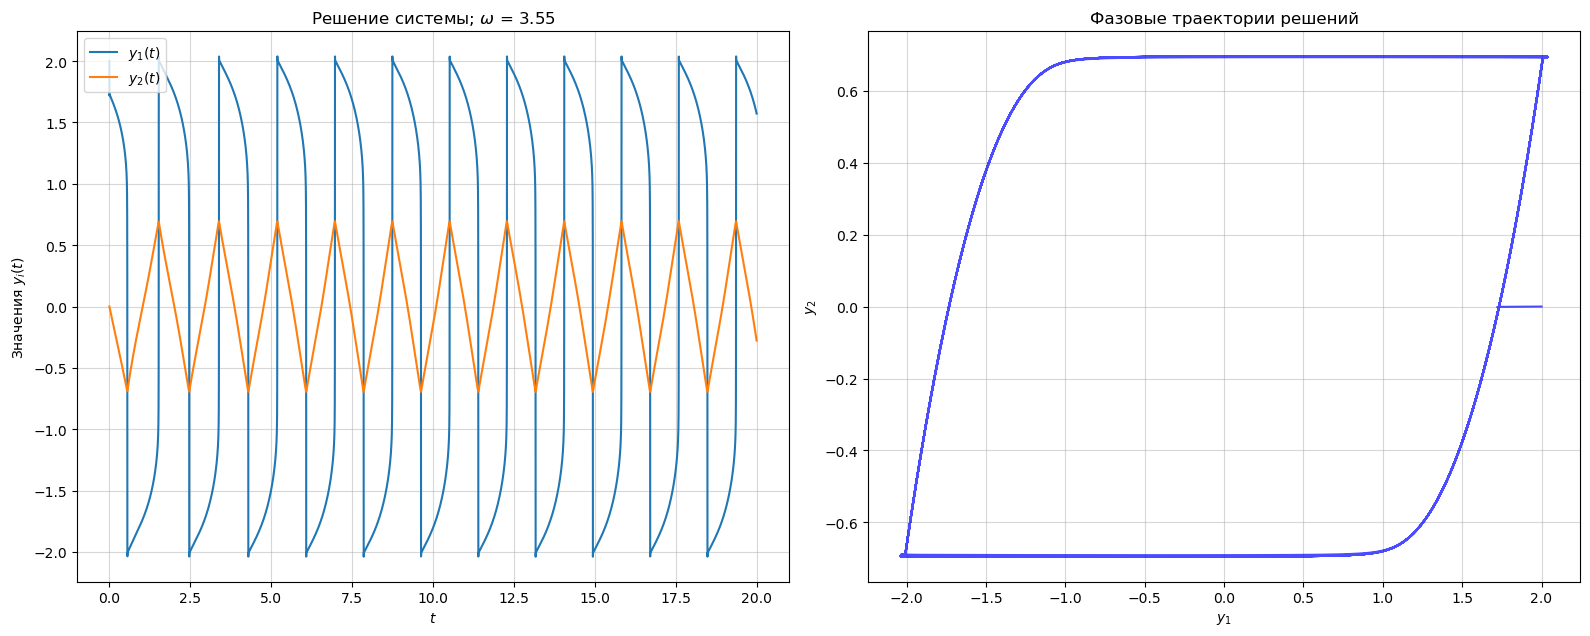

In [151]:
omega_values = np.linspace(3.45, 3.55, 3)

A=0.5
a=1000

for j, omega in enumerate(omega_values):
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=20.0, h=0.0002, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 18))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.2f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

Видно, что полученные резонансные решения почти не отличаются от автономных решений, что является характерной особенностью данной задачи. Попробуем уменьшить жёсткость задачи (положим $a=20$) и посмотреть на изменения в резонансе. Однако при изменении жёсткости меняется собственная частота $\Omega$ и её надо немного подкорректировать

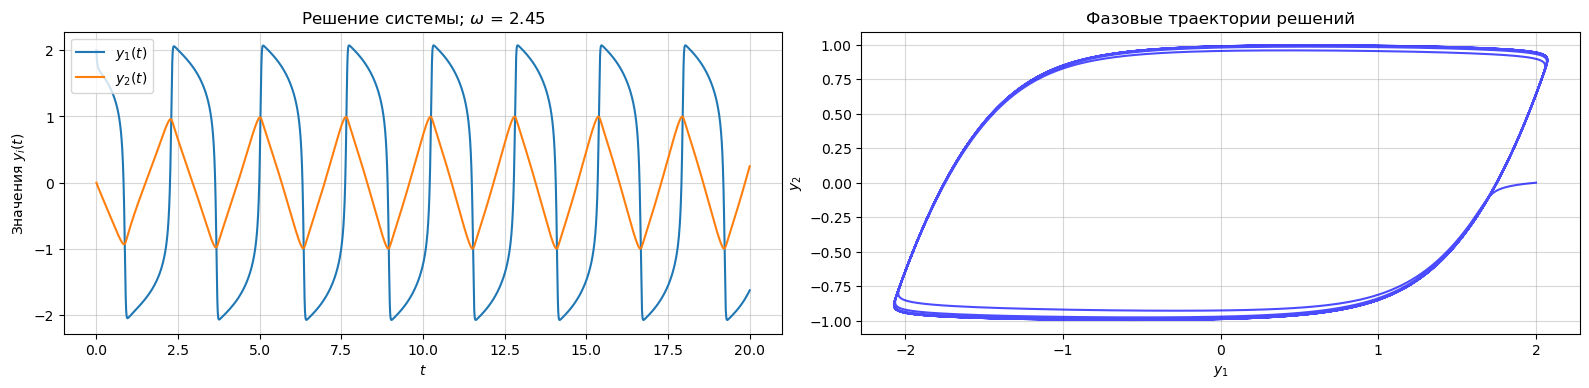

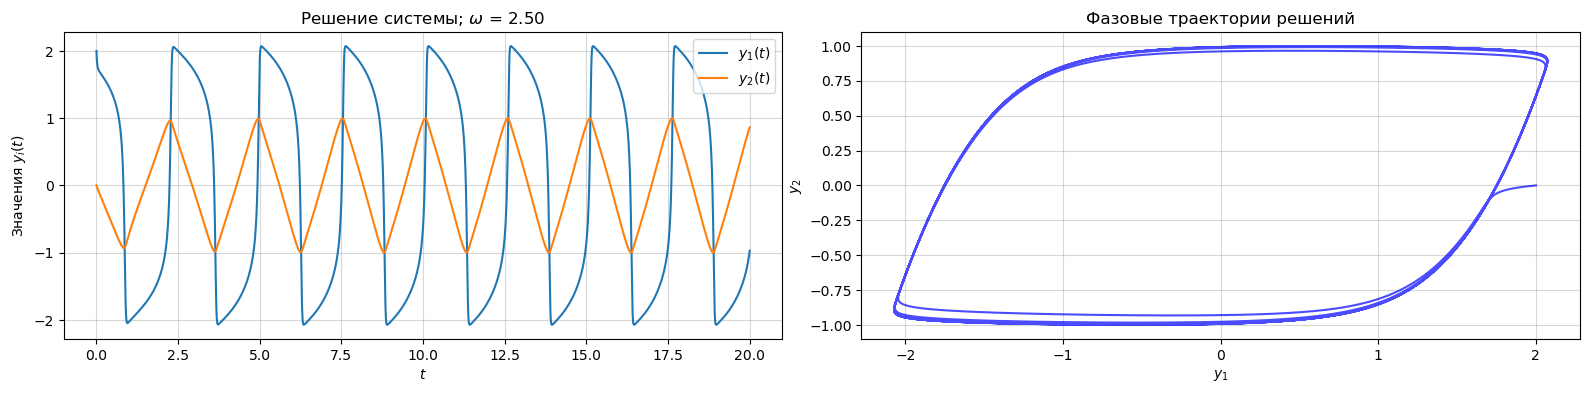

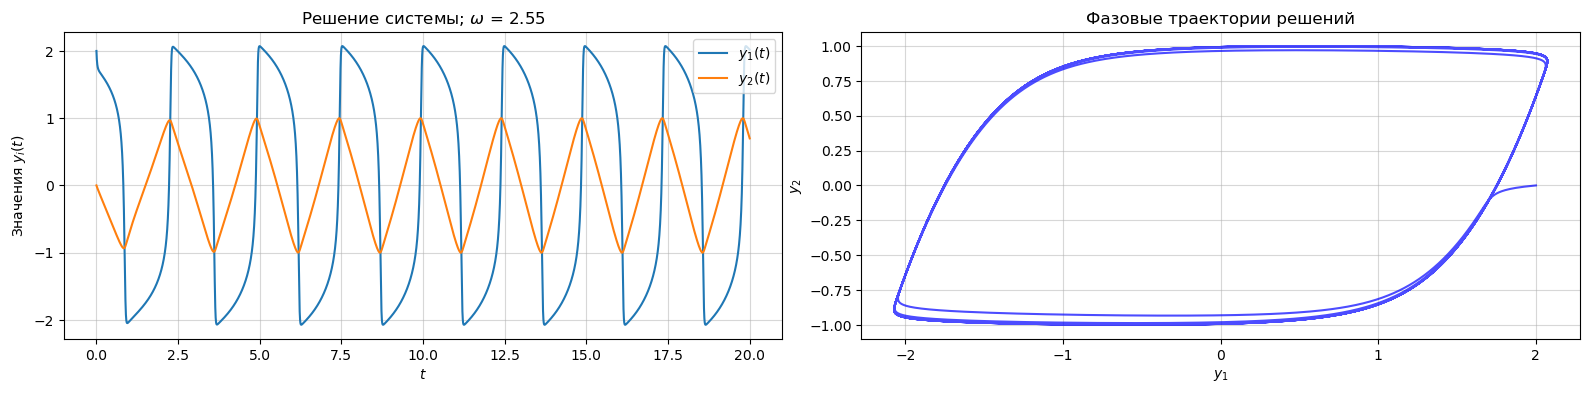

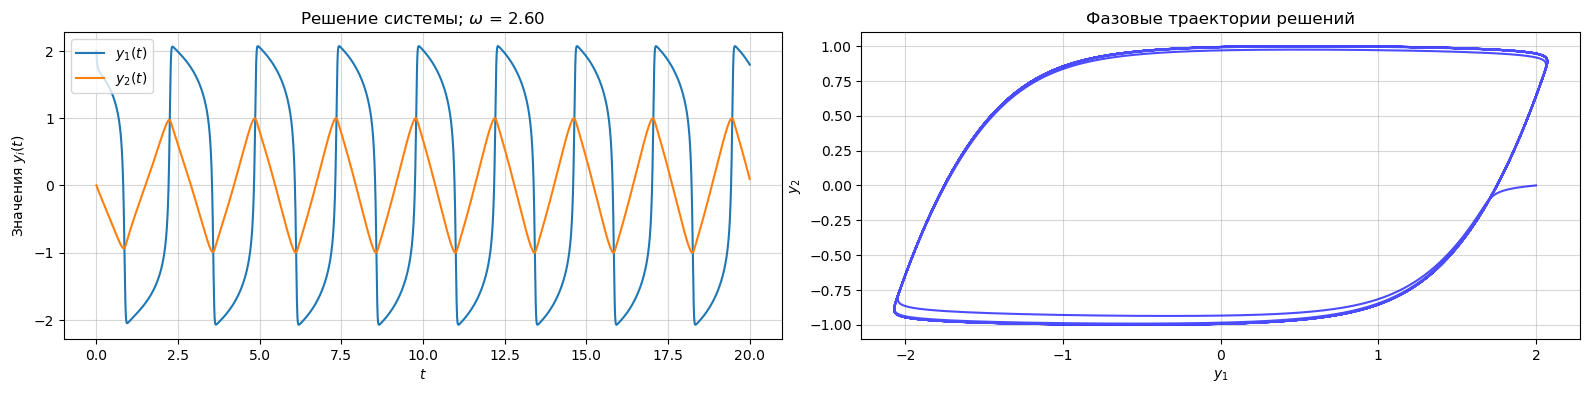

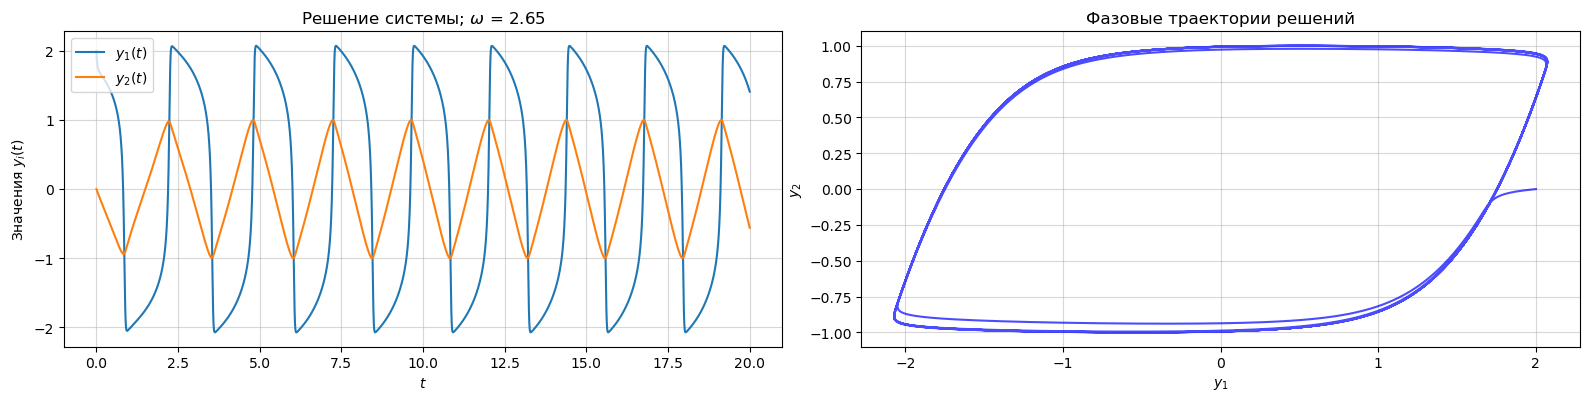

In [183]:
omega_values = np.linspace(2.45, 2.65, 5)

A=0.5
a=20

for j, omega in enumerate(omega_values):
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=20.0, h=0.002, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 18))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.2f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

Опять же видим, что решения являются периодеческими и не отличаются от автономных. Мы находимся в резонансе, но "раскачки" колебаний не происходит, для этого ампилитуда вынуждающей силы должна быть много больше 1, что является спецификой осциллятора Ван-дер-Поля.

Попробуем построить решения в широком диапазоне $\omega$ c той же амплитудой $A=0.5$; $a=1000$ для других методов (`CROS` и  `DIRK3`):

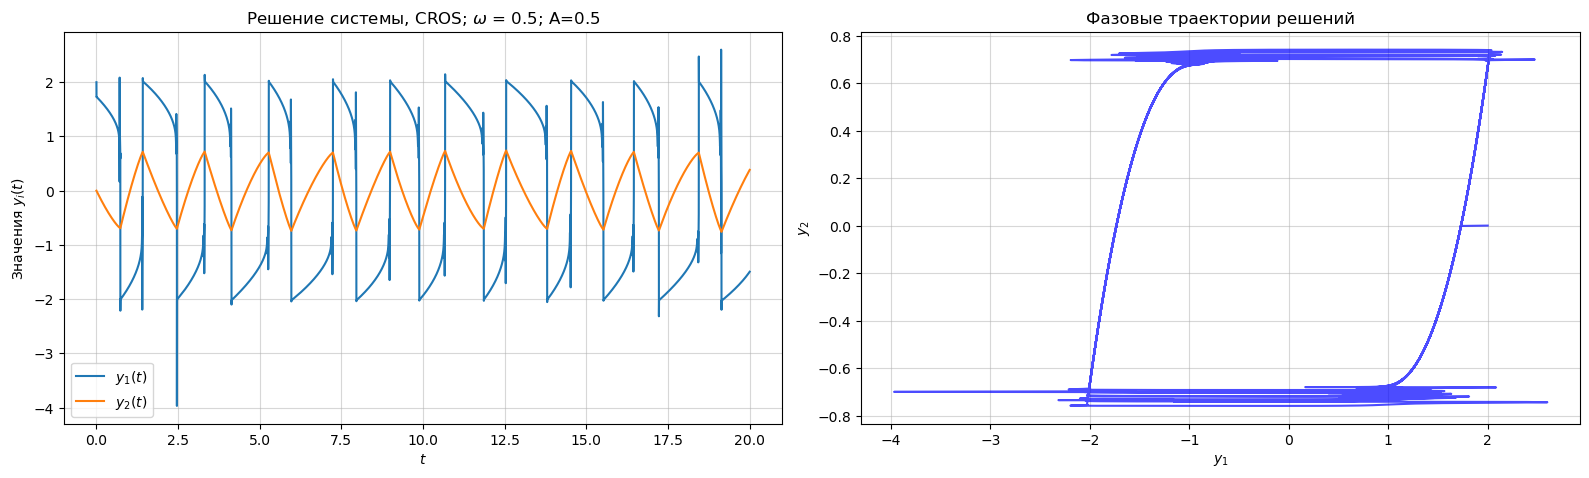

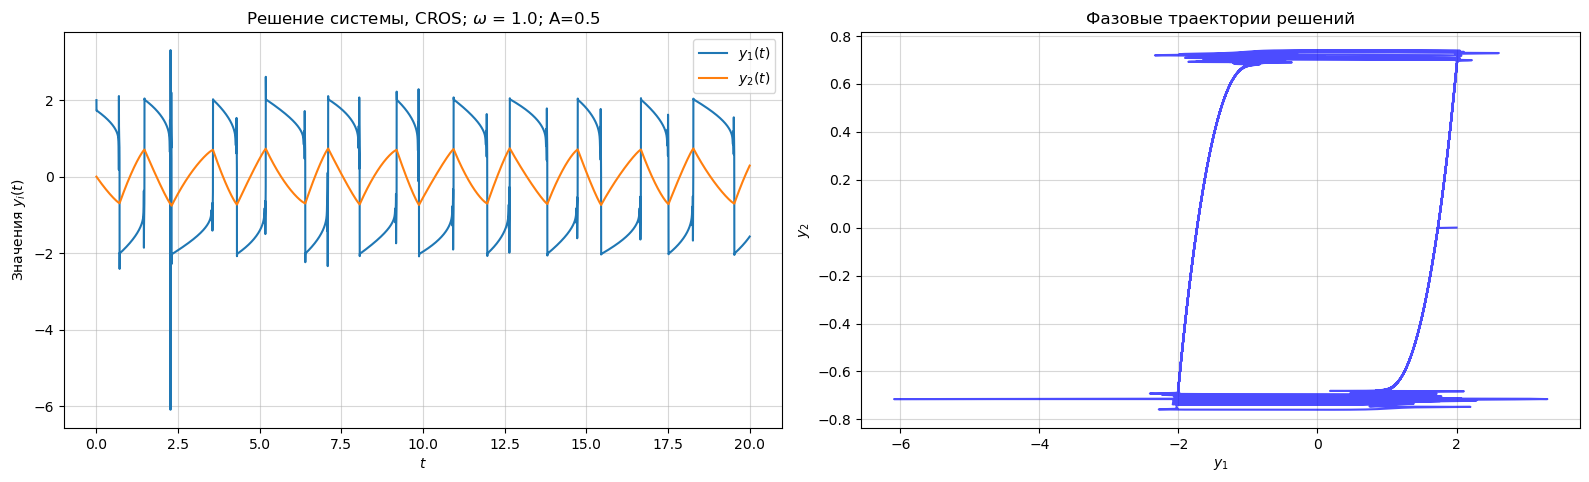

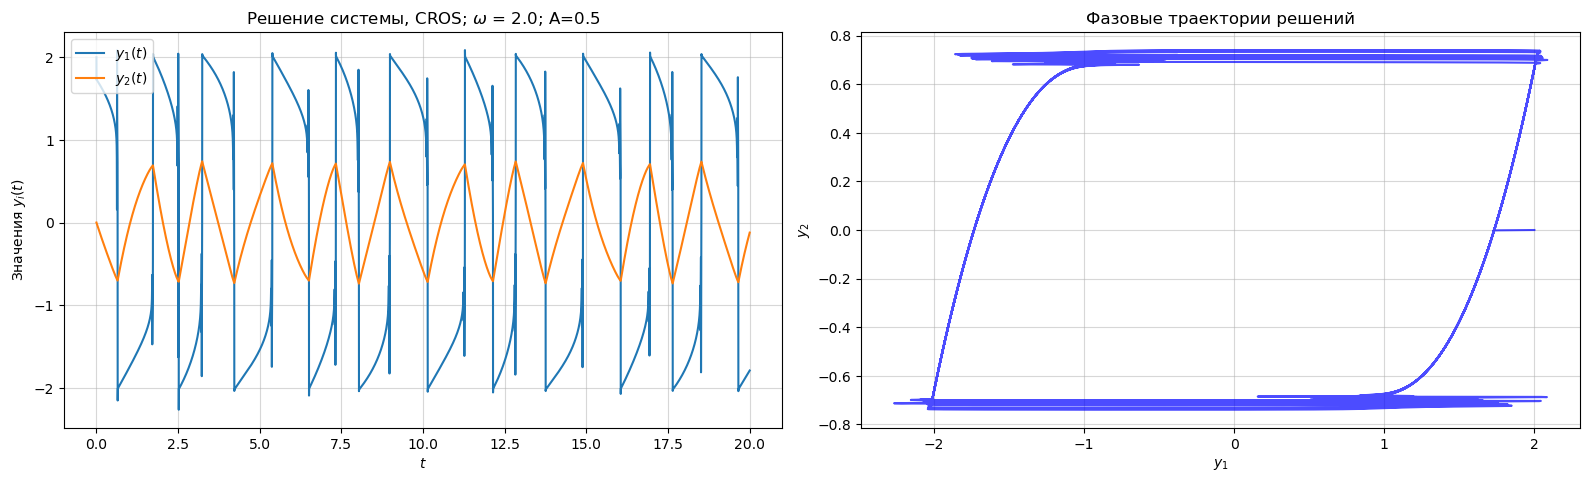

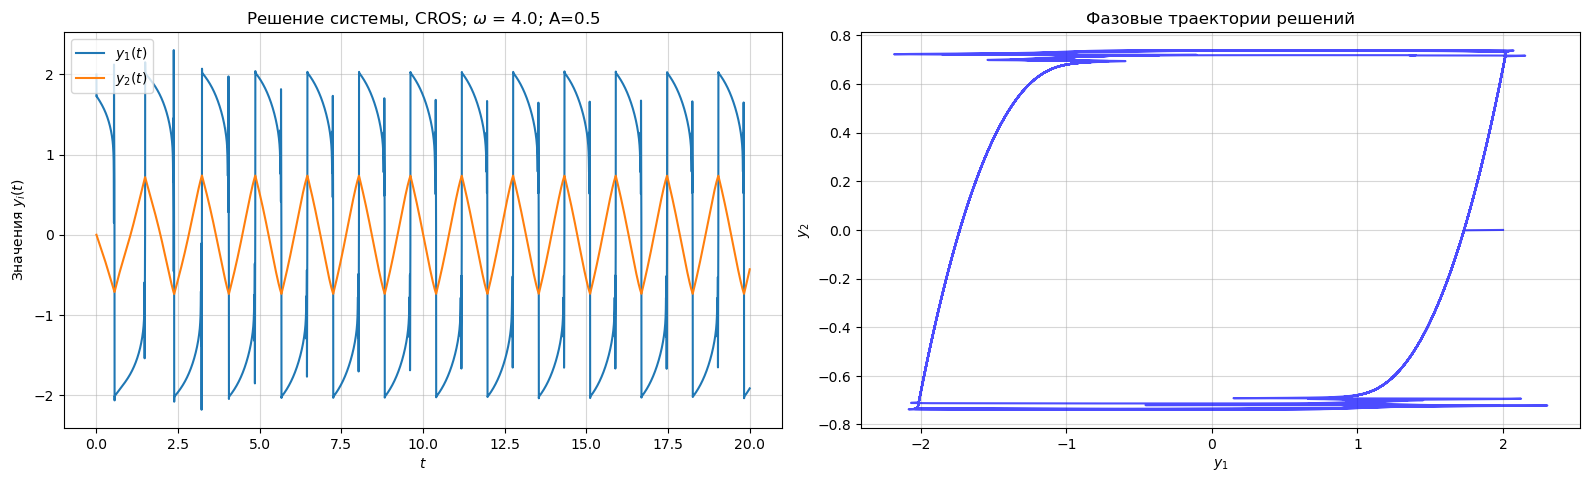

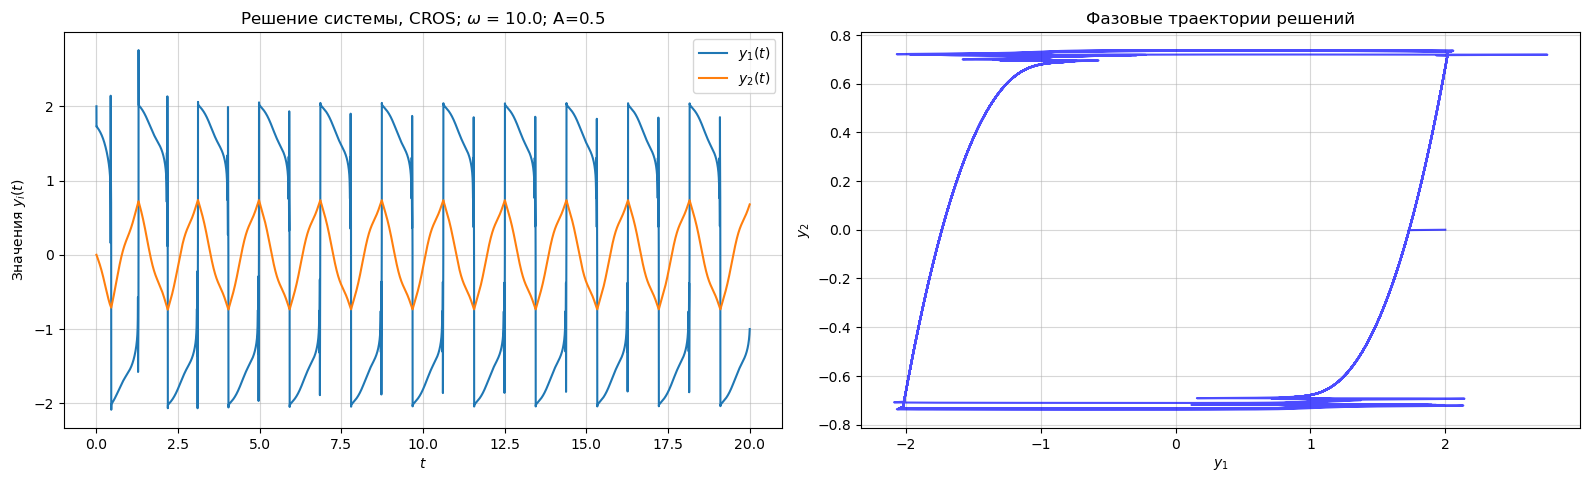

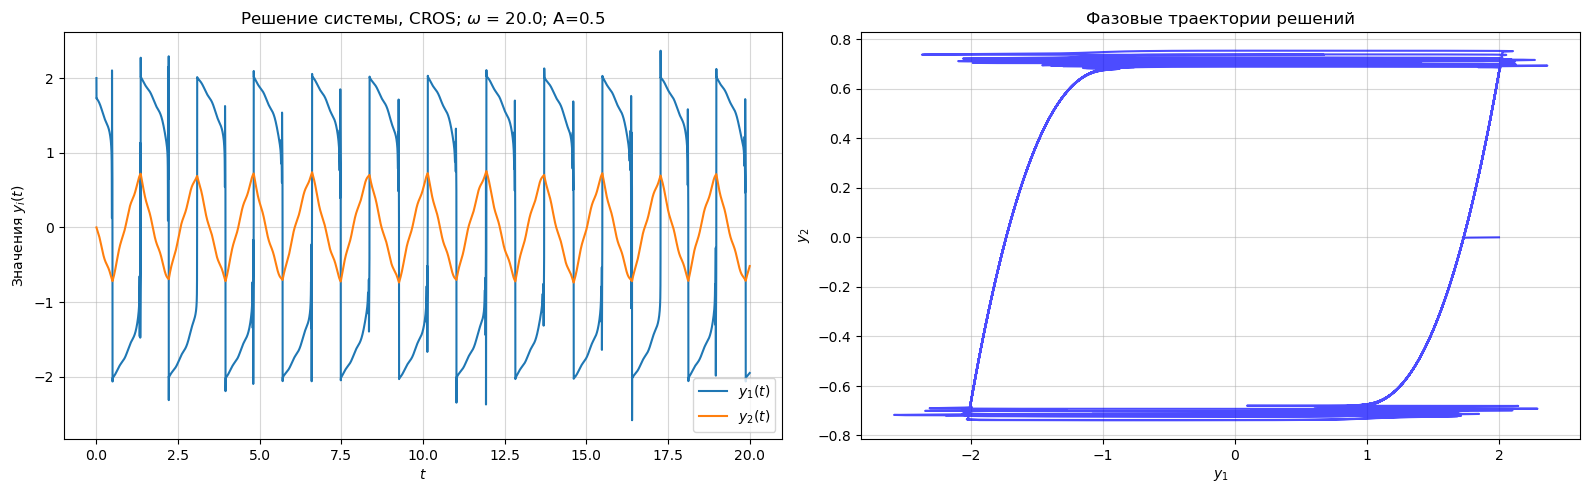

In [188]:
omega_values = [0.5, 1, 2, 4, 10, 20]

A=0.5
a=1000

for j, omega in enumerate(omega_values):
    t_my, y_my = cros_method(my_system, my_system_jacobian, t_span=[0.0,20.0], y0=[2.0, 0.0], h=0.0005, omega=omega, A=A, a=1000)
    i = 2*j

    plt.figure(figsize=(16, 27))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_my, y_my[:, 0], label="$y_1(t)$")
    plt.plot(t_my, y_my[:, 1], label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы, CROS; $\omega$ = {omega:.1f}; A={A}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y_my[:, 0], y_my[:, 1], label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

У метода `CROS` как и в случае автономной задачи наблюдаются значительные по амплитуде осцилляции при переходе с медленного участка на быстрый и наоборот. Данная особенность является характерной для задач с сильно различными характреными временами. При этом стоит отметить что с увеличением частоты вынужденных колебаний осцилляции становятся меньшими по амплитуде

Сравним полученные результаты с аналогичными, построенными с помощью неявного метода Рунге-Кутты соответствующему таблице №3

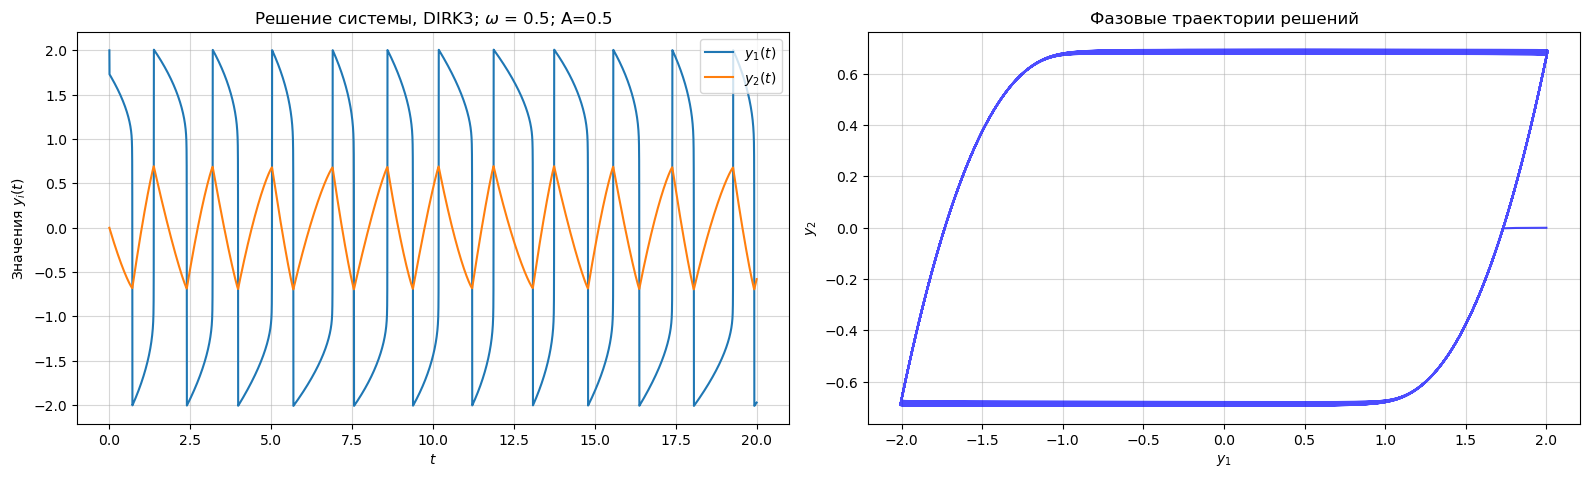

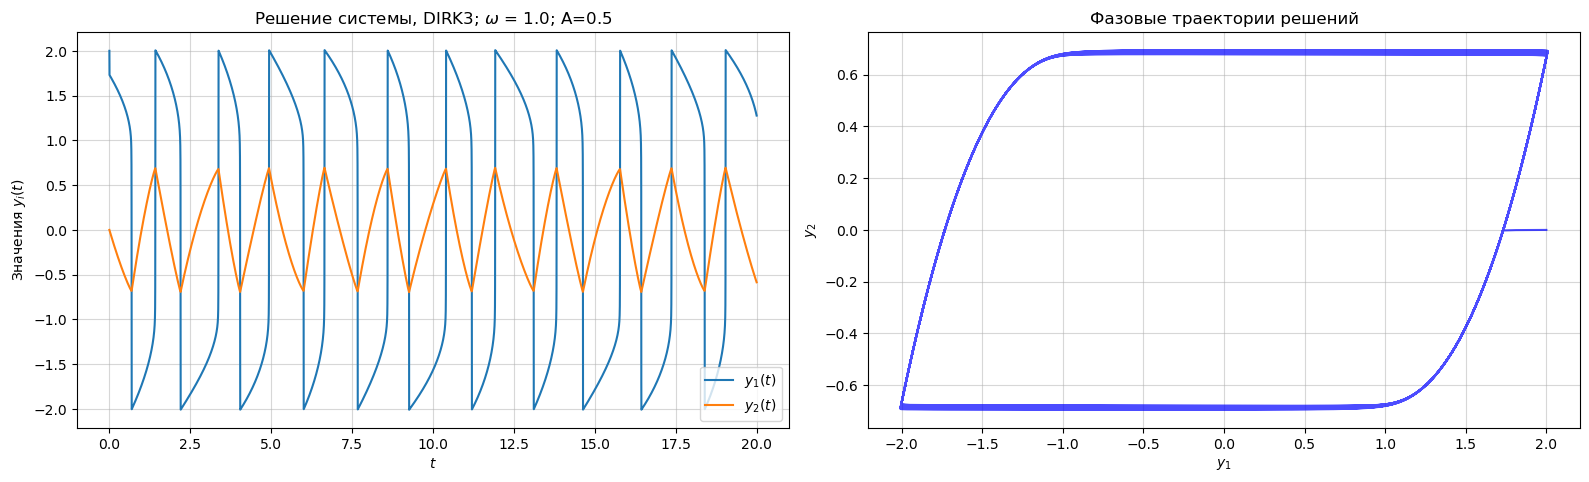

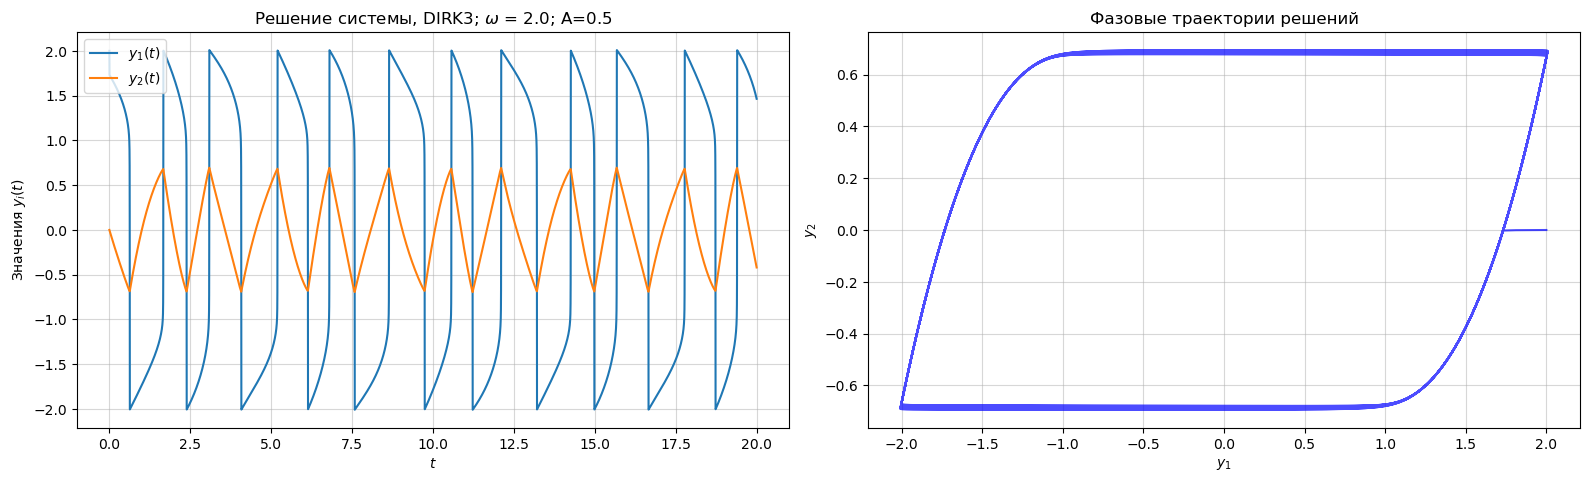

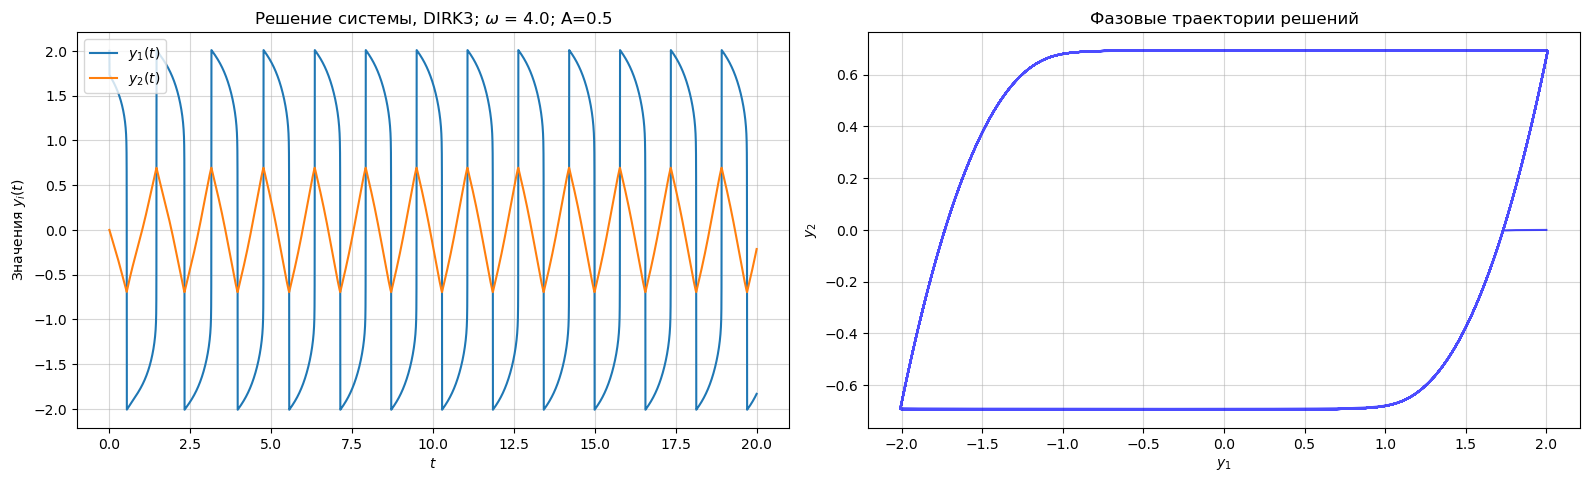

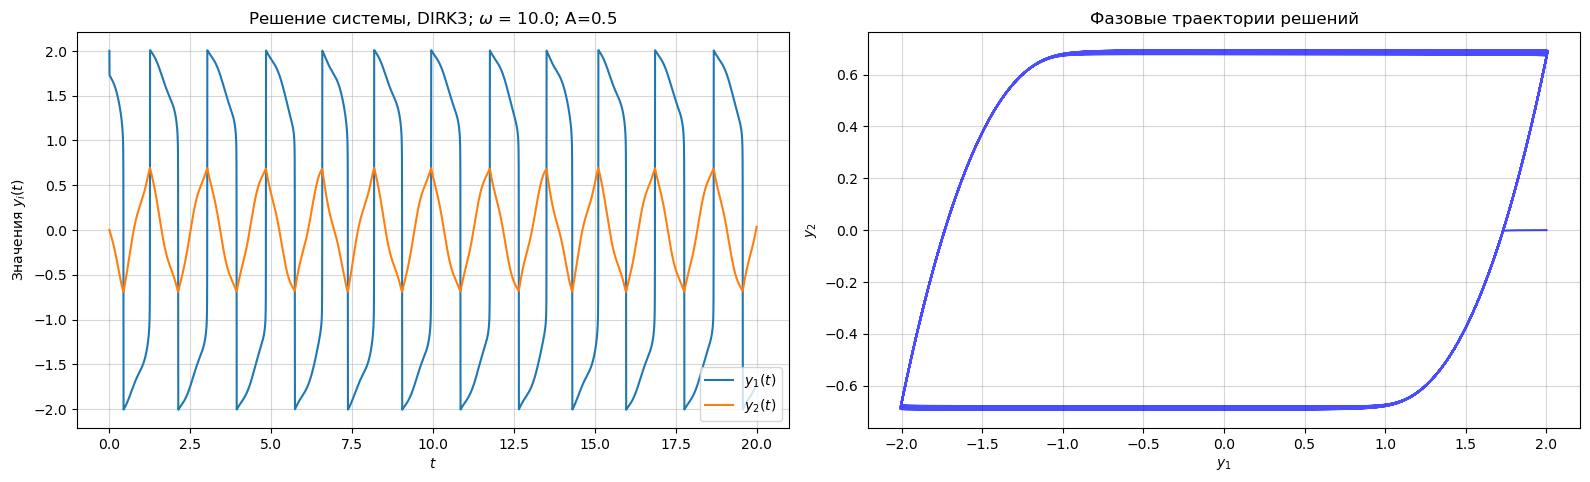

In [197]:
omega_values = [0.5, 1, 2, 4, 10, 20]

A=0.5
a=1000

for j, omega in enumerate(omega_values):
    t_drk3, y1_drk3, y2_drk3 = dirk_3(lambda t, y1, y2: f(t, y1, y2, a, A, omega), lambda t, y1, y2: g(t, y1, y2,a, A, omega), t_span=[0.0, 20.0], h=0.0005, y0=[2.0, 0.0], a=1000, A=0.5, omega=omega)
    i = 2*j

    plt.figure(figsize=(16, 27))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_drk3, y1_drk3, label="$y_1(t)$")
    plt.plot(t_drk3, y2_drk3, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы, DIRK3; $\omega$ = {omega:.1f}; A={A}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_drk3, y2_drk3, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

Как и в случае с автономной системой данный метод является самым лучшим и не даёт осцилляций при чередовании быстрого и медленного участка. Однако с этим связан и недостаток метода - долгое время работы для обеспечения достаточной точности (в 3-4 раза дольше чем CROS или ФДН)

Попробуем теперь исследовать решения при большей амплитуде: $1<A<\sqrt{1 + \frac{1}{64\omega^2}}$; например $A=\frac 12 (1 + \sqrt{1 + \frac{1}{64\omega^2}})$. Для этого будем использовать метод ФДН

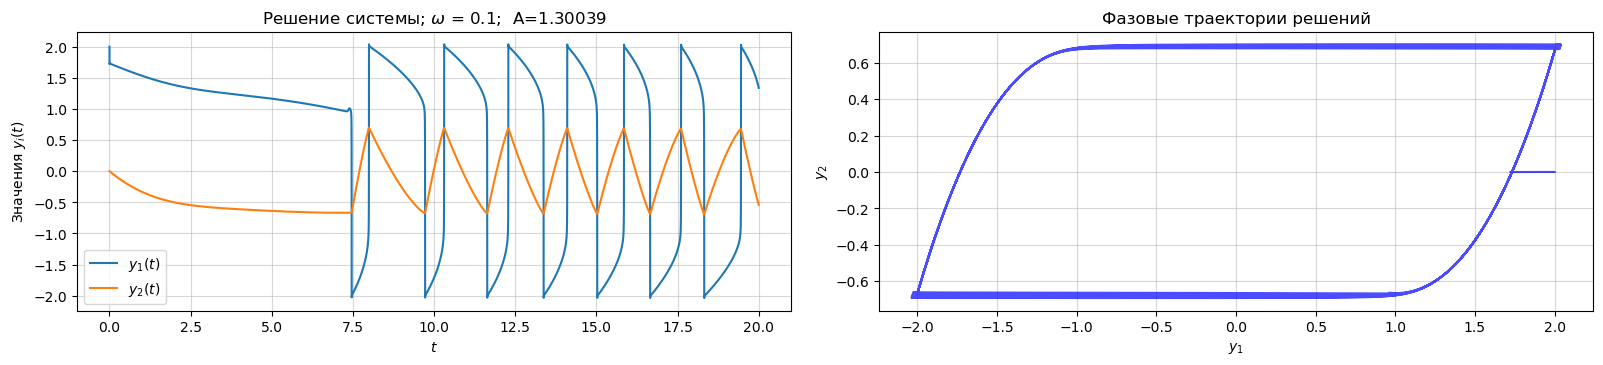

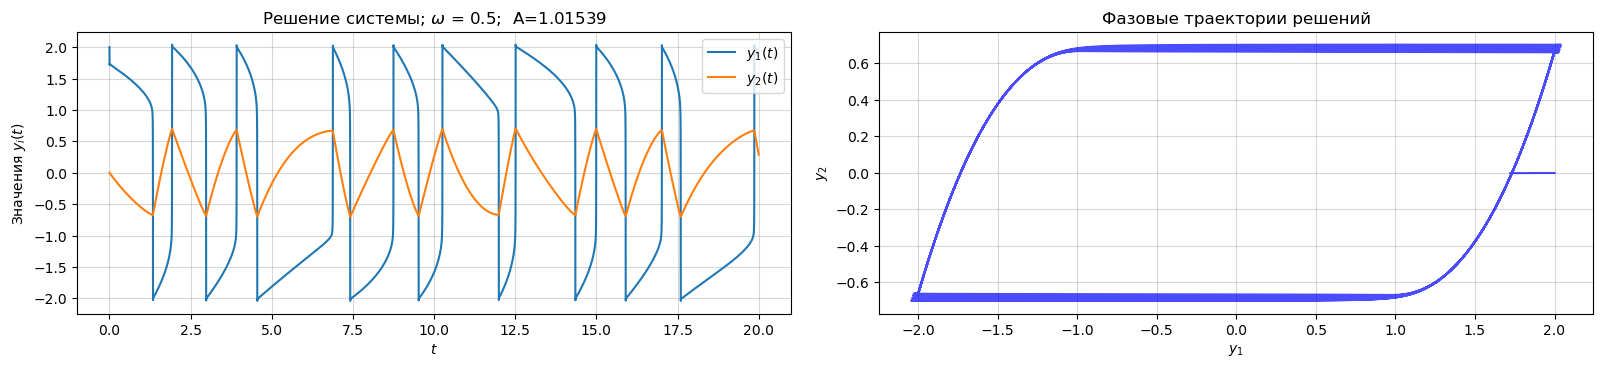

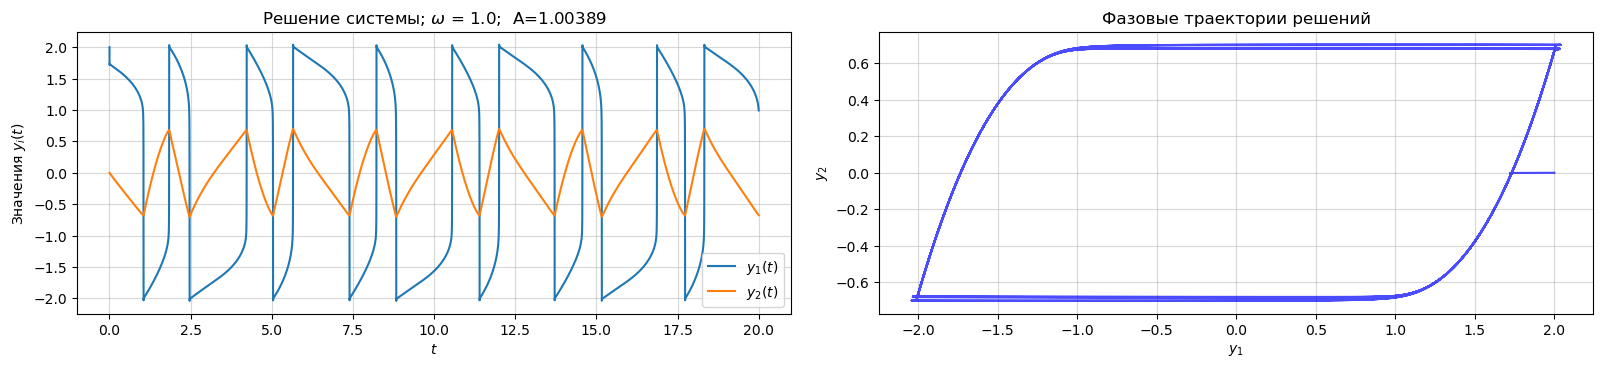

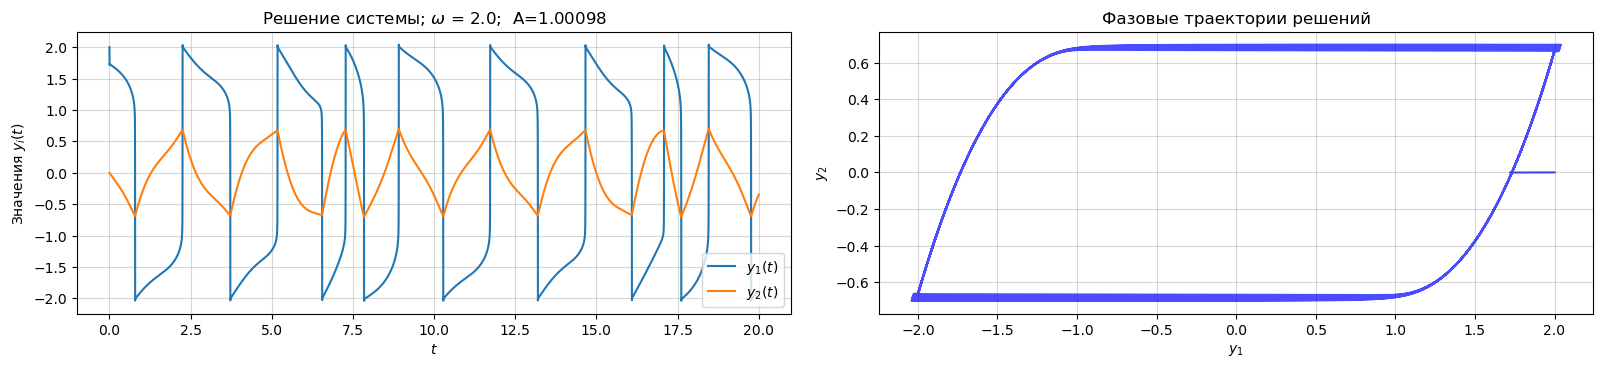

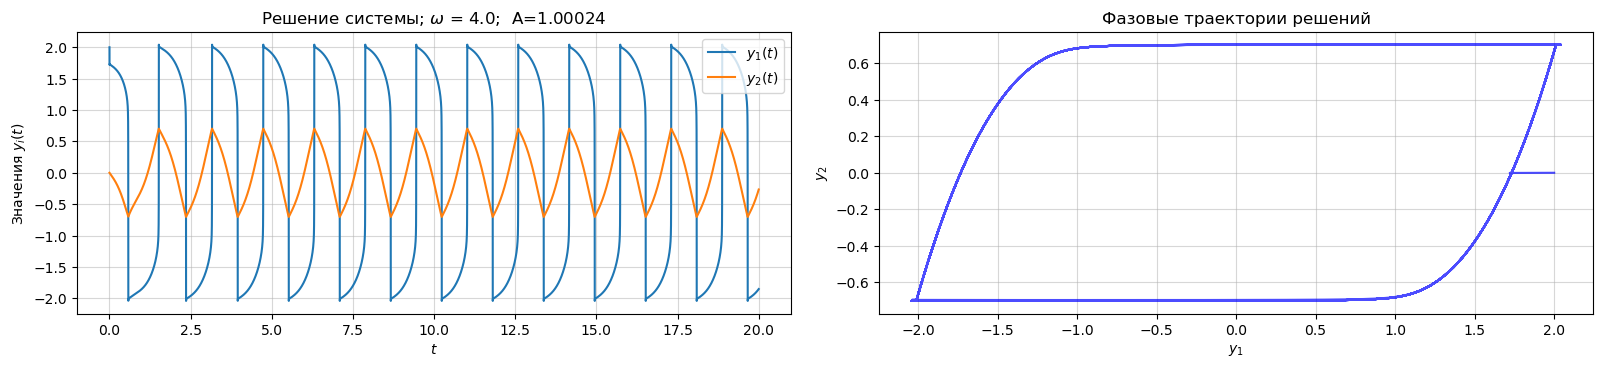

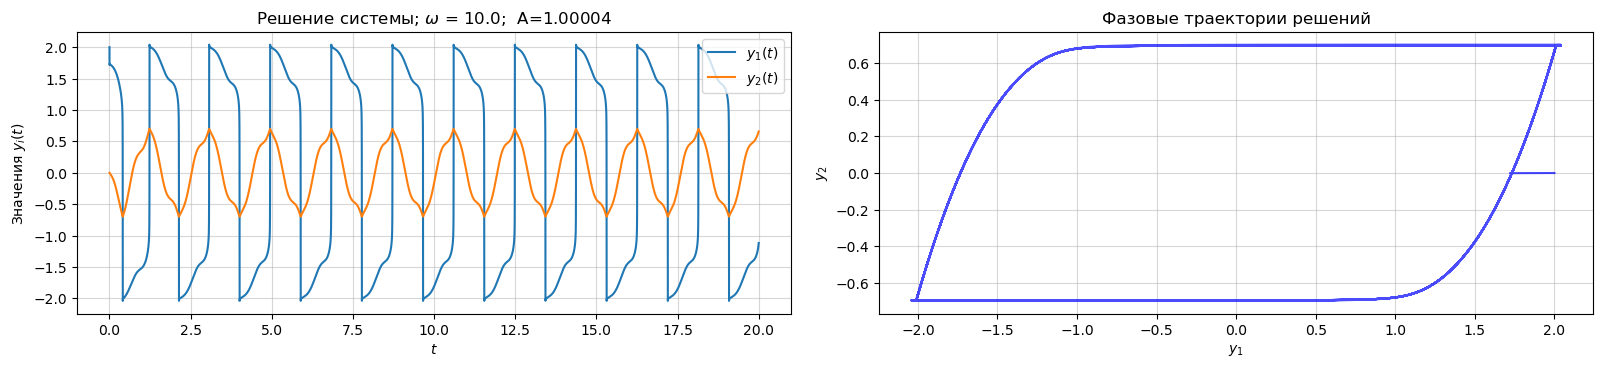

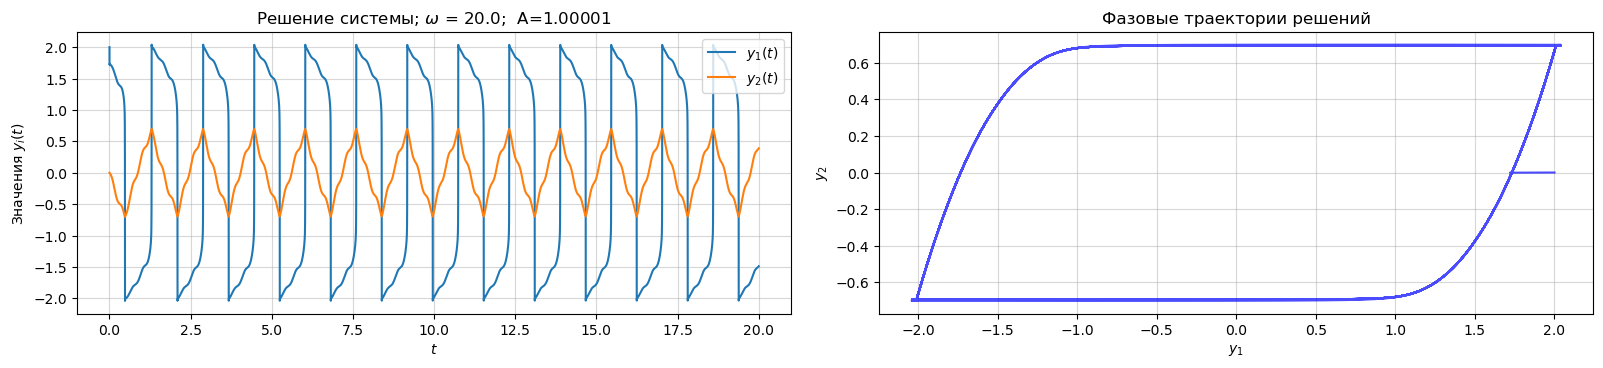

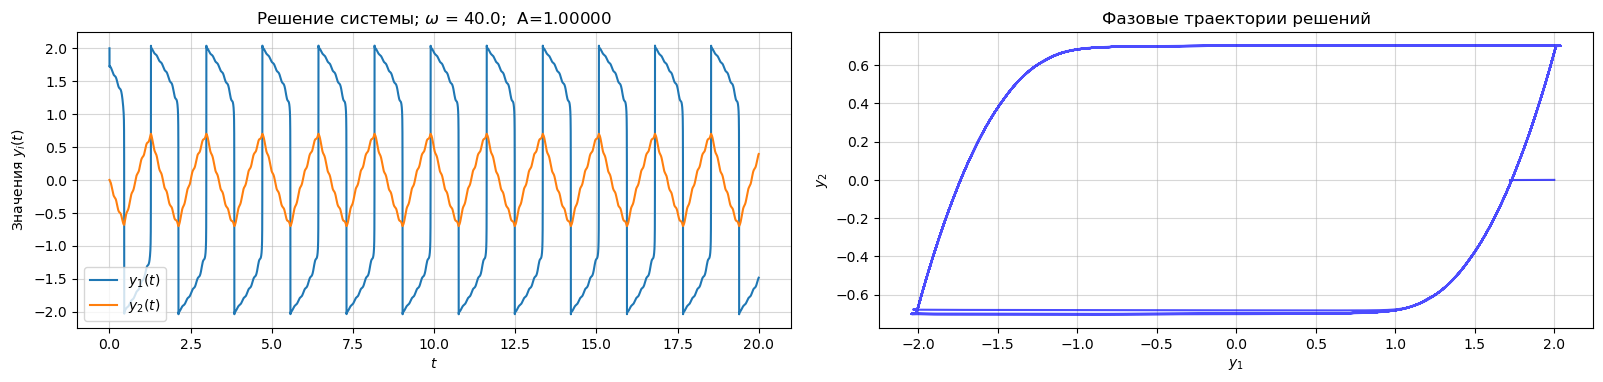

In [199]:
omega_values = [0.1, 0.5, 1, 2, 4, 10, 20, 40]

a=1000

for j, omega in enumerate(omega_values):
    A = 0.5*(1 + np.sqrt(1+1/(64*omega**2)))
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=20.0, h=0.0002, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 27))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.1f};  A={A:.5f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

При увеличении амплитуды происходит усиление влияния вынужденных колебаний на решения: амплитуда отклонений от автономного становится больше. Но самый интересный эффект наблюдается в области малых частот

Исследуем отдельно решения при малых частотах, также увеличим время интегрирования $T\in[0; 100]$:

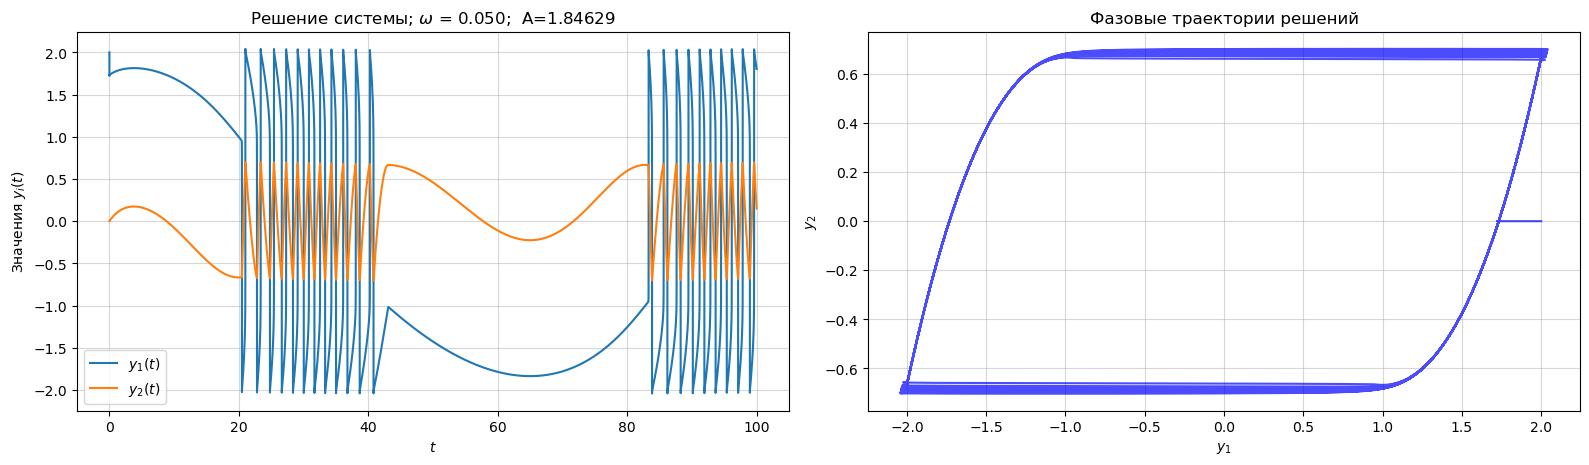

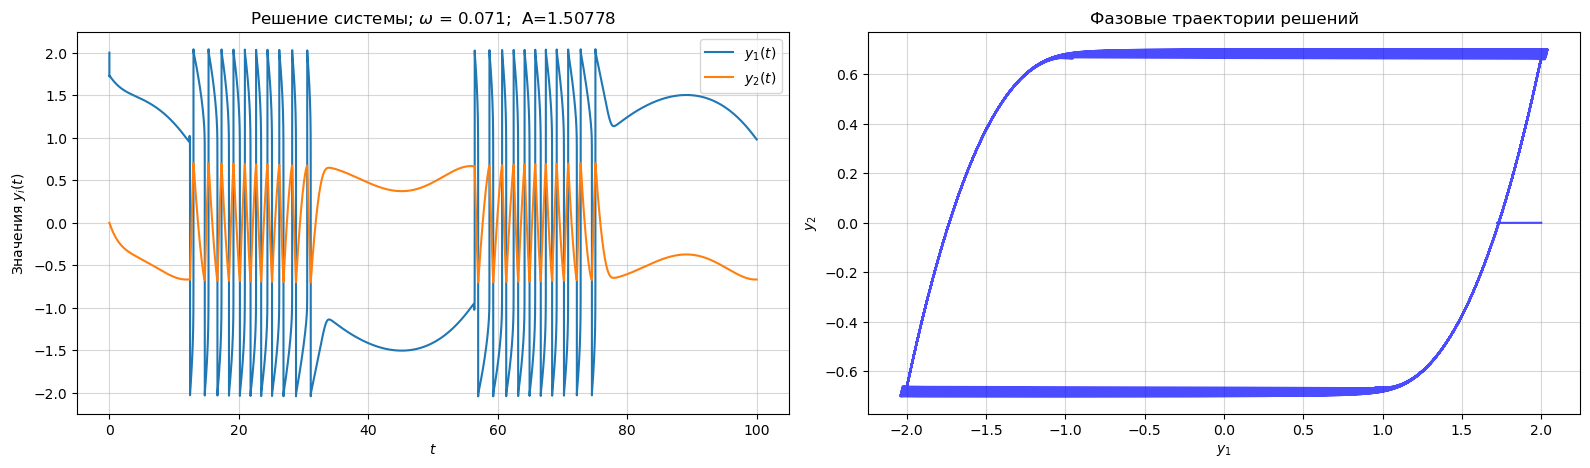

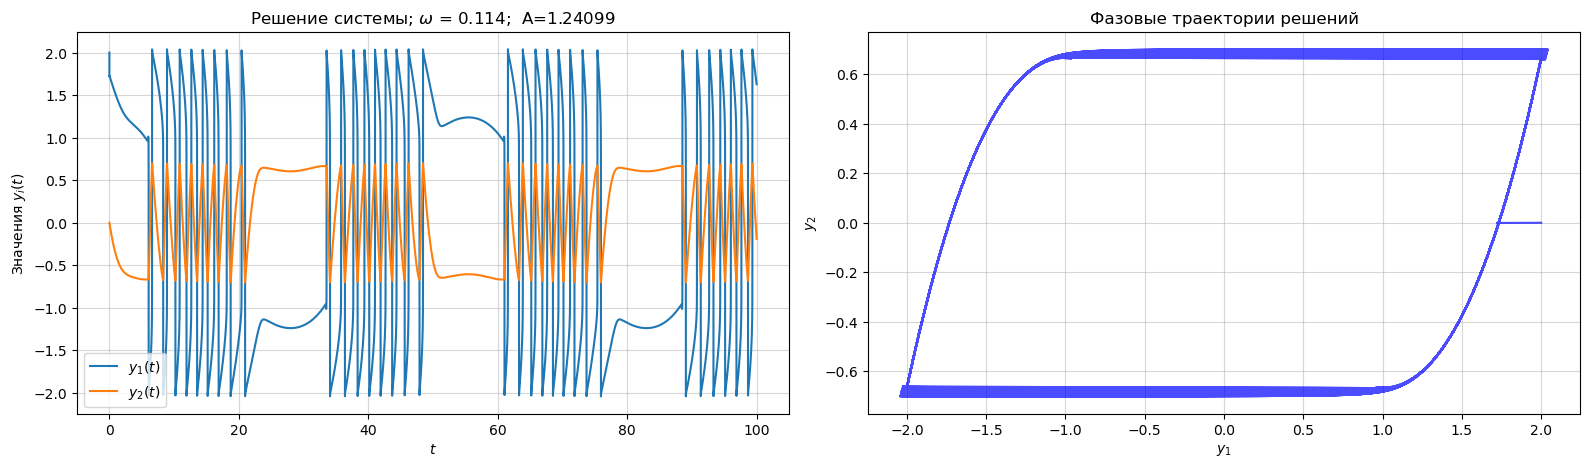

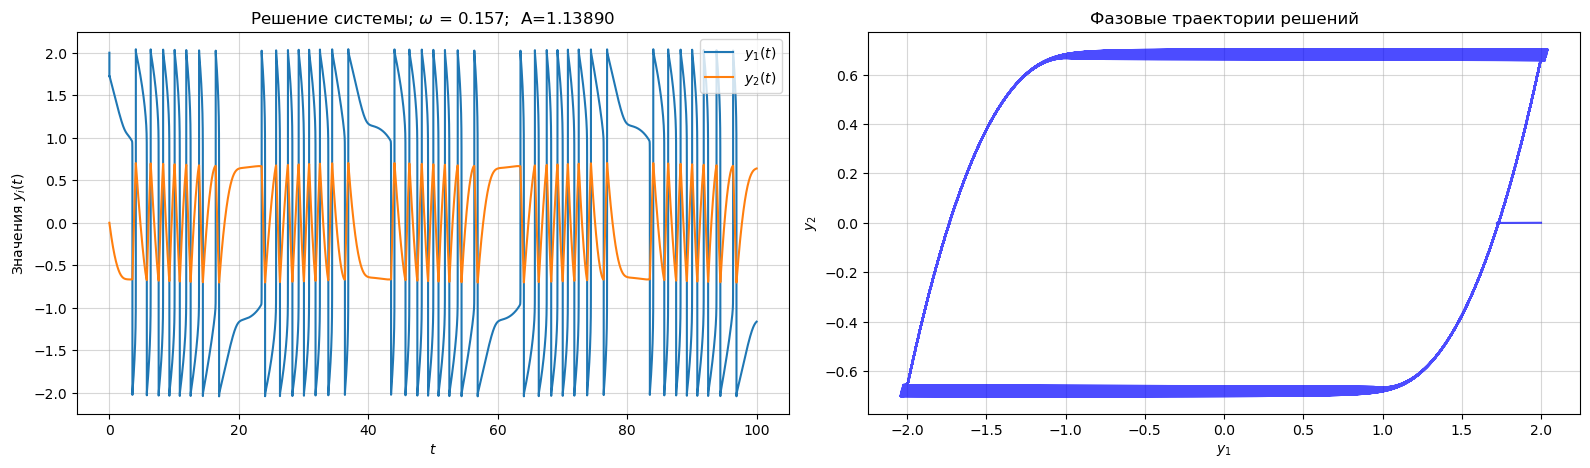

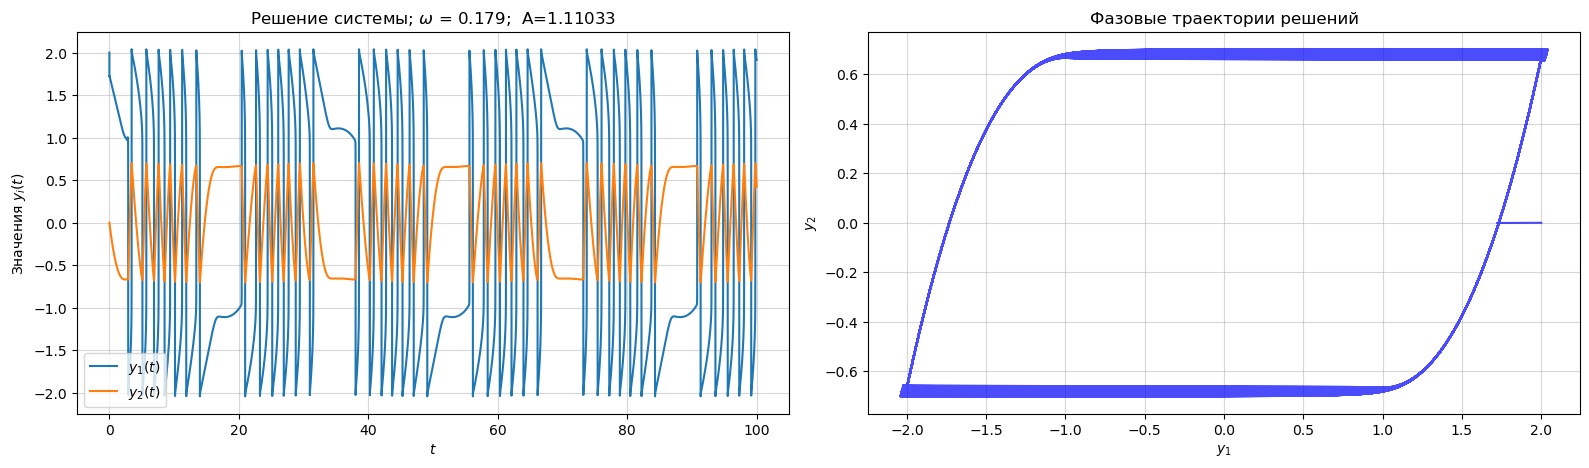

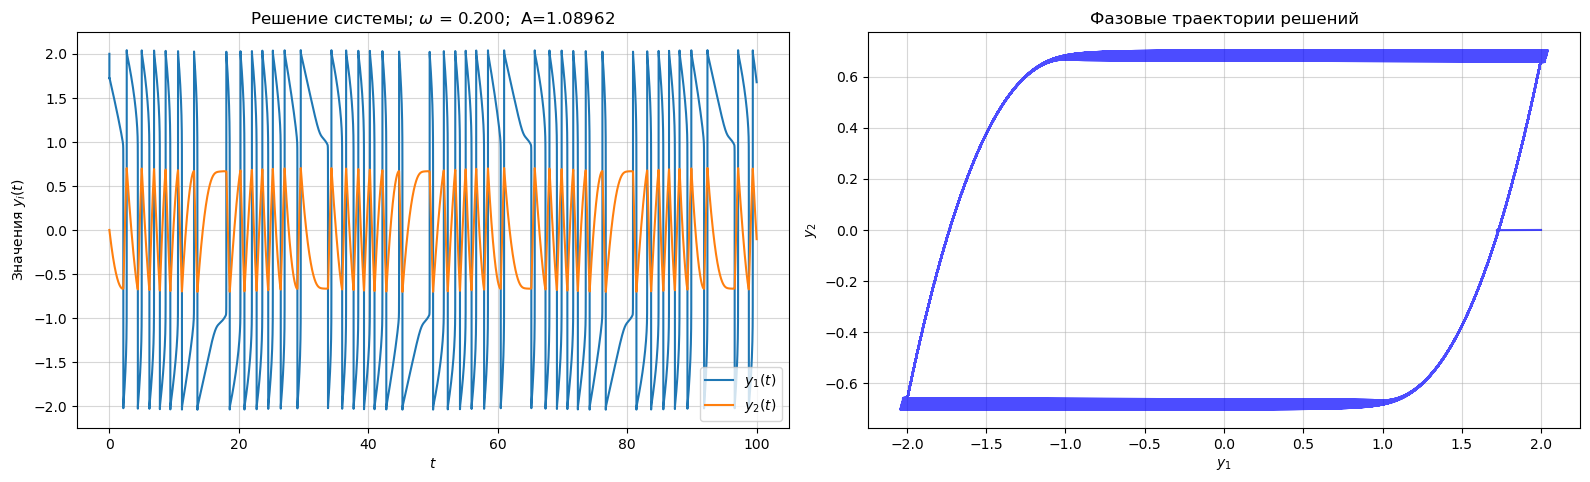

In [205]:
omega_values = np.linspace(0.05, 0.2,8)

a=1000

for j, omega in enumerate(omega_values):
    A = 0.5*(1 + np.sqrt(1+1/(64*omega**2)))
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=100.0, h=0.0002, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 35))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.3f};  A={A:.5f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

Видно, что при очнь малых частотах происходит возникновение серий колебаний. Попробуем посмотреть на решения при ещё меньших значениях $\omega\sim 10^{-2}$

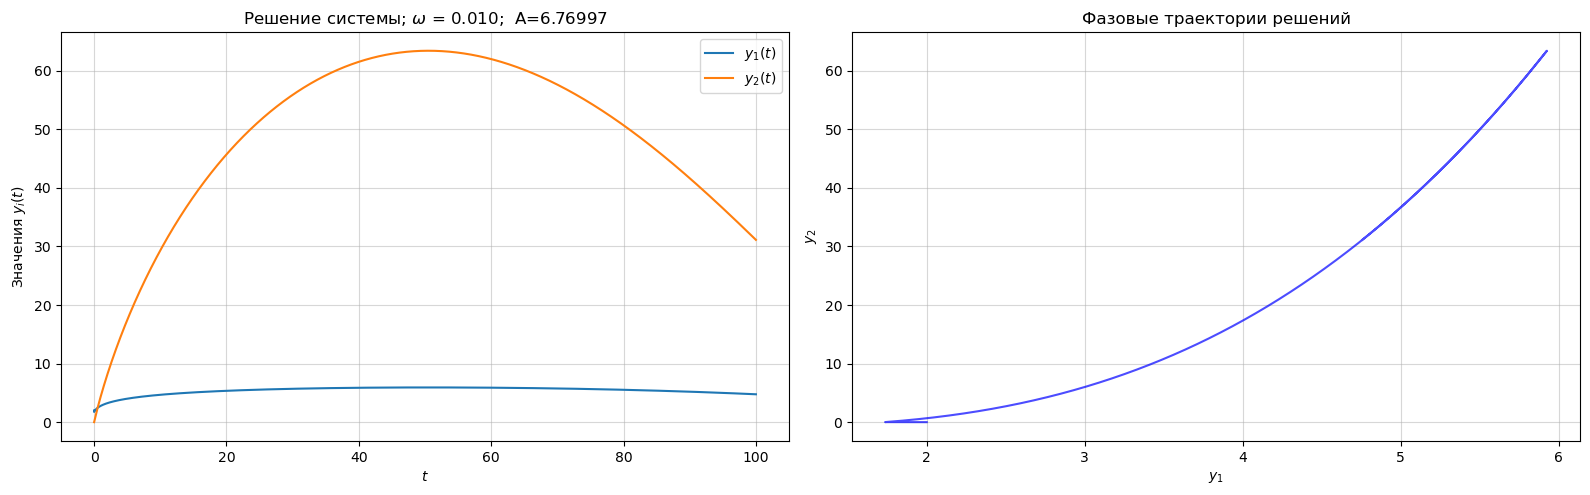

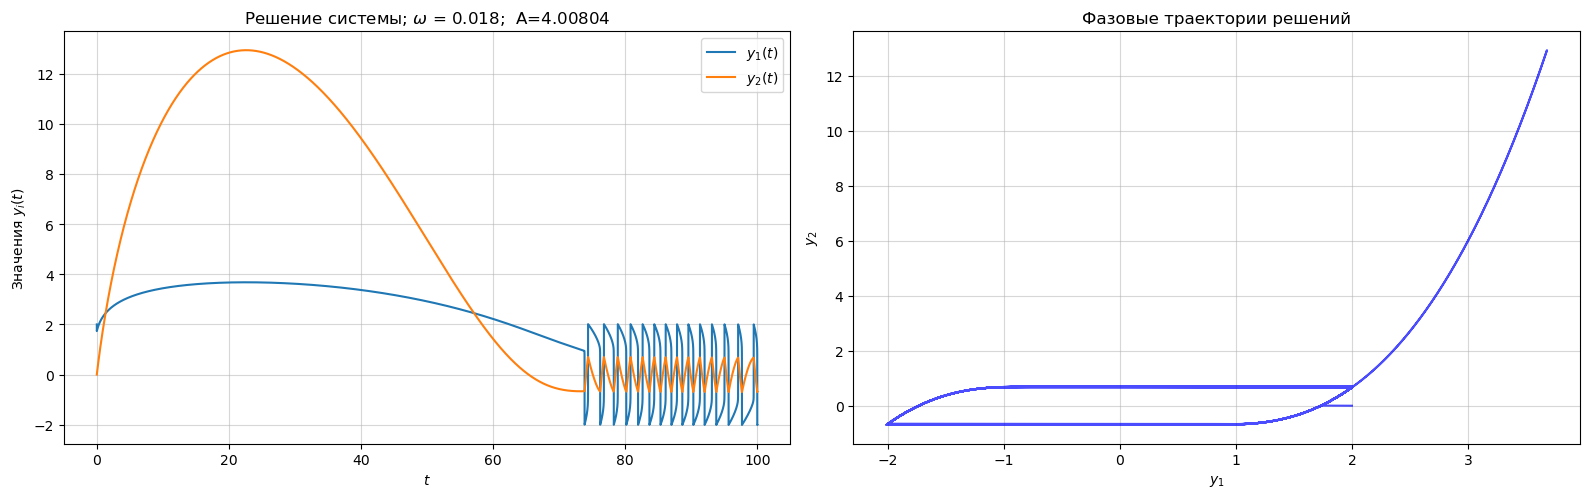

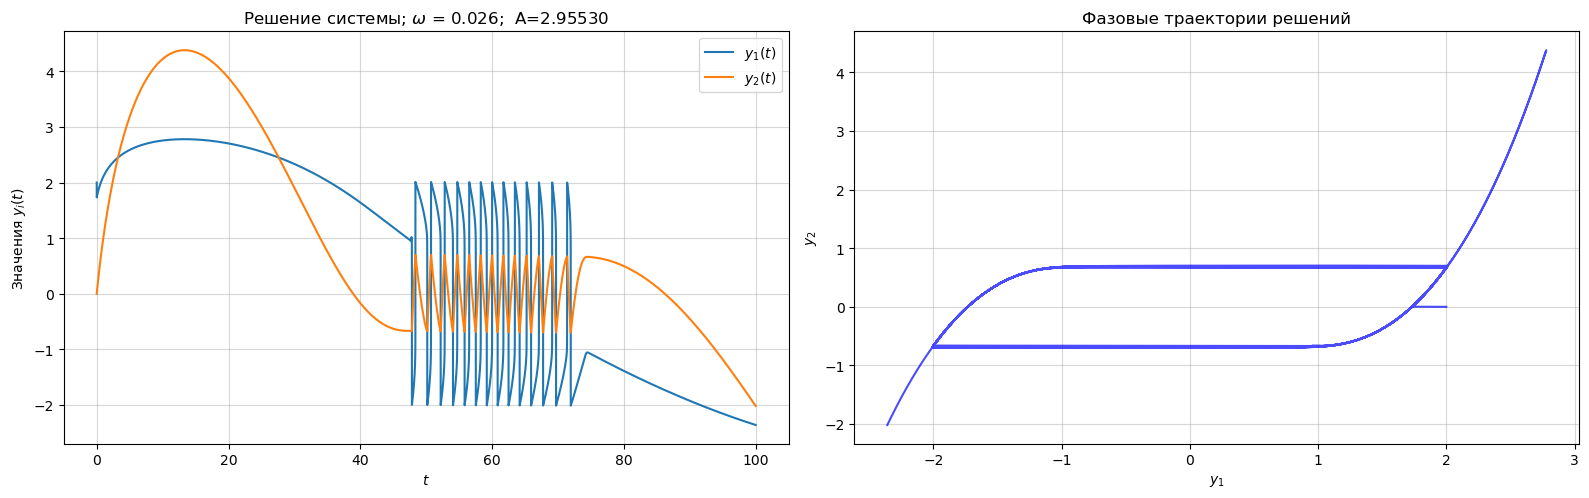

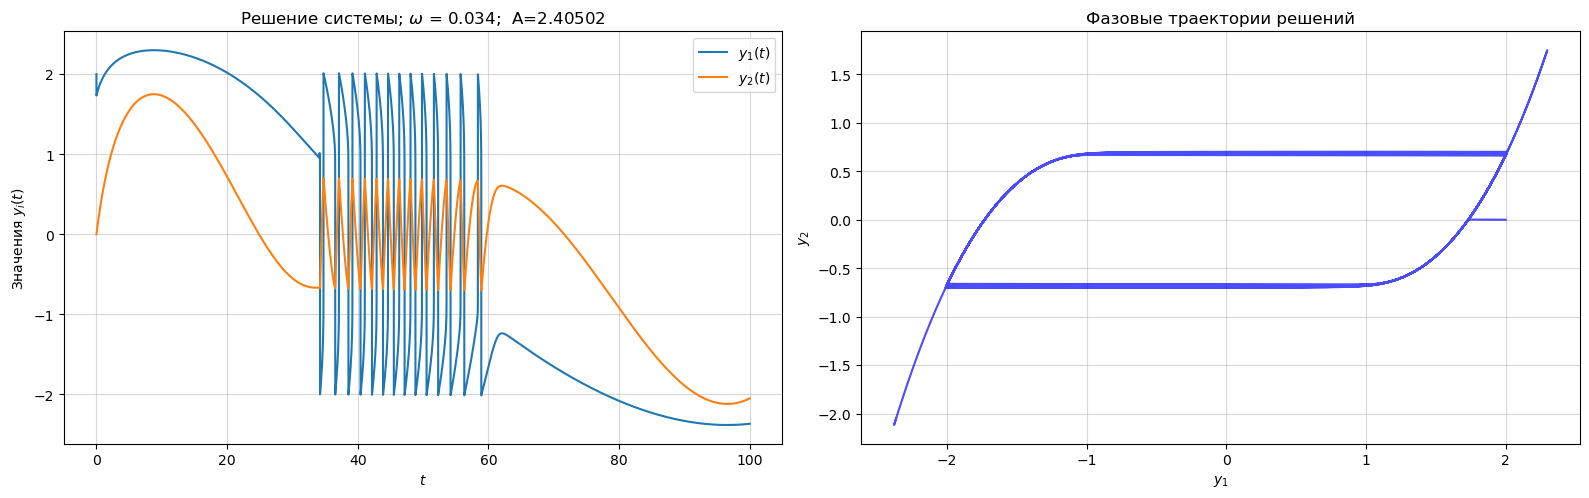

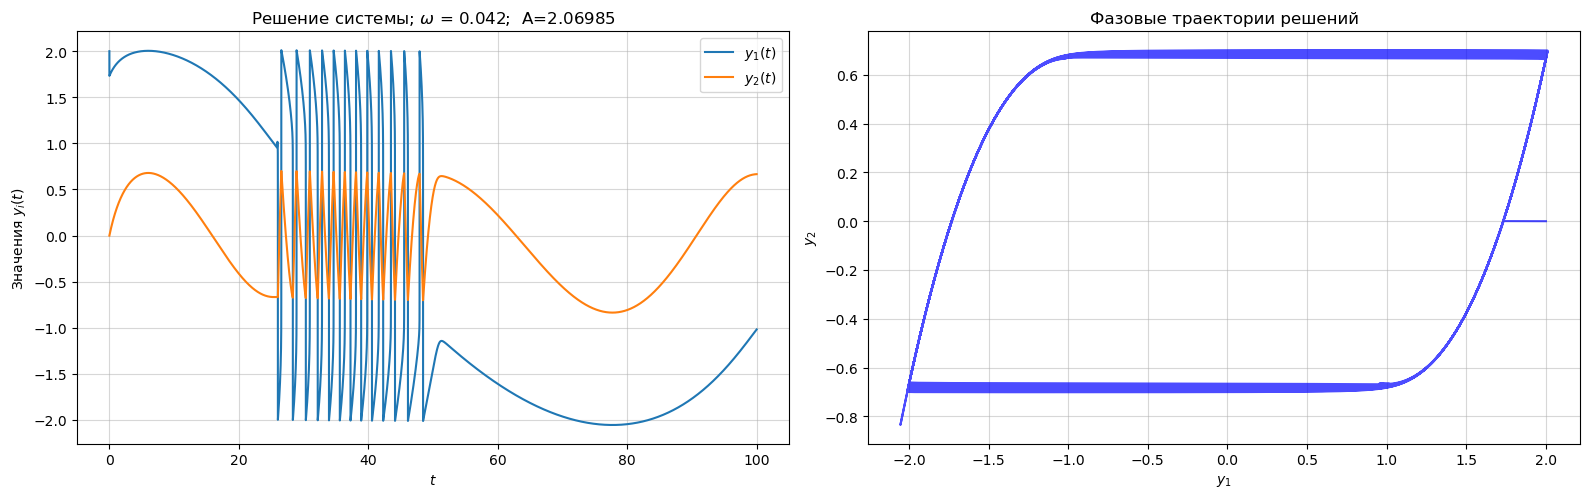

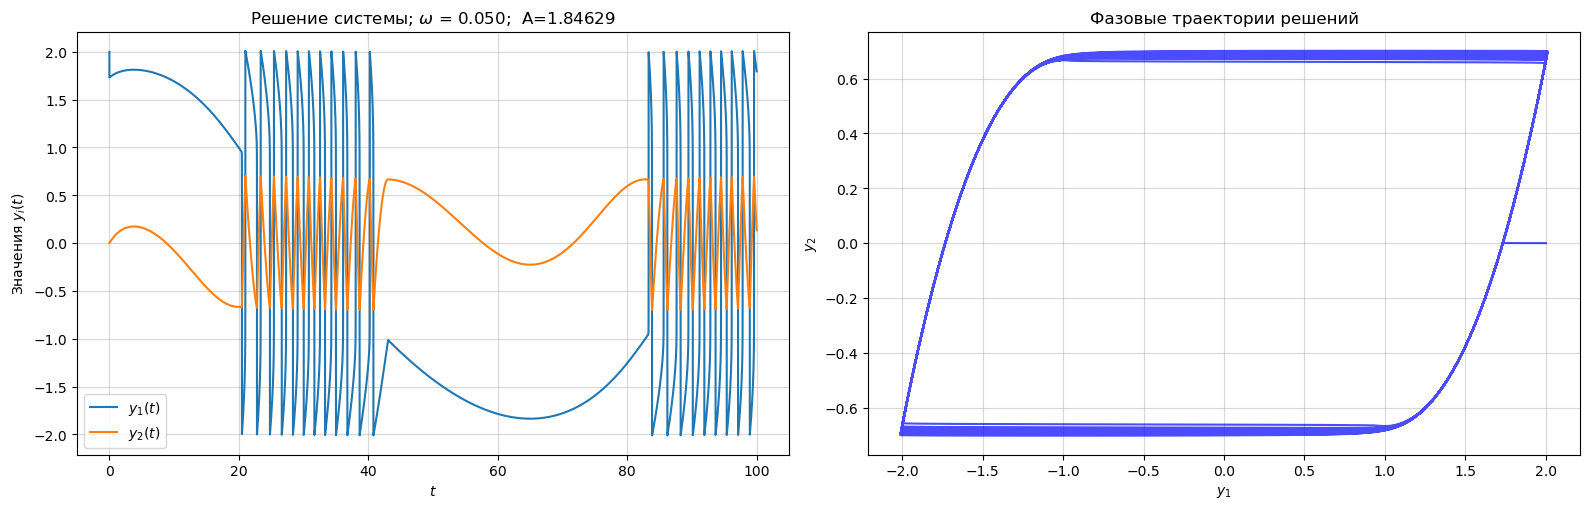

In [209]:
omega_values = np.linspace(0.01, 0.05,6)

a=1000

for j, omega in enumerate(omega_values):
    A = 0.5*(1 + np.sqrt(1+1/(64*omega**2)))
    t_fdn, y1_fdn, y2_fdn = fdn(a=a, A=A, omega=omega, t0=0.0, tf=100.0, h=0.0001, y1_0=2.0, y2_0=0.0)
    i = 2*j

    plt.figure(figsize=(16, 28))
    #plt.title(f'Omega = {omega}')
    plt.subplot(len(omega_values), 2, i+1)
    plt.plot(t_fdn, y1_fdn, label="$y_1(t)$")
    plt.plot(t_fdn, y2_fdn, label="$y_2(t)$")
    plt.grid(alpha=0.5)
    plt.xlabel(r"$t$")
    plt.ylabel(r"Значения $y_i(t)$")
    plt.title(fr"Решение системы; $\omega$ = {omega:.3f};  A={A:.5f}")
    plt.legend()

    plt.subplot(len(omega_values), 2, i+2)
    plt.plot(y1_fdn, y2_fdn, label="Фазовый портрет", color="blue", alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title("Фазовые траектории решений")
    plt.tight_layout()
    plt.show()

При очень низких значениях частоты и высокой амплитуде решение перестаёт быть периодическим и выходит за пределы $[-2; 2]$

### Построение функций устойчивости:

Функия устойчивости метода `CROS` выглядит следующим образом:
$$
R(z) = \frac{1}{1-z+\frac{z^2}2}
$$

Построим её на комплексной плоскости и выделим область $|f(z)|<1$(зелёным цветом)

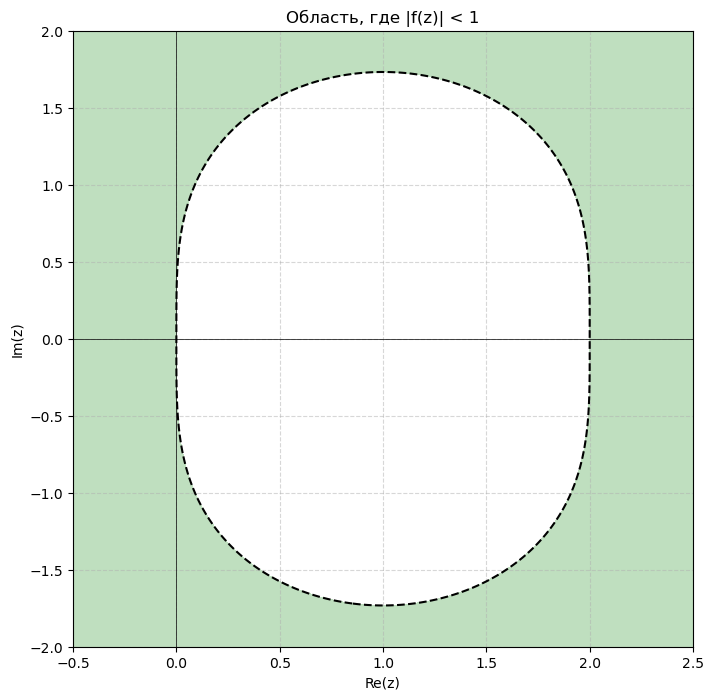

In [118]:
def f(z):
    return 1/(1-z+np.power(z, 2)/2)


def plot_complex_plane_contour(f, x_range=(-2, 2), y_range=(-2, 2), points=300):
 

    x = np.linspace(x_range[0], x_range[1], points)
    y = np.linspace(y_range[0], y_range[1], points)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y

    F = f(Z)
    mod_F = np.abs(F)

    plt.figure(figsize=(8, 8))
    plt.contourf(X, Y, mod_F, levels=[0, 1], colors='green', alpha=0.25)  

    plt.contour(X, Y, mod_F, levels=[1], colors='black', linestyles='dashed')

    plt.title('Область, где |f(z)| < 1')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')

    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()


plot_complex_plane_contour(f, x_range=(-0.5, 2.5))

Таким образом видно, что метод является А-устойчивым, следовательно, он отлично подходит для решения данной задачи, где $\text{Re} \Lambda\sim a = 10^3$.

#### Методы Рунге-Кутты

Функция устойчивости метода Рунге-Кутты выглядит следующим образом:
$$
R = \frac{\det(E-zA+zeb^T)}{\det(E-zA)}
$$

Построим аналогичные графики функций устойчивости для неявных методов РК начиная с первого. Таблица Бутчера для него:

\begin{matrix}
\frac{2+\sqrt{2}}{4}&\frac{2+\sqrt{2}}{4}&0\\
\frac{2-\sqrt{2}}{4}&-\frac1{\sqrt{2}}&\frac{2+\sqrt{2}}{4}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

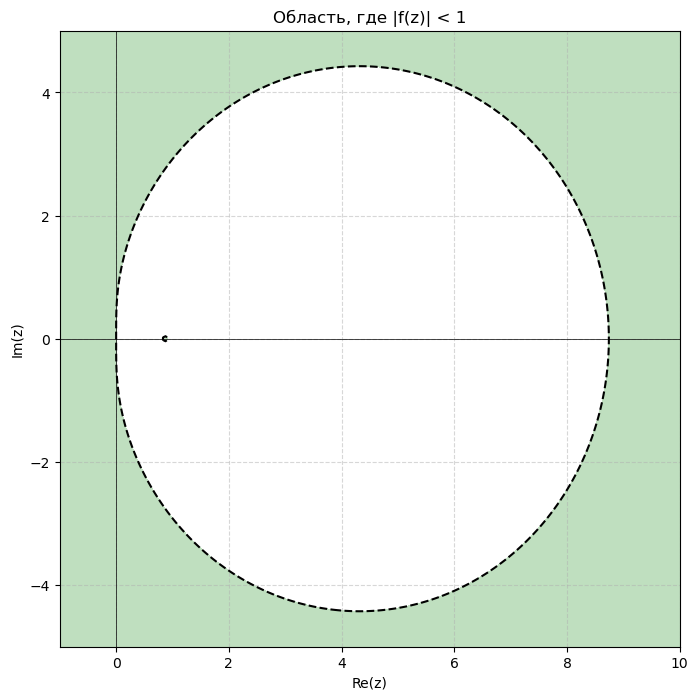

In [119]:
def f_rk(z, A, b):
    E = np.eye(N=b.size)
    e = np.ones_like(b)
    return np.abs(np.linalg.det(E - z*A + z*b.reshape(-1, 1)@e.reshape(1, -1))/np.linalg.det(E - z*A))

a1 = np.array(
    [[(2+np.sqrt(2))/4, 0],
     [-np.sqrt(2)/2, (2+np.sqrt(2))/4]], dtype=np.float64
)

b1 = np.array([1/2, 1/2], dtype=np.float64)

plot_complex_plane_contour(np.vectorize(lambda z: f_rk(z, a1, b1)), x_range=(-1, 10), y_range=(-5, 5))

Метод является А-устойчивым

Для второго метода Рунге-Кутты с таблицей:

\begin{matrix}
\frac{2-\sqrt{2}}{4}&\frac{2-\sqrt{2}}{4}&0\\
\frac{2+\sqrt{2}}{4}&\frac1{\sqrt{2}}&\frac{2-\sqrt{2}}{4}\\
\\
\hline
\\
&\frac 12&\frac 12
\end{matrix}

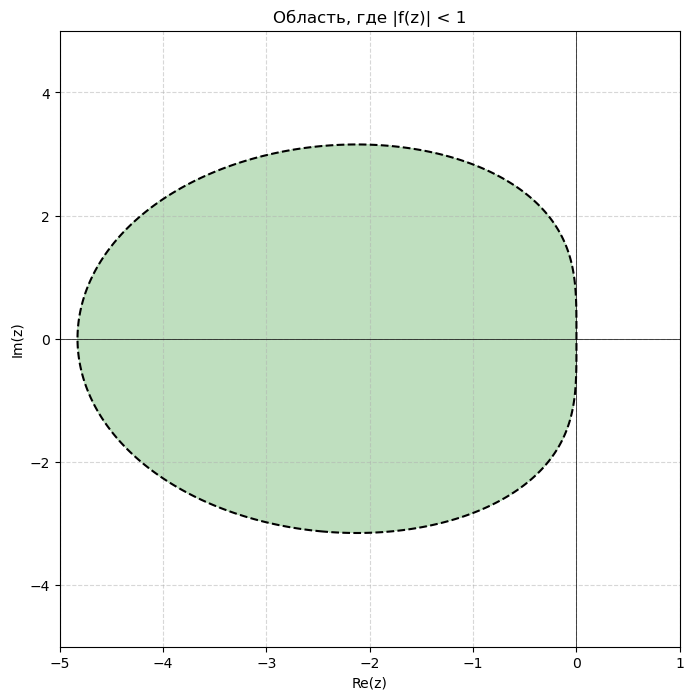

In [120]:
def f_rk(z, A, b):
    E = np.eye(N=b.size)
    e = np.ones_like(b)
    return np.abs(np.linalg.det(E - z*A + z*b.reshape(-1, 1)@e.reshape(1, -1))/np.linalg.det(E - z*A))

a2 = np.array(
    [[(2-np.sqrt(2))/4, 0],
     [np.sqrt(2)/2, (2-np.sqrt(2))/4]], dtype=np.float64
)

b1 = np.array([1/2, 1/2], dtype=np.float64)

plot_complex_plane_contour(np.vectorize(lambda z: f_rk(z, a2, b1)), x_range=(-5, 1), y_range=(-5, 5))

По данному графику видно, что неявный метод РК, отвечающий таблице Бутчера №2 не будет являться А-устойчивым (единственный из 3х)

Для третьего метода с таблицей:

\begin{matrix}
\frac{3+\sqrt{3}}6 & \frac{3+\sqrt{3}}{6} & 0 \\
\frac{3-\sqrt{3}}6 & -\frac{\sqrt{3}}3 & \frac{3+\sqrt{3}}{6} \\
\\
\hline
\\
&\frac 12 & \frac 12
\end{matrix}

/opt/anaconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


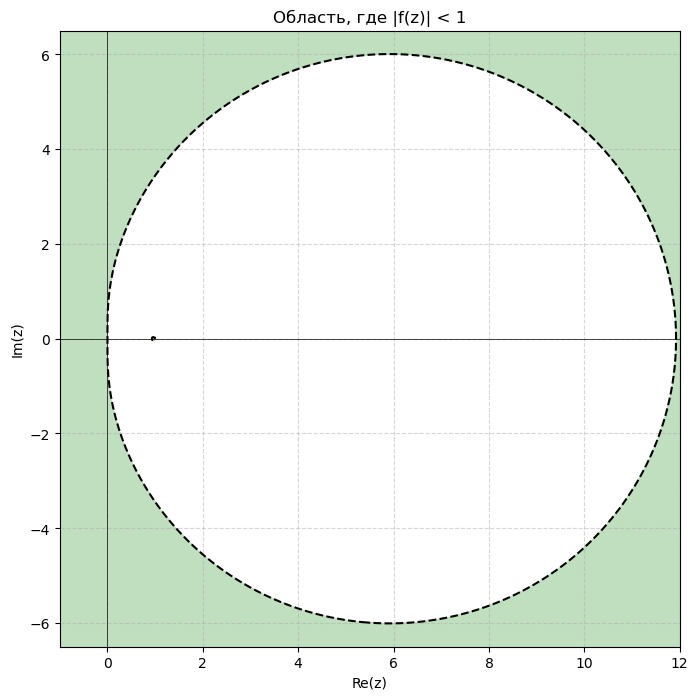

In [121]:
a3 = np.array(
    [[(3+np.sqrt(3))/6, 0],
     [-np.sqrt(3)/3, (3+np.sqrt(3))/6]], dtype=np.float64
)

b1 = np.array([1/2, 1/2], dtype=np.float64)

plot_complex_plane_contour(np.vectorize(lambda z: f_rk(z, a3, b1)), x_range=(-1, 12), y_range=(-6.5, 6.5))

По полученому изображению видно, что неявный двухстадийный метод РК с таблицей №3 является А-устойчивым

### Устойчивость метода ФДН

Для построения функции устойчивости метода ФДН можно использовать модельное уравнение Далквиста: $y' = \lambda y$. Подставим в начальное уравнение:

$$
\frac{3}{2}y_{n+1} - 2y_n + \frac{1}{2}y_{n-1} = h\lambda y_{n+1}
$$  
  

Учитывая, что $ z = h\lambda $ и предполагая, что $ y_{n+1} = \xi y_n $, подставляя и сокращая уравнение, получаем:  

$$
\left( \frac{3}{2} - z \right) \xi^2 - 2\xi + \frac{1}{2} = 0
$$    

Корни этого уравнения:  

$$
\xi_{1,2} = \frac{2 \pm \sqrt{1 + 2z}}{3 - 2z}
$$   

Рассмотрим поведение корней при $ |z| \to 0 $ с помощью разложения в ряд Тейлора. Истинная функция устойчивости оказывается с плюсом перед дискриминантом:  

$$
R(z) = \frac{2 + \sqrt{1 + 2z}}{3 - 2z}
$$  

Построим график:

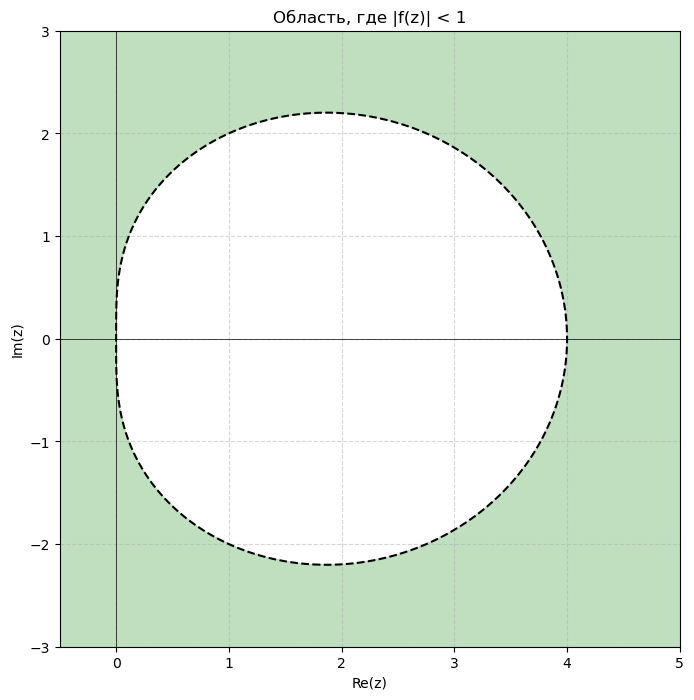

In [125]:
def R(z):
    return (2+np.sqrt(1+2*z))/(3 - 2*z)

plot_complex_plane_contour(R, x_range=(-0.5, 5), y_range=(-3, 3))

По потроенной карте видно, что метод ФДН является также А-устойчивым

### Выводы:

В ходе решения данной задачи были построены различные методы для решения задачи неавтономного осциллятора Ван-дер-Поля. Были построены следующие методы:
 - CROS: данный метод достаточно хорошо решает задачу всюду кроме точек перехода с быстрого участка на медленный и обратно, причем из графика и вида функции устойчивости видно, что данный метод является А-устойчивым. Также из вида функции устойчивости понятно, что он будет являться еще и L2 - устойчивым.
 - Неявные методы Рунге-Кутты с двумя стадиями с разными таблицами Бутчера: как видно из графиков, только 1 и 3 таблице отвечают А - устойчивые методы. Все 3 метода очень хорошо решают задачу и справляются идеально с точками перехода между быстрыми и медленными участками. Стоит отметить что самые маленькие шаги нужны именно для 2-й таблицы Бутчера что понятно исходя из графика функции устойчивости
- Метод ФДН: данный метод является А - устойчивым, а также L1/2− устойчивым. Данный метод оказался таким же простым в реализации как и метод CROS, однако он не содержит его недостака в виде значительных осцилляций при этом его время работы сильно меньше неявных методов РК.
- Характерной особенностью данной неавтономной задачи является полное отстутствие "раскачки" осциллятора при малых амплитудах вынуждающей силы ($A\sim 1$)
- При очень малых частотах вынуждающей силы осциллятор переходит в режим серий колебаний

---

## Задача 2

### 1. Формулировка задачи
Дана система нелинейных дифференциальных уравнений в стационарном состоянии для двух конкурирующих популяций бактерий в хемостате:

$$
u'' + \frac{1}{D_u} f(u, v) = 0,
$$
$$
v'' + \frac{1}{D_v} g(u, v) = 0,
$$

где:
- $f(u, v) = u h(z(x) - u - v)$,
- $g(u, v) = v h(z(x) - u - v)$,
- $z(x) = \frac{\gamma}{1 + \gamma} - x$,
- $h(s) = \frac{s}{a + s + b s^2}$,
- $D_u < D_v$ — коэффициенты диффузии,
- $0 < a, b < 1$, все параметры положительные.

Граничные условия:
- $u'(0) = v'(0) = 0$ (нулевой поток на левом конце),
- $u'(1) + \gamma u(1) = 0$, $v'(1) + \gamma v(1) = 0$ (смешанные условия на правом конце).

Цель: необзодимо исследовать решения $u(x);~ v(x)$ в зависимости от параметра $\gamma$.

### 2. Метод квазилинеаризации
Поскольку система нелинейная, прямое аналитическое решение крайне затруднительно (если возможно). Метод квазилинеаризации позволяет преобразовать нелинейную задачу в последовательность линейных задач, которые решаются итеративно.

#### Идея метода
Для нелинейного уравнения вида $u'' + F(u, v) = 0$ мы приближаем нелинейную функцию $F(u, v)$ с помощью разложения в ряд Тейлора первого порядка вблизи текущей точки $(u_n, v_n)$:

$$
F(u, v) \approx F(u_n, v_n) + \frac{\partial F}{\partial u}(u_n, v_n) (u - u_n) + \frac{\partial F}{\partial v}(u_n, v_n) (v - v_n).
$$

Применяя это к нашей системе:
- $F(u, v) = \frac{1}{D_u} f(u, v)$,
- $G(u, v) = \frac{1}{D_v} g(u, v)$.

На каждой итерации $n$ решается линеаризованная система:
$$
u'' + \frac{\partial F}{\partial u}(u_n, v_n) (u - u_n) + \frac{\partial F}{\partial v}(u_n, v_n) (v - v_n) + F(u_n, v_n) = 0,
$$
$$
v'' + \frac{\partial G}{\partial u}(u_n, v_n) (u - u_n) + \frac{\partial G}{\partial v}(u_n, v_n) (v - v_n) + G(u_n, v_n) = 0.
$$

#### Вычисление производных
Для $f(u, v) = u h(z(x) - u - v)$:
- $s = z(x) - u - v$,
- $h(s) = \frac{s}{a + s + b s^2}$,
$$ 
\frac{\partial h}{\partial s} = \frac{a - b s^2}{(a + s + b s^2)^2} 
$$.

Тогда:
$$
\frac{\partial f}{\partial u} = h(s) + u \frac{\partial h}{\partial s} (-1) = h(s) - u \frac{\partial h}{\partial s}
$$,
$$
\frac{\partial f}{\partial v} = u \frac{\partial h}{\partial s} (-1) = -u \frac{\partial h}{\partial s}
$$,
$$
\frac{\partial g}{\partial u} = v \frac{\partial h}{\partial s} (-1) = -v \frac{\partial h}{\partial s}
$$,
$$ 
\frac{\partial g}{\partial v} = h(s) + v \frac{\partial h}{\partial s} (-1) = h(s) - v \frac{\partial h}{\partial s} 
$$.

Эти производные вычисляются в точке $(u_n, v_n)$ на каждой итерации.

#### Итеративный процесс
1. Задаем начальное приближение $u_0(x), v_0(x)$ .
2. Решаем линеаризованную систему для $u_{n+1}, v_{n+1}$.
3. Проверяем сходимость: $\max(|u_{n+1} - u_n|, |v_{n+1} - v_n|) < \epsilon$.
4. Если сходимость не достигнута, повторяем шаг 2.


### 5. Метод прогонки
Для трехдиагональной системы можно использовать метод прогонки (алгоритм Томаса)

### Основная идея
Метод матричной прогонки (или алгоритм Томаса) — это эффективный способ решения систем линейных алгебраических уравнений с трёхдиагональной матрицей, который возникает при дискретизации дифференциальных уравнений второго порядка с двумя граничными условиями. 

### Дискретизация уравнений
Рассмотрим исходные уравнения после квазилинеаризации на $ n $-й итерации:

$$
u'' + \frac{\partial F}{\partial u}(u_n, v_n) (u - u_n) + \frac{\partial F}{\partial v}(u_n, v_n) (v - v_n) + F(u_n, v_n) = 0,
$$
$$
v'' + \frac{\partial G}{\partial u}(u_n, v_n) (u - u_n) + \frac{\partial G}{\partial v}(u_n, v_n) (v - v_n) + G(u_n, v_n) = 0,
$$

где:
- $ F(u, v) = \frac{1}{D_u} u h(z(x) - u - v) $,
- $ G(u, v) = \frac{1}{D_v} v h(z(x) - u - v) $.

Сетка: $ x_i = i \Delta x $, $ i = 0, 1, \dots, N-1 $, $ \Delta x = 1/(N-1) $. Вторая производная аппроксимируется как:

$$
u''(x_i) \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}.
$$

Для внутренней точки $ x_i $ ($ i = 1, \dots, N-2 $) уравнение для $ u $ принимает вид:

$$
\frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} + \left( \frac{\partial F}{\partial u} \right)_i (u_i - (u_n)_i) + \left( \frac{\partial F}{\partial v} \right)_i (v_i - (v_n)_i) + F(u_n, v_n)_i = 0.
$$

Умножим на $ \Delta x^2 $ и перегруппируем:

$$
u_{i-1} - 2u_i + u_{i+1} + \Delta x^2 \left( \frac{\partial F}{\partial u} \right)_i (u_i - (u_n)_i) + \Delta x^2 \left( \frac{\partial F}{\partial v} \right)_i (v_i - (v_n)_i) + \Delta x^2 F(u_n, v_n)_i = 0.
$$

Обозначим:
- $ a_i = 1 $,
- $ b_i = -2 + \Delta x^2 \left( \frac{\partial F}{\partial u} \right)_i $,
- $ c_i = 1 $,
- $ d_i = -\Delta x^2 \left[ \left( \frac{\partial F}{\partial u} \right)_i (u_n)_i + \left( \frac{\partial F}{\partial v} \right)_i (v_i - (v_n)_i) + F(u_n, v_n)_i \right] $.

Тогда уравнение:

$$
a_i u_{i-1} + b_i u_i + c_i u_{i+1} = d_i.
$$

Аналогично для $ v $:
- $ a_i = 1 $,
- $ b_i = -2 + \Delta x^2 \left( \frac{\partial G}{\partial v} \right)_i $,
- $ c_i = 1 $,
- $ d_i = -\Delta x^2 \left[ \left( \frac{\partial G}{\partial v} \right)_i (v_n)_i + \left( \frac{\partial G}{\partial u} \right)_i (u_i - (u_n)_i) + G(u_n, v_n)_i \right] $.

### Граничные условия
1. На $ x = 0 $ ($ i = 0 $): $ u'(0) = 0 $.
   - $ u'(0) \approx \frac{u_1 - u_{-1}}{2\Delta x} = 0 $, откуда $ u_{-1} = u_1 $.
   - Подставим в уравнение для $ i = 0 $:
     $$
     \frac{u_1 - 2u_0 + u_{-1}}{\Delta x^2} + \text{остальные члены} = 0 \quad \Rightarrow \quad \frac{u_1 - 2u_0 + u_1}{\Delta x^2} = \frac{2u_1 - 2u_0}{\Delta x^2}.
     $$

2. На $ x = 1 $ ($ i = N-1 $): $ u'(1) + \gamma u(1) = 0 $.
   - $ u'(1) \approx \frac{u_N - u_{N-2}}{2\Delta x} $,
   - $ \frac{u_N - u_{N-2}}{2\Delta x} + \gamma u_{N-1} = 0 $, откуда $ u_N = u_{N-2} - 2\Delta x \gamma u_{N-1} $.
   - Подставим в уравнение для $ i = N-1 $.

### Матричная форма
Для $ u $ система принимает вид:

$$
\begin{pmatrix}
b_0 & c_0 & 0 & \cdots & 0 \\
a_1 & b_1 & c_1 & \ddots & \vdots \\
0 & a_2 & b_2 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & c_{N-2} \\
0 & \cdots & 0 & a_{N-1} & b_{N-1}
\end{pmatrix}
\begin{pmatrix}
u_0 \\ u_1 \\ u_2 \\ \vdots \\ u_{N-1}
\end{pmatrix}
=
\begin{pmatrix}
d_0 \\ d_1 \\ d_2 \\ \vdots \\ d_{N-1}
\end{pmatrix}.
$$

Однако из-за членов $ \frac{\partial F}{\partial v} v_i $ и $ \frac{\partial G}{\partial u} u_i $ матрица становится блочной:

$$
\begin{pmatrix}
A_u & B_{uv} \\
B_{vu} & A_v
\end{pmatrix}
\begin{pmatrix}
\mathbf{u} \\ \mathbf{v}
\end{pmatrix}
=
\begin{pmatrix}
\mathbf{d_u} \\ \mathbf{d_v}
\end{pmatrix},
$$

где $ A_u $ и $ A_v $ — трёхдиагональные матрицы, а $ B_{uv} $ и $ B_{vu} $ — диагональные матрицы с элементами $ \Delta x^2 \left( \frac{\partial F}{\partial v} \right)_i $ и $ \Delta x^2 \left( \frac{\partial G}{\partial u} \right)_i $.


### 6. Зависимость от $\gamma$
Параметр $\gamma$ входит в:
- $z(x) = \frac{\gamma}{1 + \gamma} - x$, что влияет на $h(z - u - v)$,
- Граничные условия на $x = 1$.

При увеличении $\gamma$:
- $z(x)$ растет, что увеличивает $s = z - u - v$,
- $h(s)$ стремится к насыщению из-за знаменателя $a + s + b s^2$,
- Условие $u'(1) + \gamma u(1) = 0$ усиливает влияние значения $u(1)$, заставляя концентрацию убывать к краю.


### Реализация на языке `python`:

In [154]:
from scipy.sparse import diags

N=100

def solve_chemostat_system(gamma, Du, Dv, a, b, N=N):
    # Параметры сетки
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]
    
    # Функция z(x)
    z = lambda x: gamma/(1 + gamma) - x
    
    # Функция h(s)
    h = lambda s: s / (a + s + b * s**2)
    
    # Инициализация начального приближения
    u = np.ones(N) * 0.5
    v = np.ones(N) * 0.5
    
    # Параметры для квазилинеаризации
    max_iter = 100
    tol = 1e-6
    
    for iteration in range(max_iter):
        u_old = u.copy()
        v_old = v.copy()
        
        # Вычисление текущих значений
        s = z(x) - u - v
        h_val = h(s)
        
        # Якобианы
        dh_ds = (a - b * s**2) / (a + s + b * s**2)**2
        f_u = h_val + u * dh_ds
        f_v = u * dh_ds
        g_u = v * dh_ds
        g_v = h_val + v * dh_ds
        
        # Правая часть
        F = u * h_val
        G = v * h_val
        
        # Матрицы для прогонки
        A = np.zeros((2*N, 2*N))
        b_vec = np.zeros(2*N)
        
        # Заполнение матрицы для u
        for i in range(1, N-1):
            A[i, i] = -2/Du/dx**2 - f_u[i]
            A[i, i-1] = 1/Du/dx**2
            A[i, i+1] = 1/Du/dx**2
            A[i, N+i] = -f_v[i]
            b_vec[i] = -F[i]
        
        # Заполнение матрицы для v
        for i in range(N+1, 2*N-1):
            j = i - N
            A[i, j] = -g_u[j]
            A[i, i] = -2/Dv/dx**2 - g_v[j]
            A[i, i-1] = 1/Dv/dx**2
            A[i, i+1] = 1/Dv/dx**2
            b_vec[i] = -G[j]
        
        # Граничные условия
        # x = 0: u'(0) = v'(0) = 0
        A[0, 0] = -1/dx
        A[0, 1] = 1/dx
        A[N, N] = -1/dx
        A[N, N+1] = 1/dx
        
        # x = 1: du/dx + gamma*u = 0, dv/dx + gamma*v = 0
        A[N-1, N-2] = -1/dx
        A[N-1, N-1] = 1/dx + gamma
        A[2*N-1, 2*N-2] = -1/dx
        A[2*N-1, 2*N-1] = 1/dx + gamma
        
        # Решение системы
        sol = np.linalg.solve(A, b_vec)
        u = sol[:N]
        v = sol[N:]
        
        # Проверка сходимости
        error = max(np.max(np.abs(u - u_old)), np.max(np.abs(v - v_old)))
        if error < tol:
            break
    
    return x, u, v


Исследуем зависимость решений от параметра $\gamma$:

In [158]:
gamma_values = [0.6, 0.9, 1.2, 1.5, 3]

x = np.zeros((len(gamma_values), N))
u = np.zeros((len(gamma_values), N))
v = np.zeros((len(gamma_values), N))

for i, gamma in enumerate(gamma_values):
    tpl = solve_chemostat_system(gamma, Du=0.01, Dv=0.02, a=0.8, b=0.2)
    x[i] = tpl[0]
    u[i] = tpl[1]
    v[i] = tpl[2]

Визуализируем полученные результаты:

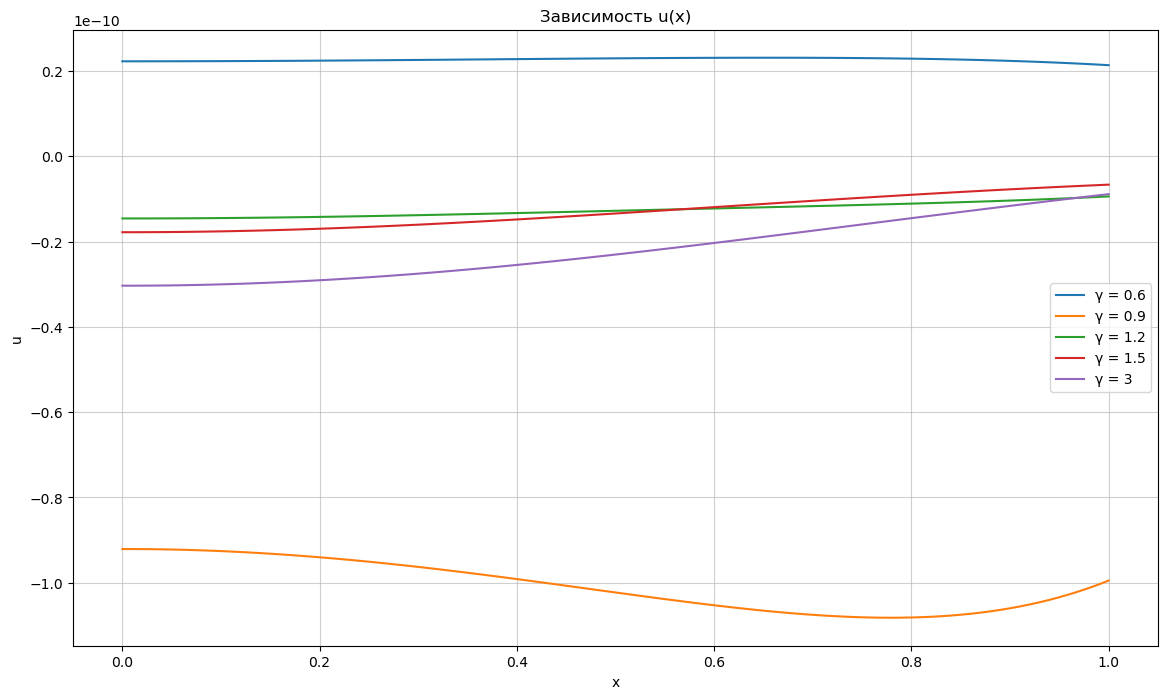

In [159]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], u[i], label=f'γ = {gamma}')

plt.title('Зависимость u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(alpha=0.6)

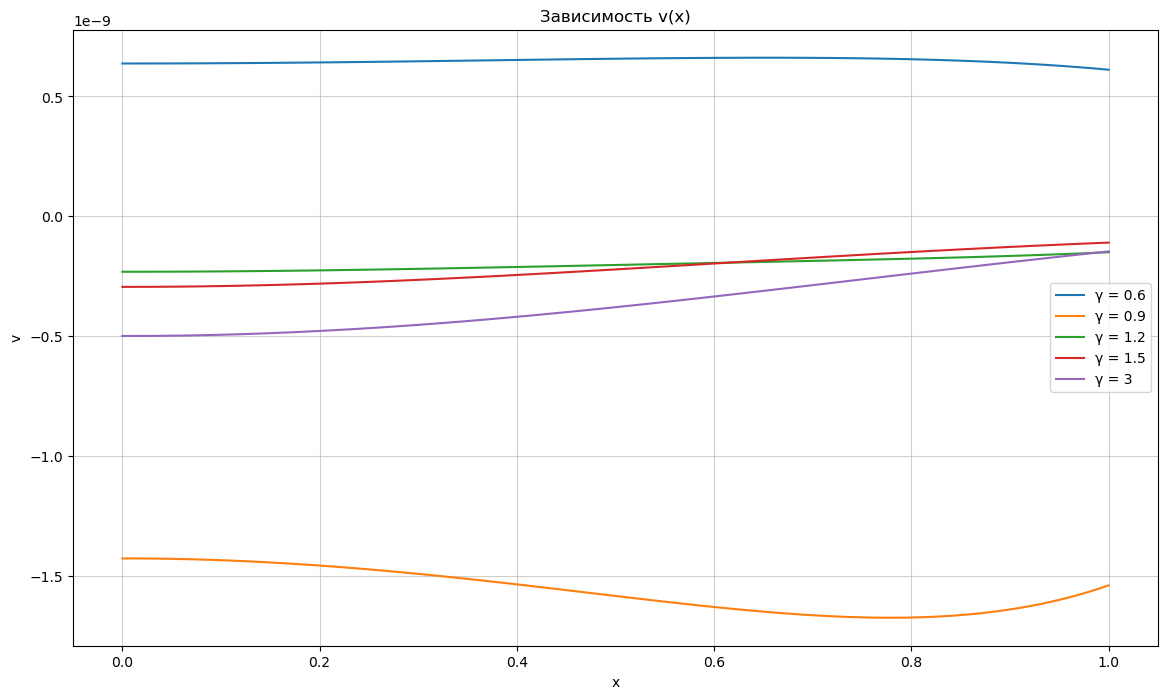

In [160]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], v[i], label=f'γ = {gamma}')

plt.title('Зависимость v(x)')
plt.xlabel('x')
plt.ylabel('v')
plt.legend()
plt.grid(alpha=0.6)

Полученные решения оказываются частично в области отрицательных значений, что плохо, поскольку решением является физически осымсленные величины: Зависимость концентраций от расстояния, которые ``не могут быть отрицательными``.

**Попробуем правильнее инициализировать граничные условия:**

Используем приближение на основе $ z(x) $:

Так как $ z(x) = \frac{\gamma}{1+\gamma} - x $ связано с ресурсом, можно предположить, что концентрации пропорциональны $ z(x) $:

- $ u_0(x) = v_0(x) = k \cdot z(x) $, где $ k $ — малая доля (например, $ k = 0.1 $).
- Преимущества данного решения:
  - Учитывает пространственную зависимость ресурса.
  - $ z(x) $ убывает от $ \frac{\gamma}{1+\gamma} $ до $ -\frac{1}{1+\gamma} $, что соответствует физическому смыслу.

- Недостаток:
  - $ z(x) $ становится отрицательным при $ x > \frac{\gamma}{1+\gamma} $, так что необходимо скорректировать условия (возьмём $ \max(0, z(x)) $).

Также данная инициализация безусловно учитывает граничные условия задачи, поскольку:
$u'_0(0 )=v'_0(0)=0$, так как $z'(x) = -1$

In [3]:
from scipy.sparse import diags

N=100

def chemostat_system_init(gamma, Du, Dv, a, b, N=N):
    # Параметры сетки
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]

    
    # Функция h(s)
    h = lambda s: s / (a + s + b * s**2)
    
    # Инициализация начального приближения
    z = gamma / (1 + gamma) - x
    # Улучшенное начальное приближение
    u = 0.1 * np.maximum(0, z)  
    v = 0.1 * np.maximum(0, z)
    
    # Параметры для квазилинеаризации
    max_iter = 100
    tol = 1e-6
    
    for iteration in range(max_iter):
        u_old = u.copy()
        v_old = v.copy()
        
        # Вычисление текущих значений
        s = z - u - v
        h_val = h(s)
        
        # Якобианы
        dh_ds = (a - b * s**2) / (a + s + b * s**2)**2
        f_u = h_val + u * dh_ds
        f_v = u * dh_ds
        g_u = v * dh_ds
        g_v = h_val + v * dh_ds
        
        # Правая часть
        F = u * h_val
        G = v * h_val
        
        # Матрицы для прогонки
        A = np.zeros((2*N, 2*N))
        b_vec = np.zeros(2*N)
        
        # Заполнение матрицы для u
        for i in range(1, N-1):
            A[i, i] = -2/Du/dx**2 - f_u[i]
            A[i, i-1] = 1/Du/dx**2
            A[i, i+1] = 1/Du/dx**2
            A[i, N+i] = -f_v[i]
            b_vec[i] = -F[i]
        
        # Заполнение матрицы для v
        for i in range(N+1, 2*N-1):
            j = i - N
            A[i, j] = -g_u[j]
            A[i, i] = -2/Dv/dx**2 - g_v[j]
            A[i, i-1] = 1/Dv/dx**2
            A[i, i+1] = 1/Dv/dx**2
            b_vec[i] = -G[j]
        
        # Граничные условия
        # x = 0: u'(0) = v'(0) = 0
        A[0, 0] = -1/dx
        A[0, 1] = 1/dx
        A[N, N] = -1/dx
        A[N, N+1] = 1/dx
        
        # x = 1: du/dx + gamma*u = 0, dv/dx + gamma*v = 0
        A[N-1, N-2] = -1/dx
        A[N-1, N-1] = 1/dx + gamma
        A[2*N-1, 2*N-2] = -1/dx
        A[2*N-1, 2*N-1] = 1/dx + gamma
        
        # Решение системы
        sol = np.linalg.solve(A, b_vec)
        u = sol[:N]
        v = sol[N:]
        
        # Проверка сходимости
        error = max(np.max(np.abs(u - u_old)), np.max(np.abs(v - v_old)))
        if error < tol:
            break
    
    return x, u, v


Исследуем зависимость улучшенных решений от параметра $\gamma$:

In [176]:
gamma_values = [0.6, 0.9, 1.2, 1.5, 3]

x = np.zeros((len(gamma_values), N))
u = np.zeros((len(gamma_values), N))
v = np.zeros((len(gamma_values), N))

for i, gamma in enumerate(gamma_values):
    tpl = chemostat_system_init(gamma, Du=0.01, Dv=0.02, a=0.8, b=0.2)
    x[i] = tpl[0]
    u[i] = tpl[1]
    v[i] = tpl[2]

Построим графики полученных решений (Для построения взяты значения констант $D_u=0.01, D_v=0.02, a=0.8, b=0.2$):

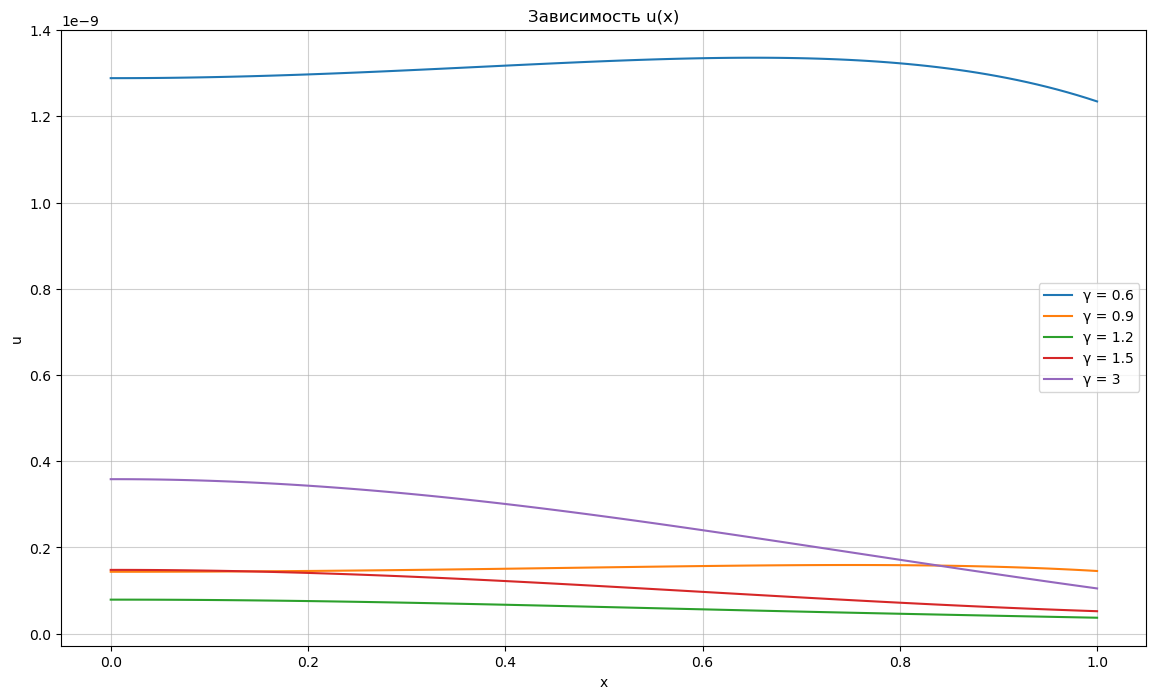

In [177]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], u[i], label=f'γ = {gamma}')

plt.title('Зависимость u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(alpha=0.6)

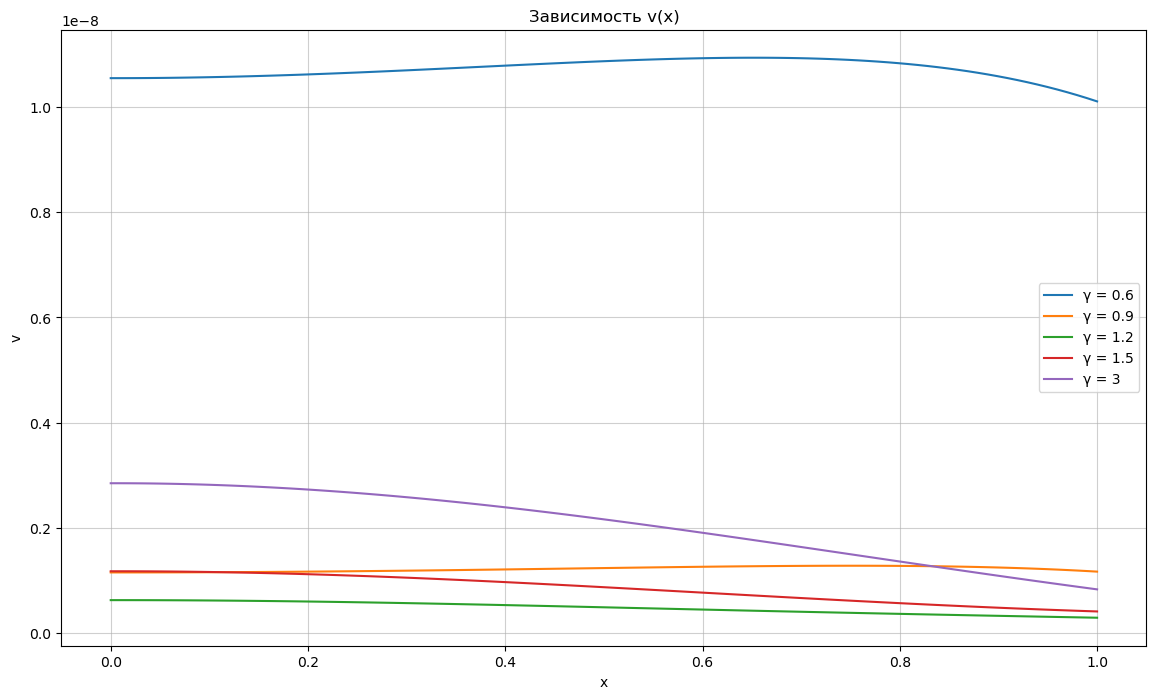

In [178]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], v[i], label=f'γ = {gamma}')

plt.title('Зависимость v(x)')
plt.xlabel('x')
plt.ylabel('v')
plt.legend()
plt.grid(alpha=0.6)

Отлично, теперь мы получили физически осмысленный результат для зависимости концентраций $u; ~ v$ от $x$. Полученные решения также согласуются со сделанными ранее предположениями, а именно:

При увеличении $\gamma$:
- $z(x)$ растет, что увеличивает $s = z - u - v$,
- $h(s)$ стремится к насыщению из-за знаменателя $a + s + b s^2$,
- Условие $u'(1) + \gamma u(1) = 0$ усиливает влияние значения $u(1)$, заставляя концентрацию убывать к краю.

Попробуем аппроксимировать граничные условия с помощью метода фиктивного узла:

### Идея метода фиктивных узлов
Метод фиктивных узлов вводит дополнительные точки за пределами области для упрощения учёта граничных условий при дискретизации. Это особенно полезно для начального приближения и численного решения.

### Расширенная сетка
- Основная сетка: $ x_i = i \Delta x $, $ i = 0, 1, \dots, N-1 $.
- Фиктивные узлы: $ x_{-1} = -\Delta x $, $ x_N = 1 + \Delta x $.

### Учёт граничных условий
1. **Левая граница ($ x = 0 $)**: $ u'(0) = 0 $.
   - Центральная разность: $ u'(0) \approx \frac{u_1 - u_{-1}}{2\Delta x} = 0 $,
   - $ u_{-1} = u_1 $.

2. **Правая граница ($ x = 1 $)**: $ u'(1) + \gamma u(1) = 0 $.
   - Центральная разность: $ u'(1) \approx \frac{u_N - u_{N-2}}{2\Delta x} $,
   - Условие: $ \frac{u_N - u_{N-2}}{2\Delta x} + \gamma u_{N-1} = 0 $,
   - $ u_N = u_{N-2} - 2\Delta x \gamma u_{N-1} $.

Аналогично для $ v $.

### Дискретизация с фиктивными узлами
Для $ i = 0 $:
$$
\frac{u_1 - 2u_0 + u_{-1}}{\Delta x^2} + \text{остальные члены} = 0.
$$
Подставим $ u_{-1} = u_1 $:
$$
\frac{u_1 - 2u_0 + u_1}{\Delta x^2} = \frac{2u_1 - 2u_0}{\Delta x^2}.
$$

Для $ i = N-1 $:
$$
\frac{u_N - 2u_{N-1} + u_{N-2}}{\Delta x^2} + \text{остальные члены} = 0.
$$
Подставим $ u_N = u_{N-2} - 2\Delta x \gamma u_{N-1} $:
$$
\frac{u_{N-2} - 2\Delta x \gamma u_{N-1} - 2u_{N-1} + u_{N-2}}{\Delta x^2} = \frac{2u_{N-2} - 2u_{N-1}(1 + \Delta x \gamma)}{\Delta x^2}.
$$

### Начальное приближение
Используем $ u_0(x) = c (1 - x^2) $:
- $ u_{-1} = c (1 - (-\Delta x)^2) = c (1 - \Delta x^2) $,
- $ u_N = c (1 - (1 + \Delta x)^2) $,
- $ u'(0) = 0 $ выполняется,
- $ u'(1) \approx -2c $ — корректируем через $ u_N $.


In [36]:
def chemostat_system_node(gamma, Du, Dv, a, b, N=N):
    # Сетка
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]
    
    # Функции
    z = lambda x: gamma / (1 + gamma) - x
    h = lambda s: s / (a + s + b * s**2)
    c = max(z(x))*0.1

    # Улучшенное начальное приближение
    u = np.maximum(c * (1 - x**2), 0)  
    v = np.maximum(c * (1 - x**2), 0)
    
    # Расширение с фиктивными узлами
    u_extended = np.zeros(N + 2)  # [-dx, 0, ..., 1, 1+dx]
    v_extended = np.zeros(N + 2)
    u_extended[1:-1] = u
    v_extended[1:-1] = v
    
    # Левый фиктивный узел: u'(0) = 0
    u_extended[0] = u_extended[2]  # u_{-1} = u_1
    v_extended[0] = v_extended[2]
    
    # Правый фиктивный узел: u'(1) + gamma u(1) = 0
    u_extended[-1] = u_extended[-3] - 2 * dx * gamma * u_extended[-2]
    v_extended[-1] = v_extended[-3] - 2 * dx * gamma * v_extended[-2]
    
    # Обрезаем до основной сетки
    u = u_extended[1:-1]
    v = v_extended[1:-1]
    
    # Параметры квазилинеаризации
    max_iter = 100
    tol = 1e-6
    
    for iteration in range(max_iter):
        u_old = u.copy()
        v_old = v.copy()
        
        s = z(x) - u - v
        h_val = h(s)
        
        dh_ds = (a - b * s**2) / (a + s + b * s**2)**2
        f_u = h_val - u * dh_ds
        f_v = -u * dh_ds
        g_u = -v * dh_ds
        g_v = h_val - v * dh_ds
        
        F = u * h_val
        G = v * h_val
        
        A = np.zeros((2*N, 2*N))
        b_vec = np.zeros(2*N)
        
        # Заполнение матрицы (без изменений)
        for i in range(1, N-1):
            A[i, i] = -2/Du/dx**2 - f_u[i]
            A[i, i-1] = 1/Du/dx**2
            A[i, i+1] = 1/Du/dx**2
            A[i, N+i] = -f_v[i]
            b_vec[i] = -F[i]
        
        for i in range(N+1, 2*N-1):
            j = i - N
            A[i, j] = -g_u[j]
            A[i, i] = -2/Dv/dx**2 - g_v[j]
            A[i, i-1] = 1/Dv/dx**2
            A[i, i+1] = 1/Dv/dx**2
            b_vec[i] = -G[j]
        
        # Граничные условия
        A[0, 0] = -1/dx
        A[0, 1] = 1/dx
        A[N, N] = -1/dx
        A[N, N+1] = 1/dx
        
        A[N-1, N-2] = -1/dx
        A[N-1, N-1] = 1/dx + gamma
        A[2*N-1, 2*N-2] = -1/dx
        A[2*N-1, 2*N-1] = 1/dx + gamma
        
        sol = np.linalg.solve(A, b_vec)
        u = sol[:N]
        v = sol[N:]
        
        error = max(np.max(np.abs(u - u_old)), np.max(np.abs(v - v_old)))
        if error < tol:
            break
    
    return x, u, v

Исследуем зависимость решений с улулчшенной аппроксимацией граничных условий от параметра $\gamma$:

In [41]:
gamma_values = np.arange(0.5, 4, 0.4)

x = np.zeros((len(gamma_values), N))
u = np.zeros((len(gamma_values), N))
v = np.zeros((len(gamma_values), N))

for i, gamma in enumerate(gamma_values):
    tpl = chemostat_system_node(gamma, Du=0.01, Dv=0.02, a=0.8, b=0.2)
    x[i] = tpl[0]
    u[i] = tpl[1]
    v[i] = tpl[2]

In [43]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], u[i], label=f'γ = {gamma:.2f}')

plt.title('Зависимость u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(alpha=0.6)

In [44]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], v[i], label=f'γ = {gamma:.2f}')

plt.title('Зависимость v(x)')
plt.xlabel('x')
plt.ylabel('v')
plt.legend()
plt.grid(alpha=0.6)

При значении $\gamma$ близком к $0.7; 0.8$ (зависит от соотношения парметров a и b)  основные проблемы связанные с отрицательной концентрацией:

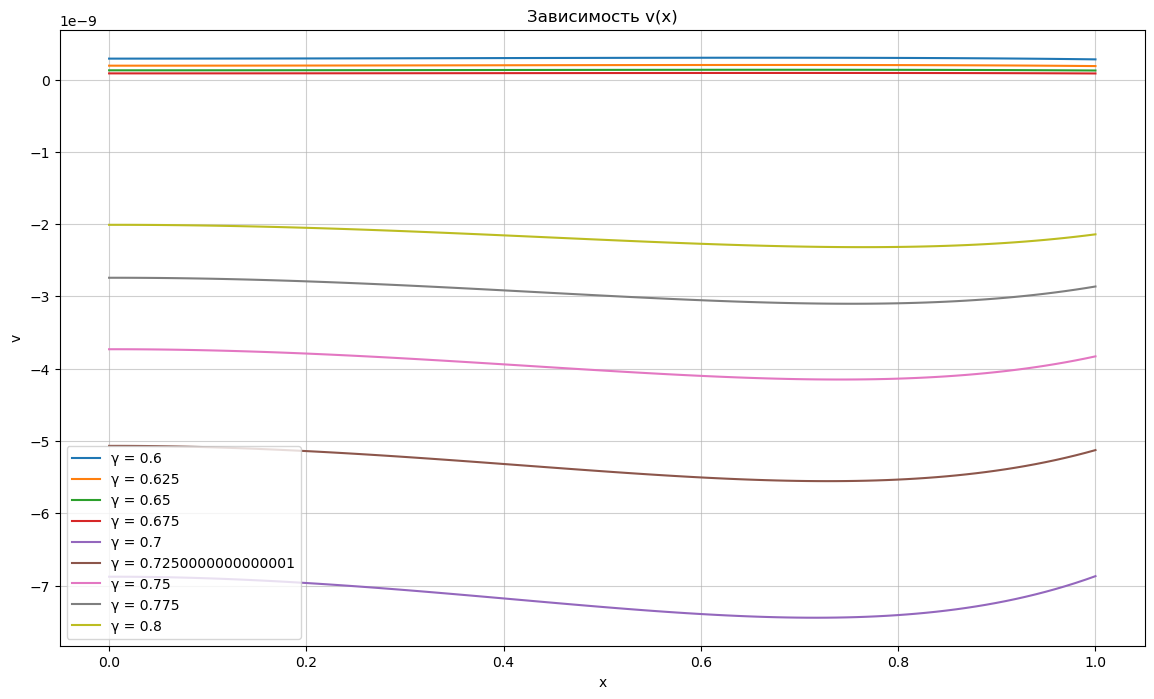

In [71]:
gamma_values = np.linspace(0.6, 0.8, 9)

x = np.zeros((len(gamma_values), N))
u = np.zeros((len(gamma_values), N))
v = np.zeros((len(gamma_values), N))

for i, gamma in enumerate(gamma_values):
    tpl = chemostat_system_node(gamma, Du=0.01, Dv=0.02, a=0.9, b=0.1)
    x[i] = tpl[0]
    u[i] = tpl[1]
    v[i] = tpl[2]

plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], u[i], label=f'γ = {gamma}')

plt.title('Зависимость u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(alpha=0.6)

plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], v[i], label=f'γ = {gamma}')

plt.title('Зависимость v(x)')
plt.xlabel('x')
plt.ylabel('v')
plt.legend()
plt.grid(alpha=0.6)

Зависимость от парметра $\gamma$ в области строго положительных решений:

In [215]:
gamma_values = np.arange(1.2, 5, 0.4)

x = np.zeros((len(gamma_values), N))
u = np.zeros((len(gamma_values), N))
v = np.zeros((len(gamma_values), N))

for i, gamma in enumerate(gamma_values):
    tpl = chemostat_system_node(gamma, Du=0.01, Dv=0.02, a=0.8, b=0.2)
    x[i] = tpl[0]
    u[i] = tpl[1]
    v[i] = tpl[2]

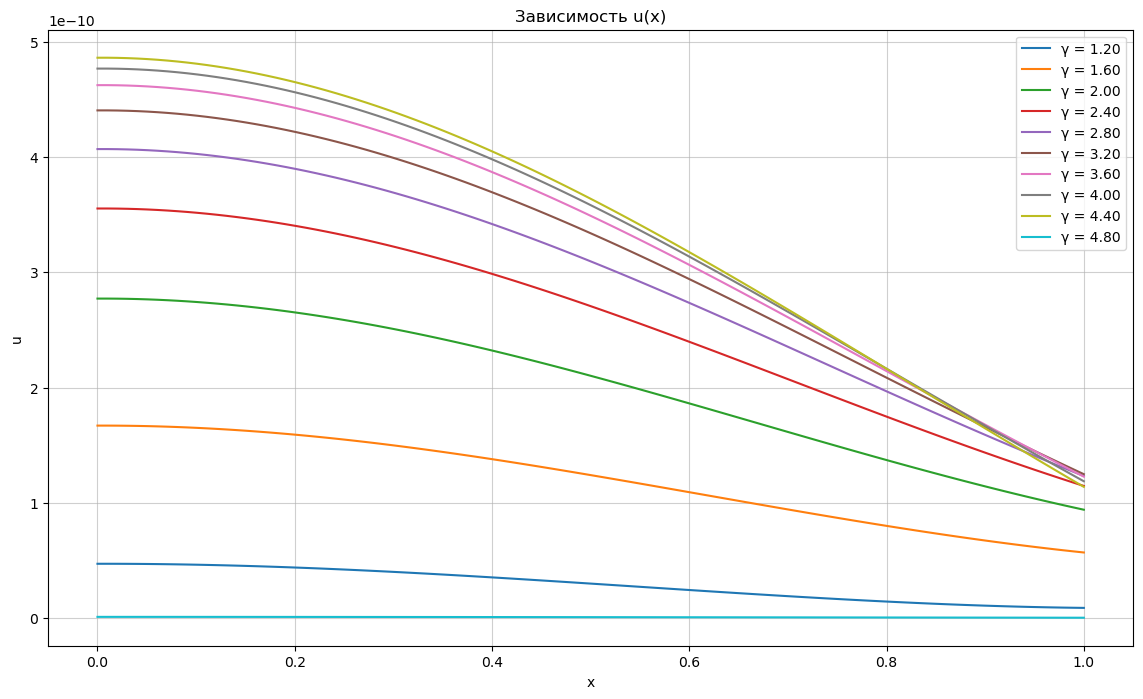

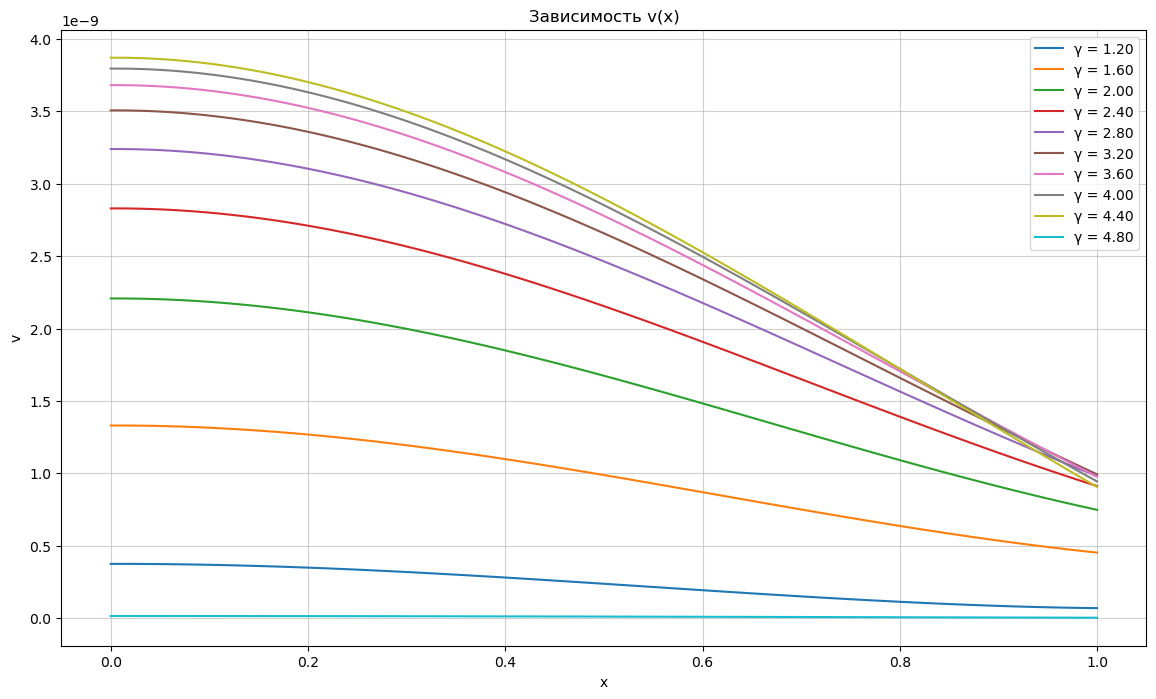

In [216]:
plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], u[i], label=f'γ = {gamma:.2f}')

plt.title('Зависимость u(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(alpha=0.6)

plt.figure(figsize=(14, 8))

for i, gamma in enumerate(gamma_values):
    plt.plot(x[i], v[i], label=f'γ = {gamma:.2f}')

plt.title('Зависимость v(x)')
plt.xlabel('x')
plt.ylabel('v')
plt.legend()
plt.grid(alpha=0.6)

Видно, что при увеличении $\gamma$ растёт скорость убывания концентрации обеих популяций к правому краю

### Вывод:

 В данной задаче был изучен метод квазилинеаризации для решения краевых задач. Было рассмотрено несколько вариантов начальных приближений: константное приближение, параболой, удовлетворяющей краевым условиям. Была построена аппрокисмация граничных условий с помощью метода фиктивного узла, что привело к появлению физически осмысленных решений стационарного распределения концентраций бактерий. 
 
**Сходимость решения**:
   - Метод квазилинеаризации с дискретизацией и использованием матричной прогонки (или прямого решения системы) успешно приводит к стационарному распределению. Графики выглядят гладкими, что указывает на хорошую аппроксимацию и сходимость итерационного процесса.

 Анализ полученных решений и их зависимость от параметра $\gamma$ влияющего не распределение ресурса

   - График показывает, что концентрации двух типов бактерий $u(x),  v(x) $ является неотрицательной и убывающей функцией вдоль оси $ x $ от 0 до 1. Концентрации зависят от доступного ресурса $ z(x) = \frac{\gamma}{1 + \gamma} - x $, убывающего с увеличением $ x $ что согласуется с условием и логикой.
   - Начальное значение $ u(0), v(0) $ для всех $ \gamma $ положительно и близко к максимуму, что соответствует нулевому потоку на границе $ x = 0 $ ($ v'(0) = 0 $).
   - Конечное значение $ v(1) $ стремится к нулю или становится отрицательным (для малых $ \gamma $), что связано с граничным условием $ v'(1) + \gamma v(1) = 0 $, усиливающим убывание концентрации к правому краю.

   - Убывание $ u(x), v(x) $ вдоль $ x $ отражает конкуренцию популяций и истощение ресурса к правой границе